<a href="https://colab.research.google.com/github/losttee/Unet_polyp.Segmentation/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bkai-igh-neopolyp.zip to bkai-igh-neopolyp.zip


In [ ]:
import zipfile
import os

# Giải nén file zip vào thư mục content
with zipfile.ZipFile('bkai-igh-neopolyp.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')


In [ ]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 45.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=351394e8c91a6018e8895c411d42ec82077a5d9ea334bc90087f57361a65ec90
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=ff2874bcc900501d8ec80fcb5693ec89d598a644c3492a649bde0363030e30c5
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

In [ ]:
!pip install torchinfo


In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, random_split, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torchvision.transforms import ToTensor
from PIL import Image
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchinfo import summary
import timm

In [ ]:
!nvidia-smi

Sat Nov 23 13:56:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, label_dir, resize=None, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.resize = resize
        self.transform = transform
        self.images = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.images)

    def read_mask(self, mask_path):
        image = cv2.imread(mask_path)
        image = cv2.resize(image, self.resize)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        lower1 = np.array([0, 100, 20])
        upper1 = np.array([10, 255, 255])

        lower2 = np.array([160,100,20])
        upper2 = np.array([179,255,255])
        lower_mask = cv2.inRange(image, lower1, upper1)
        upper_mask = cv2.inRange(image, lower2, upper2)

        red_mask = lower_mask + upper_mask;
        red_mask[red_mask != 0] = 1

        green_mask = cv2.inRange(image, (36, 25, 25), (70, 255, 255))
        green_mask[green_mask != 0] = 2

        full_mask = cv2.bitwise_or(red_mask, green_mask)
        full_mask = np.expand_dims(full_mask, axis=-1)
        full_mask = full_mask.astype(np.uint8)

        return full_mask

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = cv2.imread(img_path)  # Đọc ảnh dưới dạng BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert sang RGB
        label = self.read_mask(label_path)
        image = cv2.resize(image, self.resize)
        if self.transform:
            image = self.transform(image)

        return image, label

    def show_image(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = plt.imread(img_path)
        label = plt.imread(label_path)
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image)
        axs[0].set_title('Image')
        axs[1].imshow(label)
        axs[1].set_title('Label')
        plt.show()

In [ ]:
image_path = []
TRAIN_DIR = '/content/train/train'
for root, dirs, files in os.walk(TRAIN_DIR):
    for file in files:
        path = os.path.join(root,file)
        image_path.append(path)

len(image_path)

1000

In [ ]:
mask_path = []
TRAIN_MASK_DIR = '/content/train_gt/train_gt'
for root, dirs, files in os.walk(TRAIN_MASK_DIR):
    for file in files:
        path = os.path.join(root,file)
        mask_path.append(path)

len(mask_path)

1000

In [ ]:
dataset = CustomImageDataset(img_dir= TRAIN_DIR,
                             label_dir= TRAIN_MASK_DIR,
                             resize= (256,256),
                             transform = None)

In [ ]:
import segmentation_models_pytorch as smp

model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 333MB/s]


In [ ]:
batch_size = 8
images_data = []
labels_data = []
for x,y in dataset:
    images_data.append(x)
    labels_data.append(y)

In [ ]:
class CustomDataset(CustomImageDataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        image = self.data[index]
        label = self.targets[index]
        if self.transform:
            transformed = self.transform(image=image, mask=label)
            image = transformed['image'].float()
            label = transformed['mask'].float()
            label = label.permute(2, 0, 1)
        return image, label

    def __len__(self):
        return len(self.data)


train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),
    A.RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

train_size = int(0.9 * len(images_data))
val_size = len(images_data) - train_size
train_dataset = CustomDataset(images_data[:train_size], labels_data[:train_size], transform=train_transform)
val_dataset = CustomDataset(images_data[train_size:], labels_data[train_size:], transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
print(len(train_dataset))
print(len(val_dataset))

900
100


<ipython-input-22-bd620c584c25>:24: UserWarning: Argument 'eps' is not valid and will be ignored.
  A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),


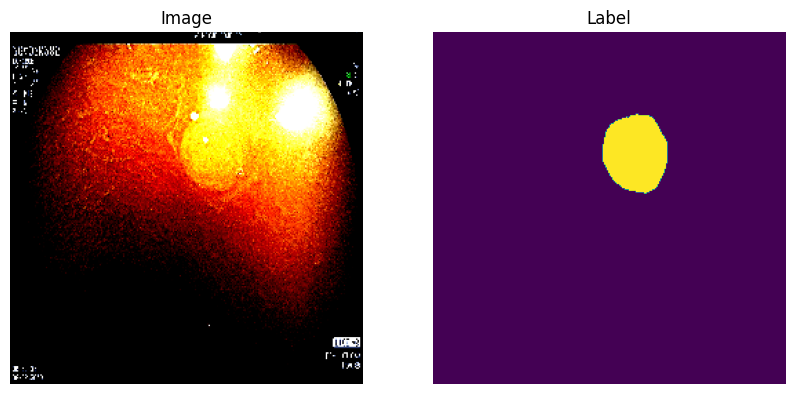

In [ ]:
image,label = train_dataset[2]

label_array = label.permute(1, 2, 0).numpy()
image_array = image.permute(1, 2, 0).numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_array)
axs[0].set_title('Image')
axs[0].axis('off')

axs[1].imshow(label_array)
axs[1].set_title('Label')
axs[1].axis('off')

plt.show()

In [ ]:
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
color_dict= {0: (0, 0, 0),
             1: (255, 0, 0),
             2: (0, 255, 0)}
def mask_to_rgb(mask, color_dict):
    output = np.zeros((mask.shape[0], mask.shape[1], 3))

    for k in color_dict.keys():
        output[mask==k] = color_dict[k]

    return np.uint8(output)

In [ ]:
!pip install wandb
import wandb
!wandb login 'f5efa979f9805eddad16e387fb6bc4b7a02bafa5'

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.init(
    project = 'Unet_polyp.Segmentation'
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: vuha03042004 (vuha03042004-hanoi-university-of-science-and-technology). Use `wandb login --relogin` to force relogin


Epoch [1/200], Loss: 0.3509628796
Save new model


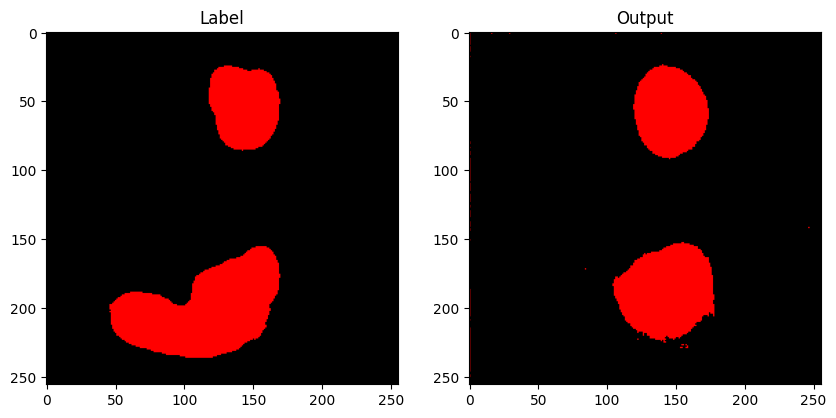

Epoch [2/200], Loss: 0.1857153498
Save new model


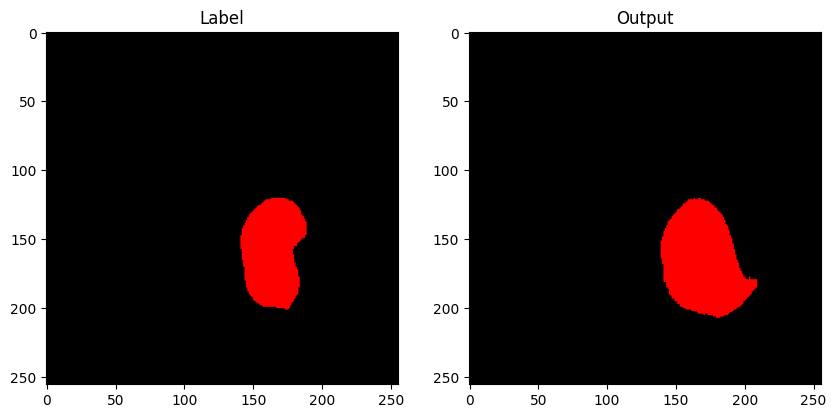

Epoch [3/200], Loss: 0.1400309841
Save new model


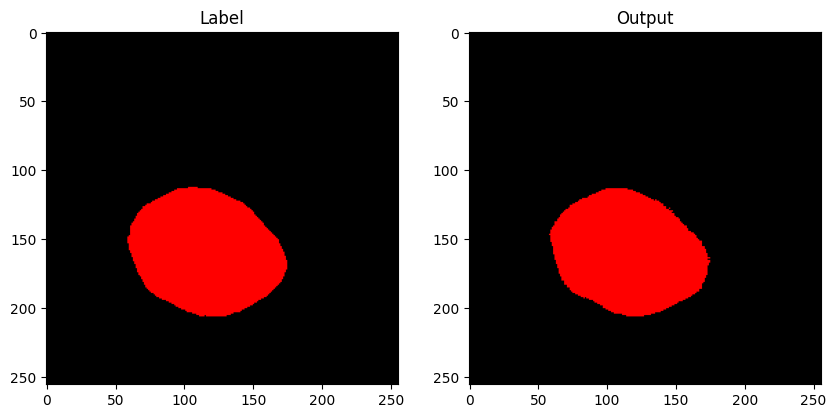

Epoch [4/200], Loss: 0.1028259540
Save new model


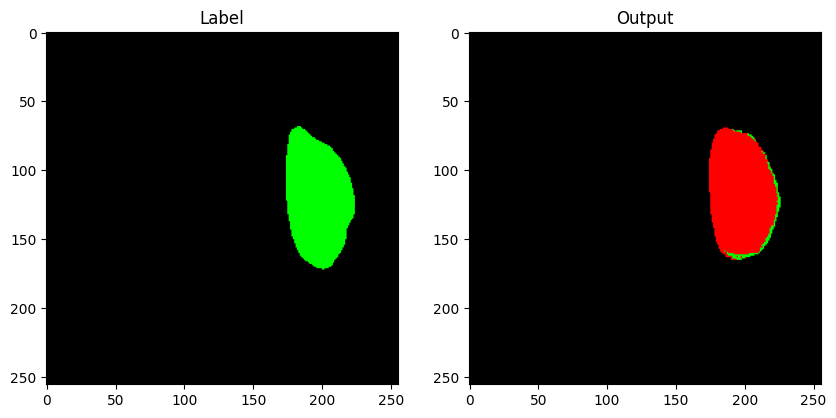

Epoch [5/200], Loss: 0.0948372211
Save new model


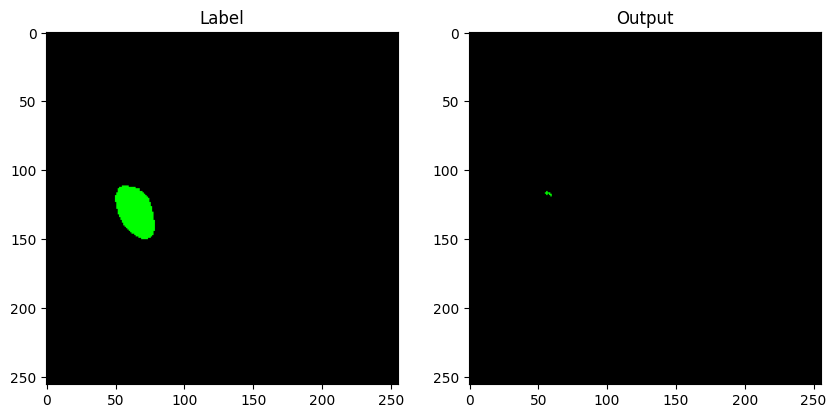

Epoch [6/200], Loss: 0.0865206856
Save new model


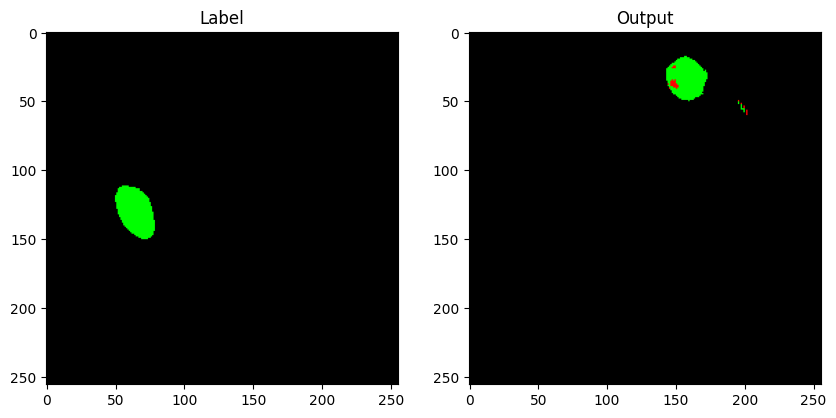

Epoch [7/200], Loss: 0.0822884108
Save new model


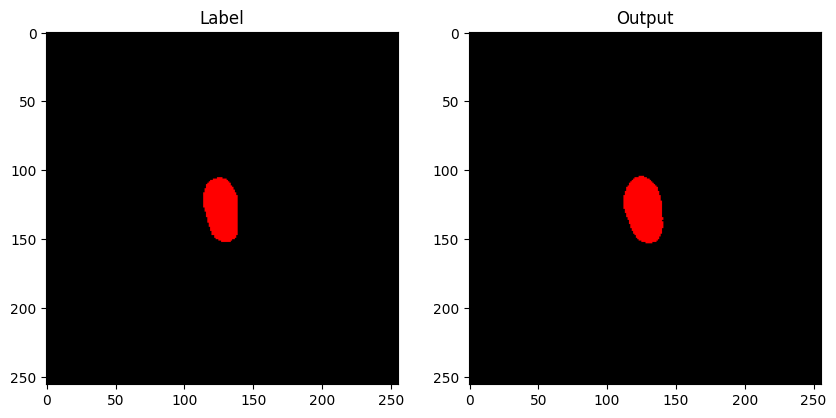

Epoch [8/200], Loss: 0.1048029959


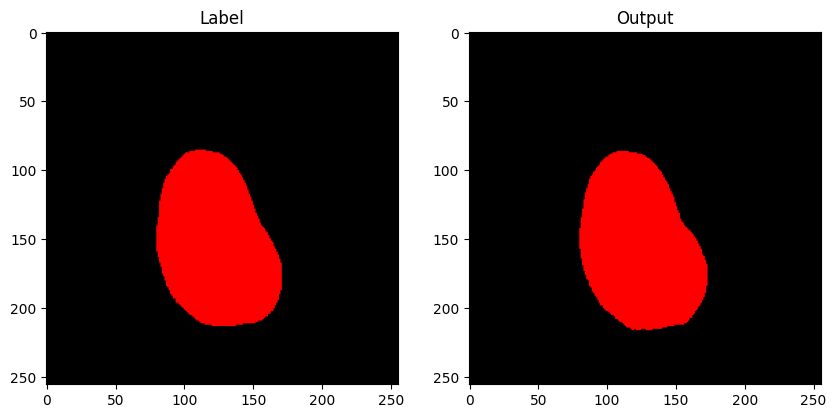

Epoch [9/200], Loss: 0.0782231687
Save new model


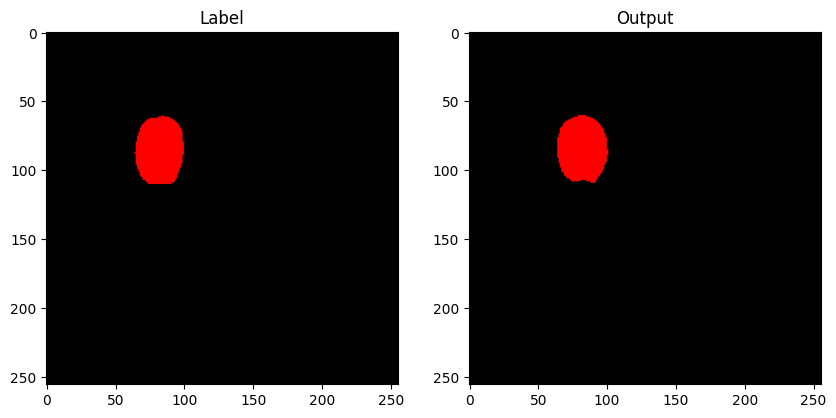

Epoch [10/200], Loss: 0.0783092925


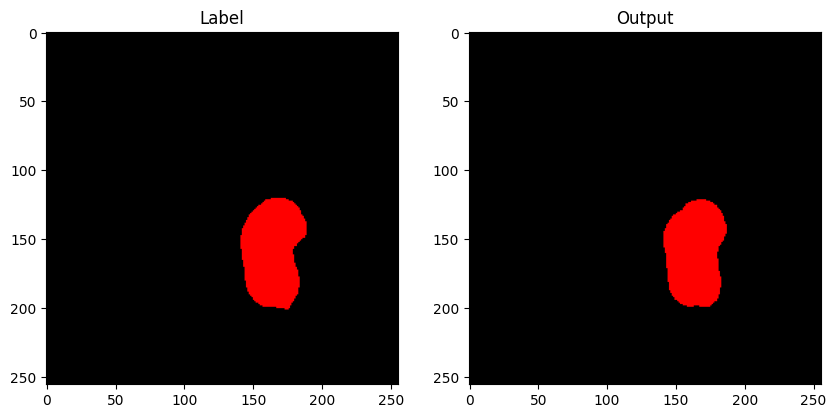

Epoch [11/200], Loss: 0.1055180289


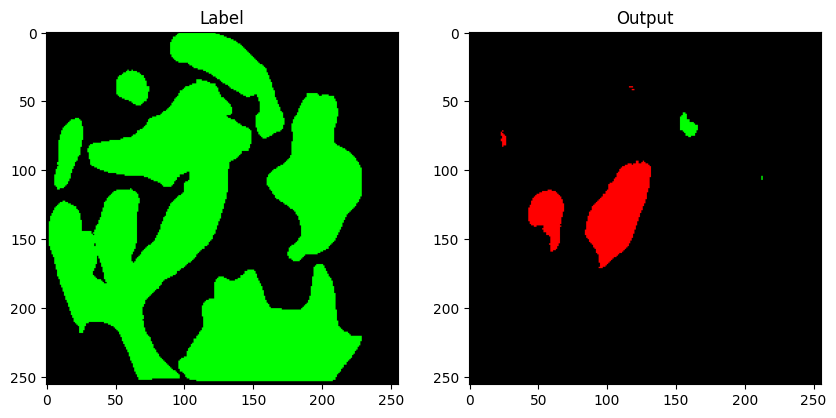

Epoch [12/200], Loss: 0.0780052505
Save new model


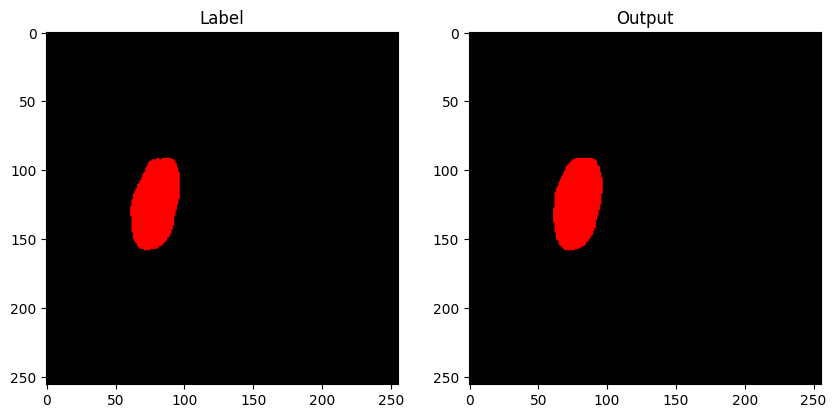

Epoch [13/200], Loss: 0.0756813550
Save new model


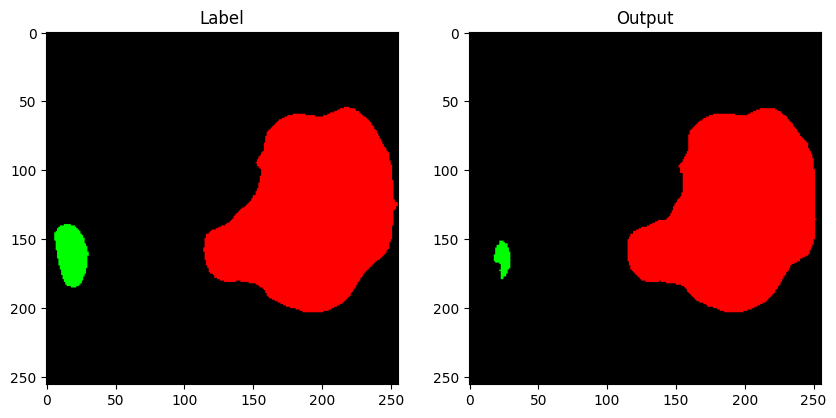

Epoch [14/200], Loss: 0.0876120363


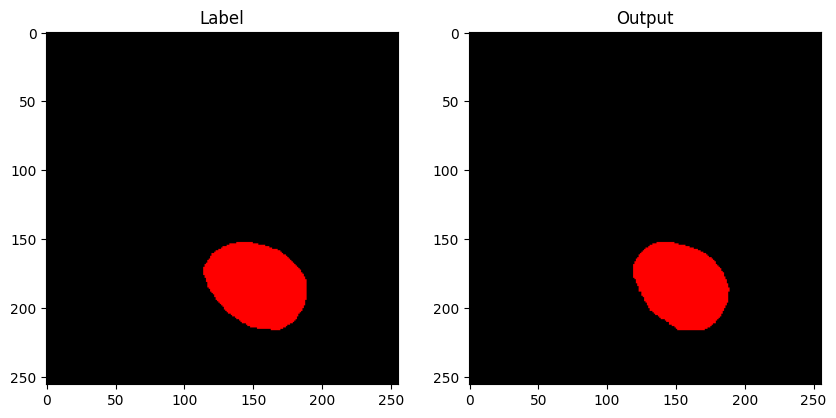

Epoch [15/200], Loss: 0.0869125225


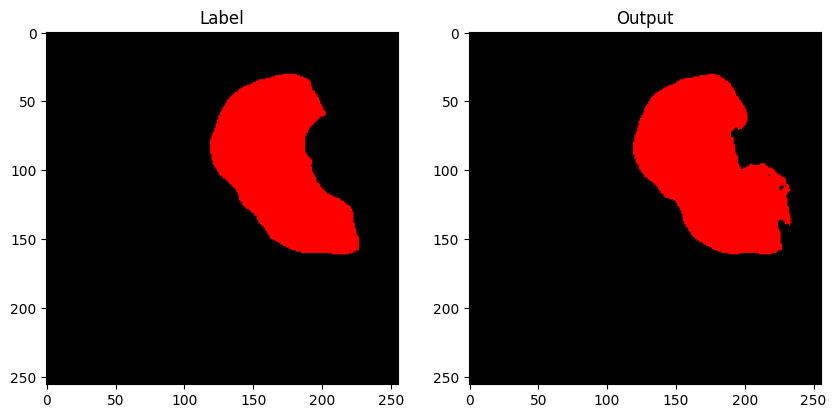

Epoch [16/200], Loss: 0.0825533855


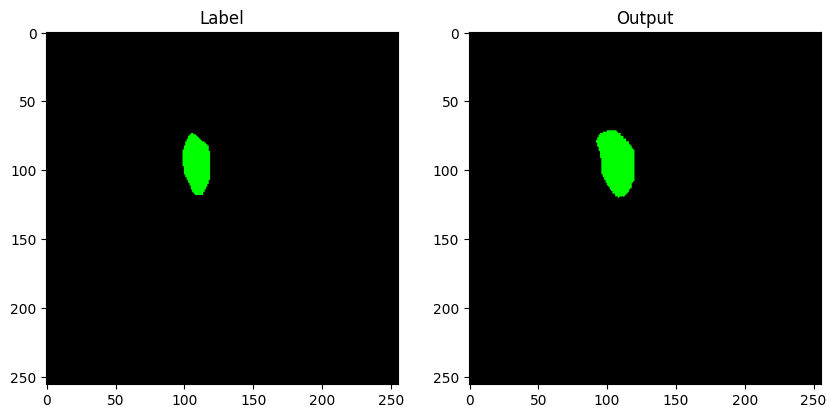

Epoch [17/200], Loss: 0.0771387999


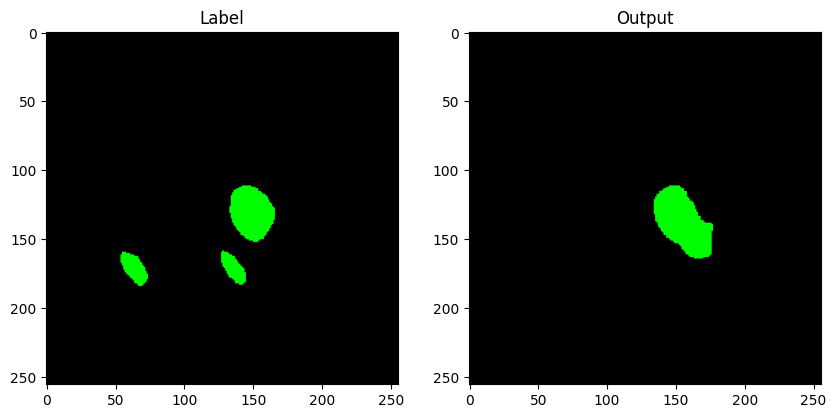

Epoch [18/200], Loss: 0.0800718336


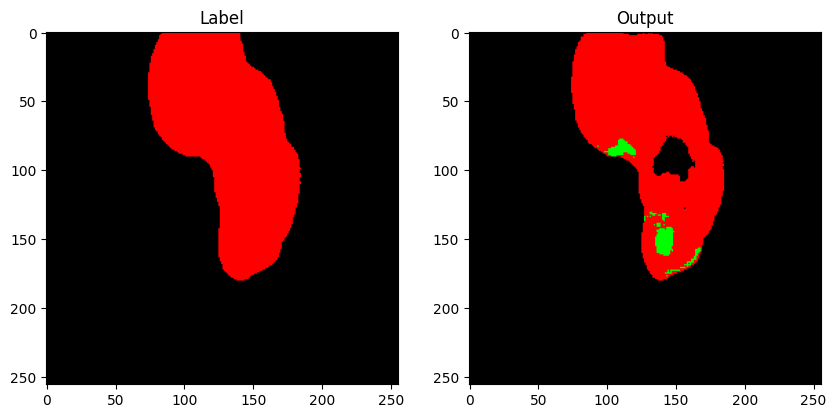

Epoch [19/200], Loss: 0.0759572168


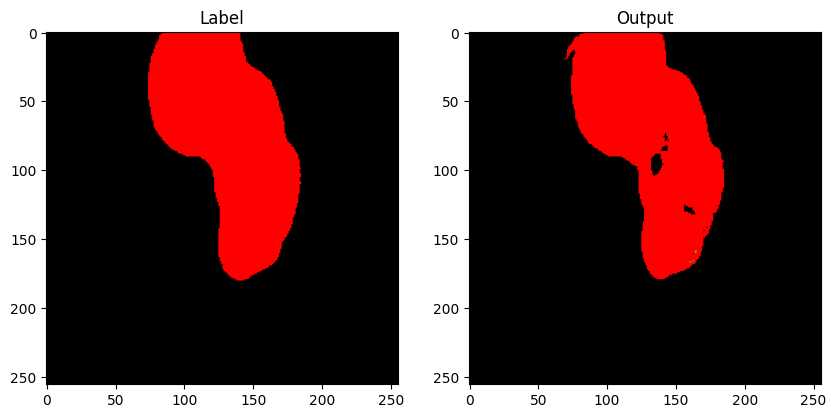

Epoch [20/200], Loss: 0.0851895892


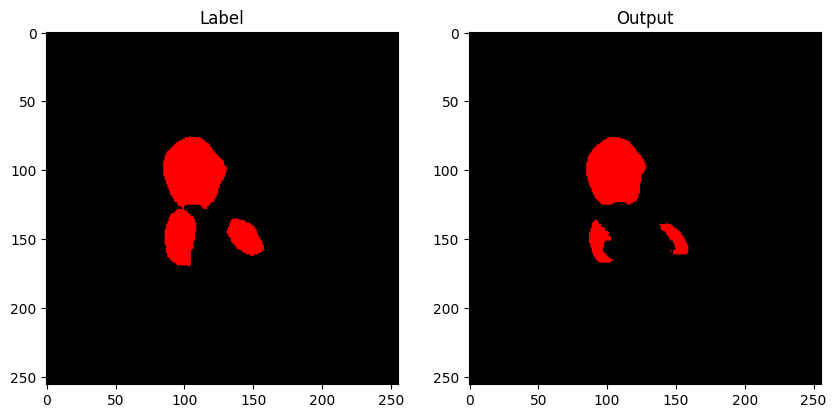

Epoch [21/200], Loss: 0.0822285811


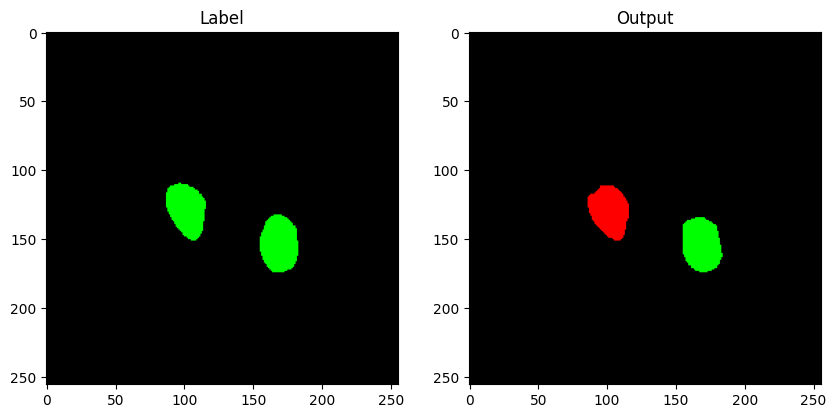

Epoch [22/200], Loss: 0.0847791823


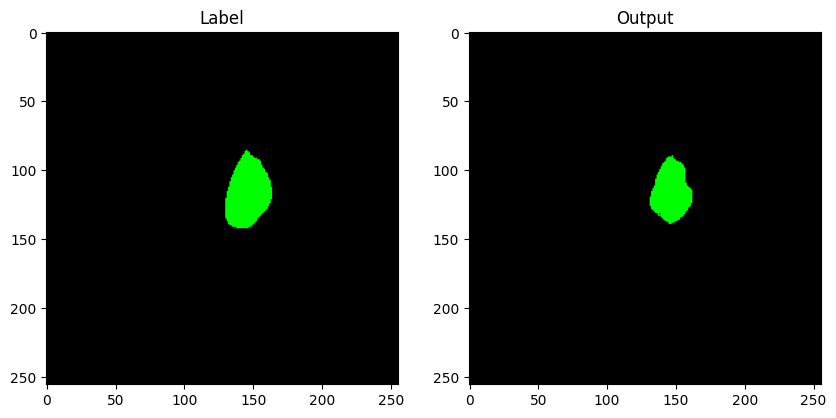

Epoch [23/200], Loss: 0.0854289457


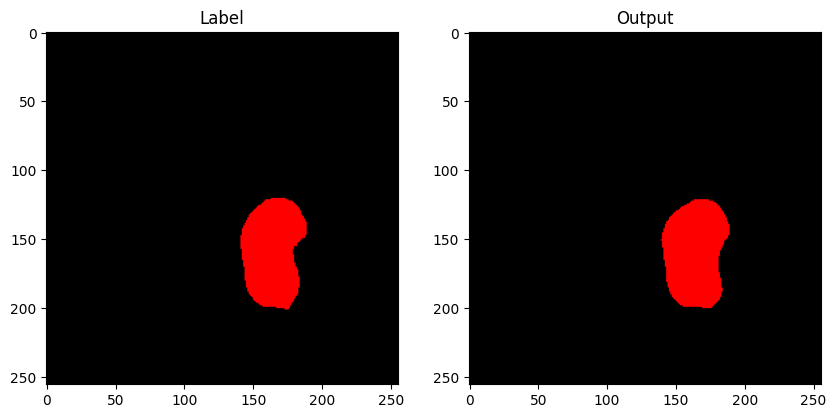

Epoch [24/200], Loss: 0.0896175429


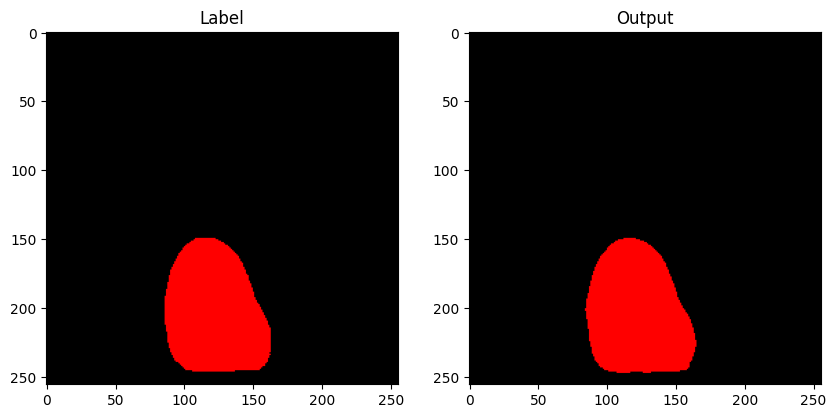

Epoch [25/200], Loss: 0.0814871141


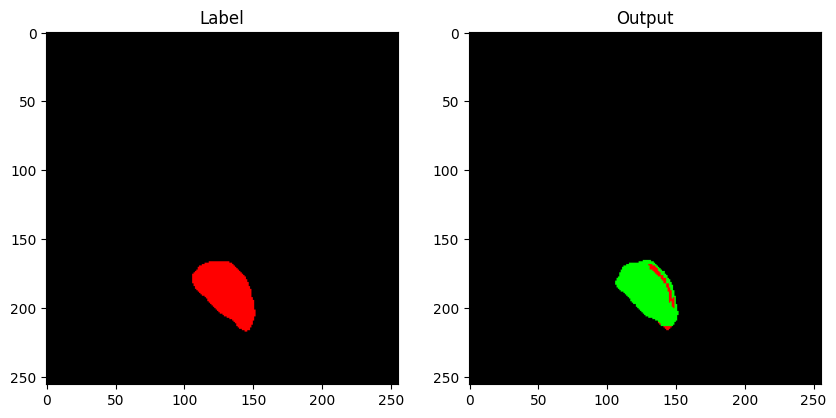

Epoch [26/200], Loss: 0.0915710665


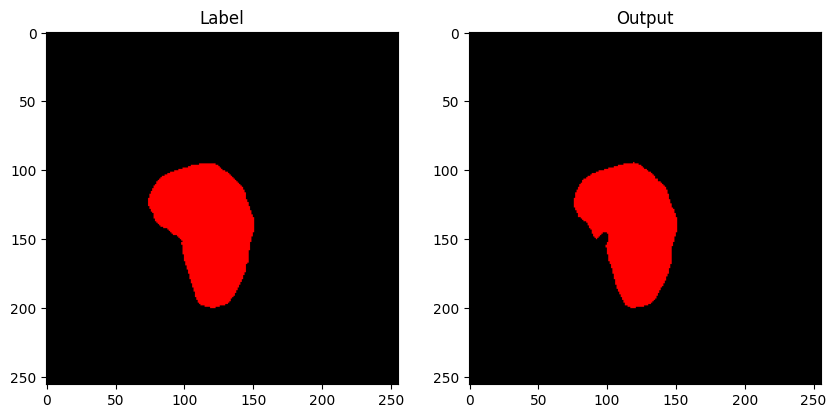

Epoch [27/200], Loss: 0.0802154458


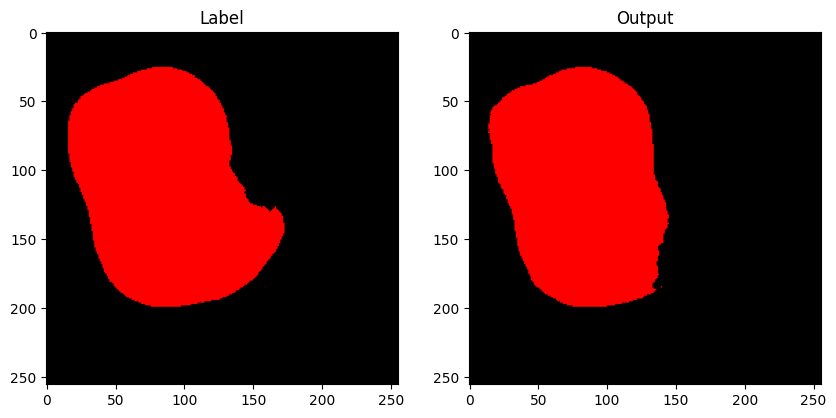

Epoch [28/200], Loss: 0.0827298119


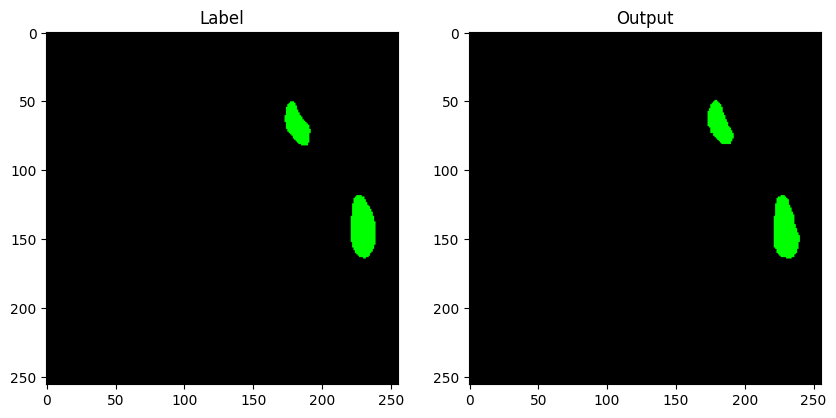

Epoch [29/200], Loss: 0.0803571621


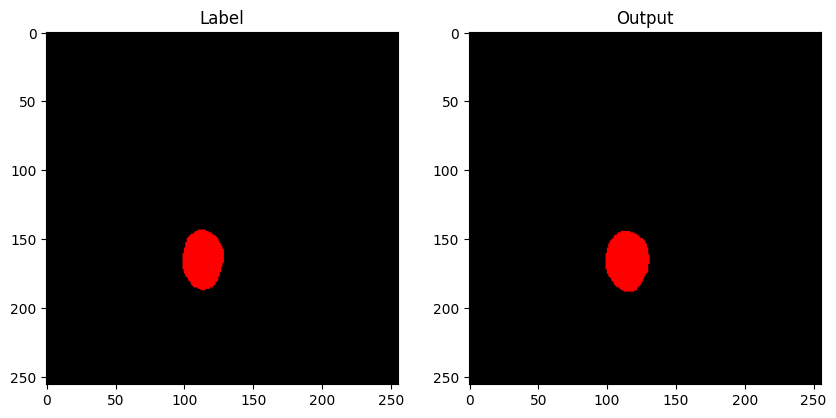

Epoch [30/200], Loss: 0.0880928819


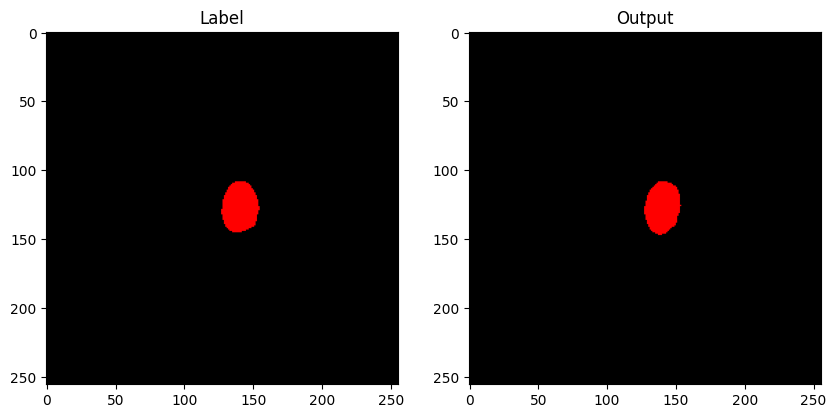

Epoch [31/200], Loss: 0.0962716001


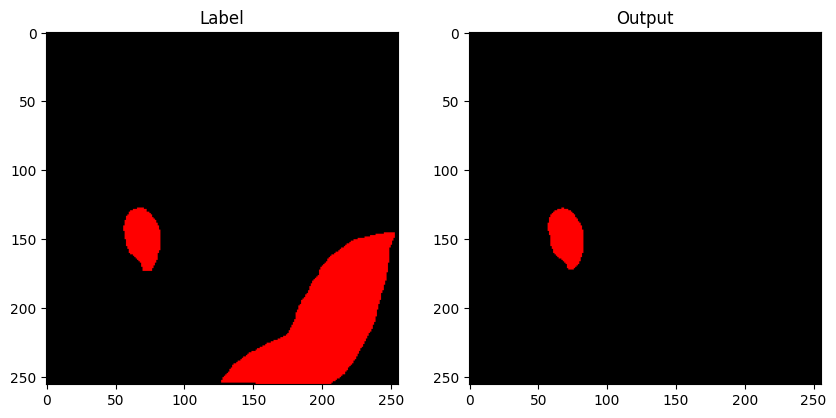

Epoch [32/200], Loss: 0.0789871832


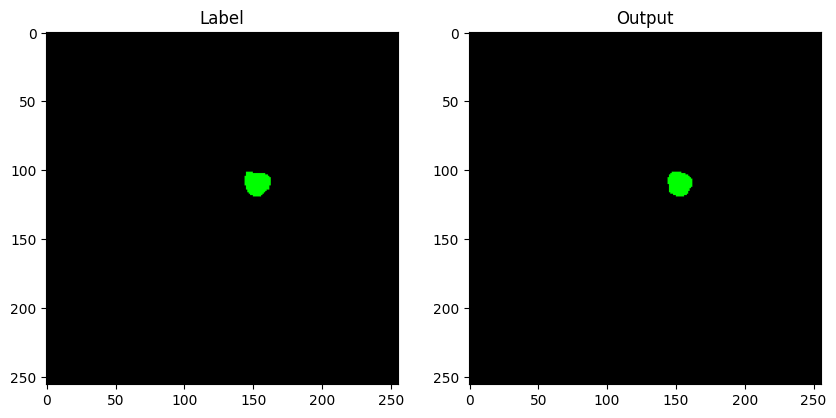

Epoch [33/200], Loss: 0.0846072004


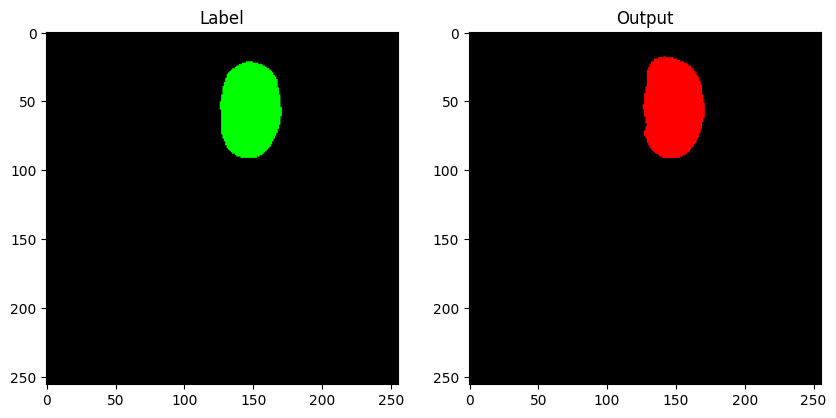

Epoch [34/200], Loss: 0.0868871537


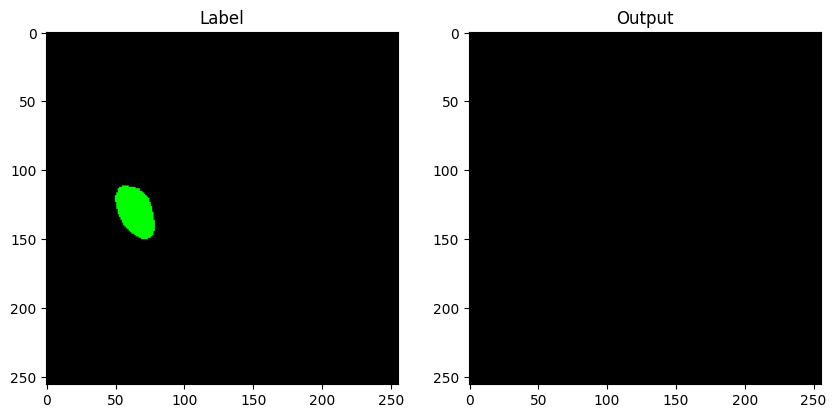

Epoch [35/200], Loss: 0.0884396776


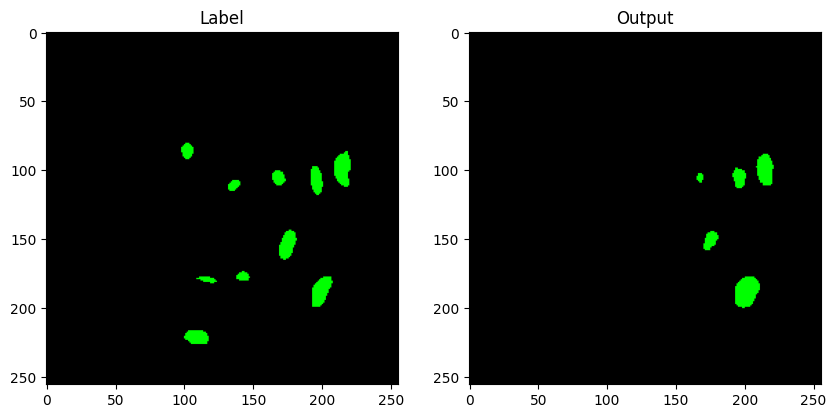

Epoch [36/200], Loss: 0.0970680217


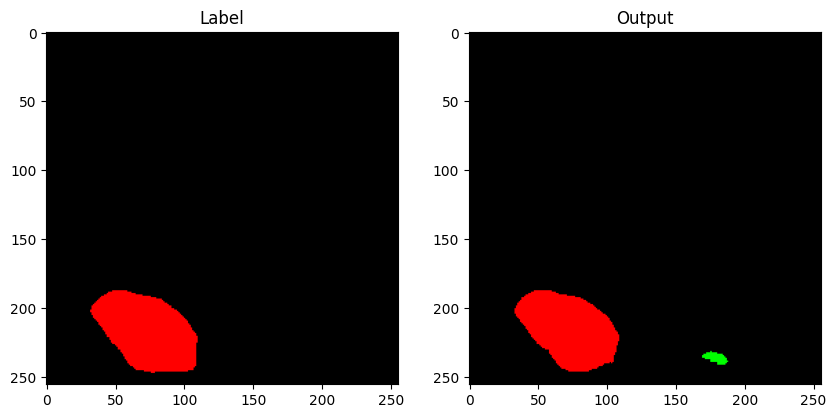

Epoch [37/200], Loss: 0.0868522893


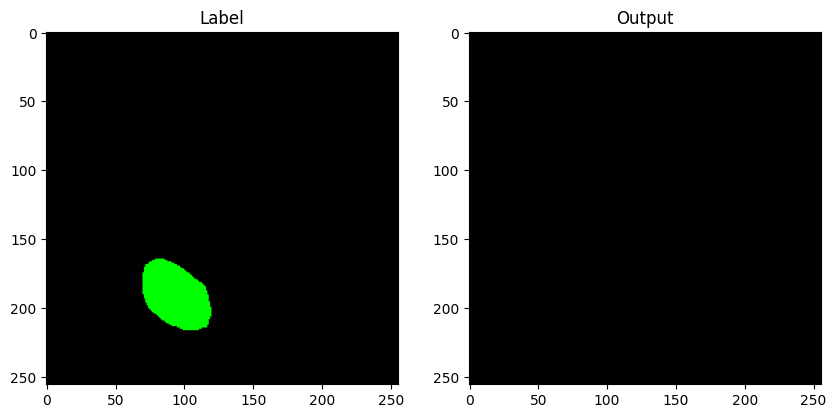

Epoch [38/200], Loss: 0.0996382900


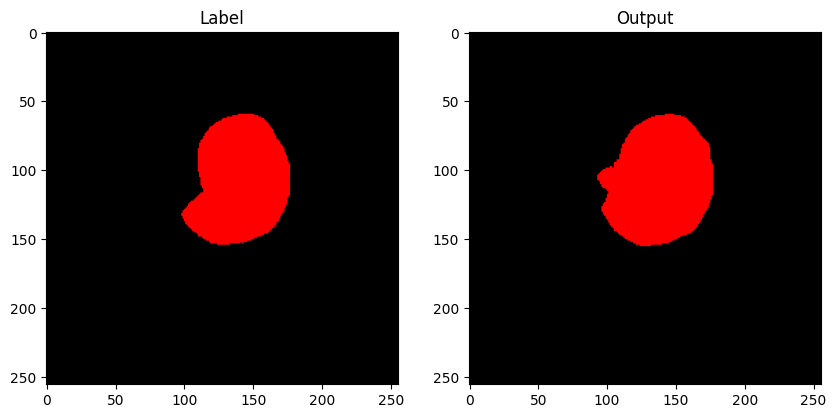

Epoch [39/200], Loss: 0.0956800450


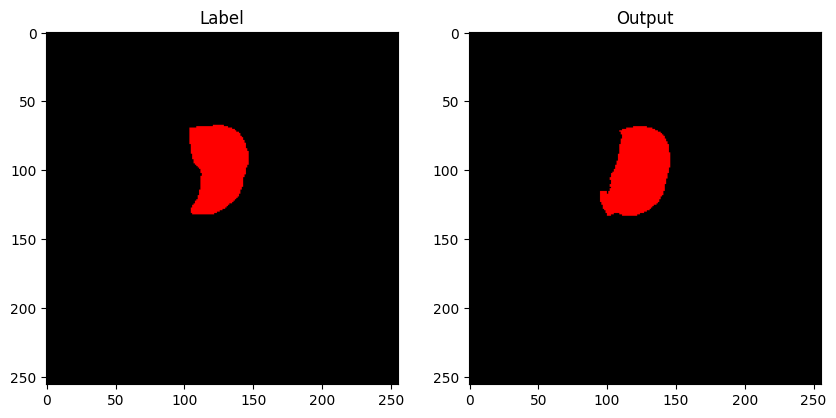

Epoch [40/200], Loss: 0.0963603649


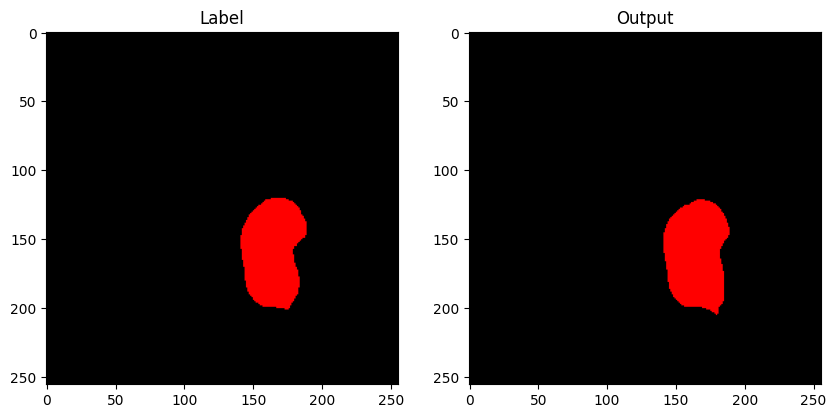

Epoch [41/200], Loss: 0.0983961596


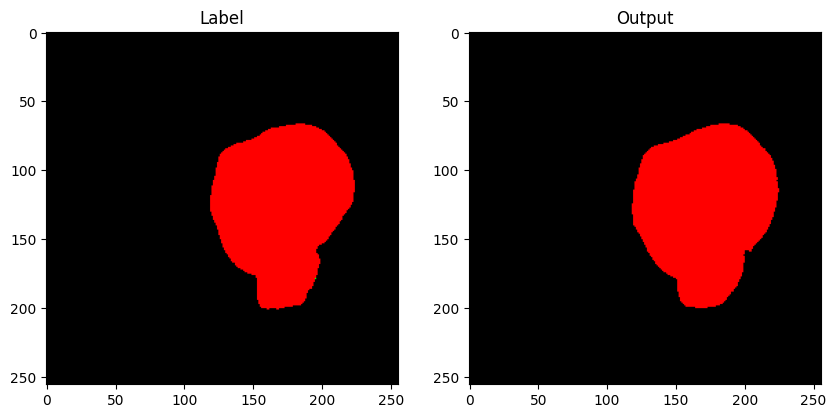

Epoch [42/200], Loss: 0.1098515339


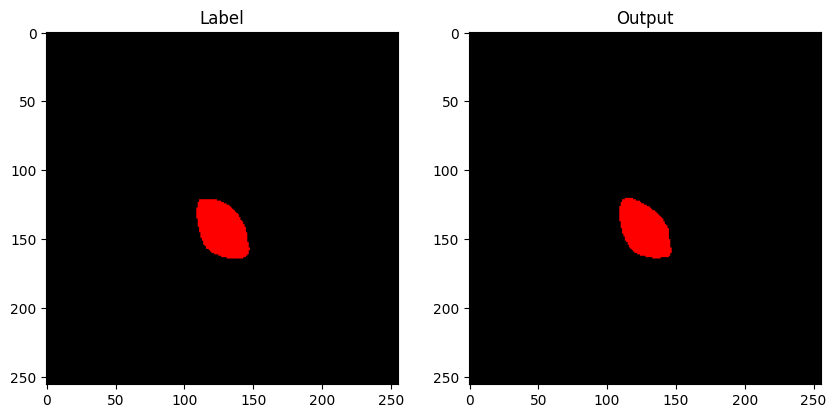

Epoch [43/200], Loss: 0.1012494954


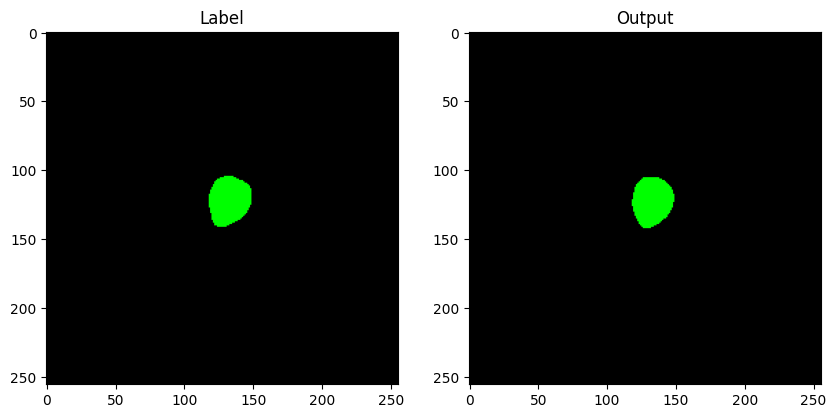

Epoch [44/200], Loss: 0.0991206211


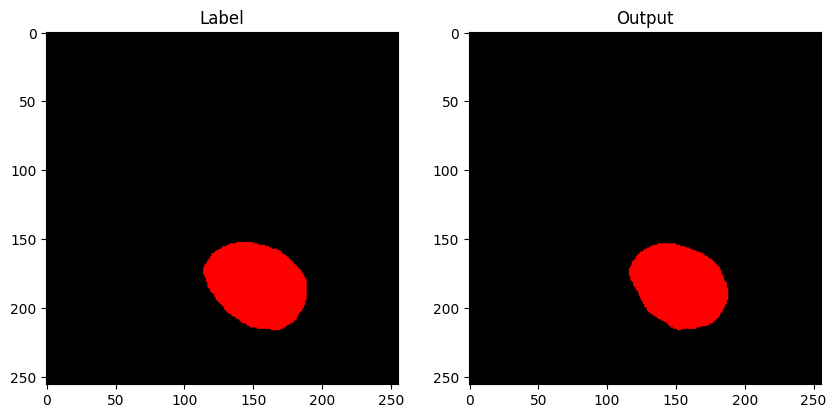

Epoch [45/200], Loss: 0.1021481327


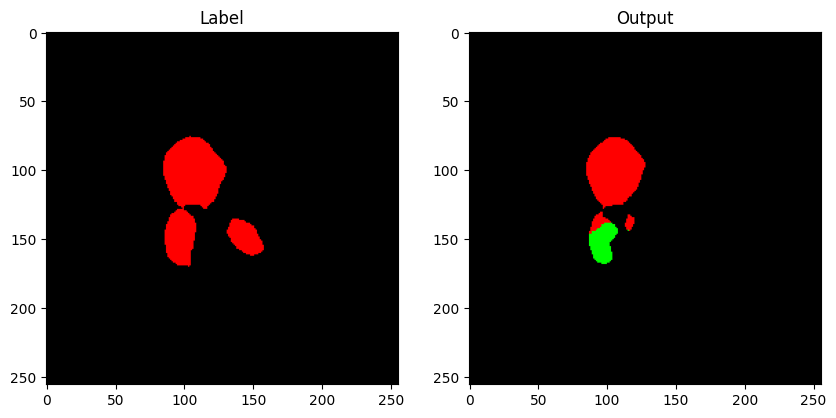

Epoch [46/200], Loss: 0.0894573684


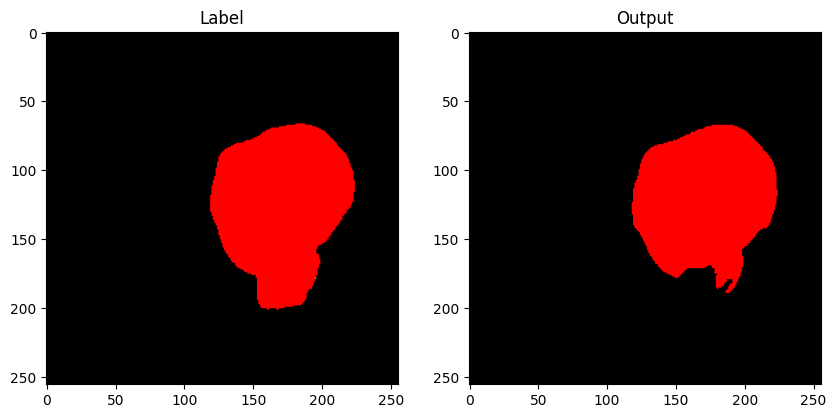

Epoch [47/200], Loss: 0.0921561626


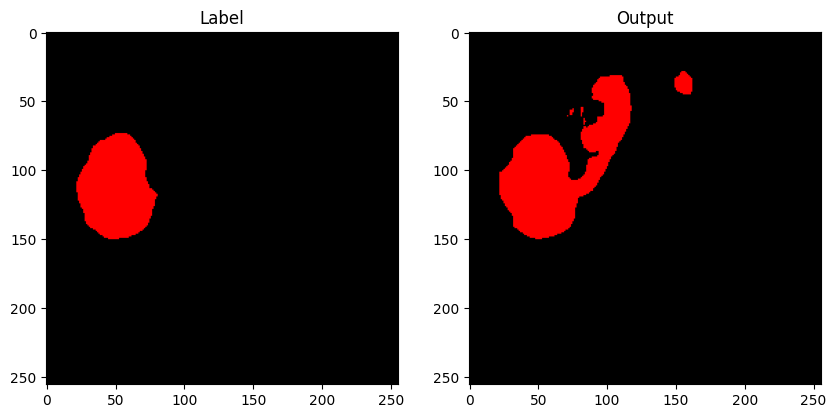

Epoch [48/200], Loss: 0.0972232521


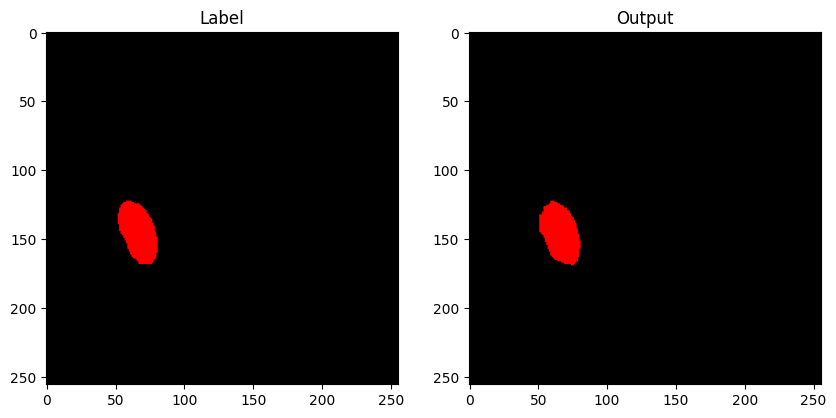

Epoch [49/200], Loss: 0.0846552775


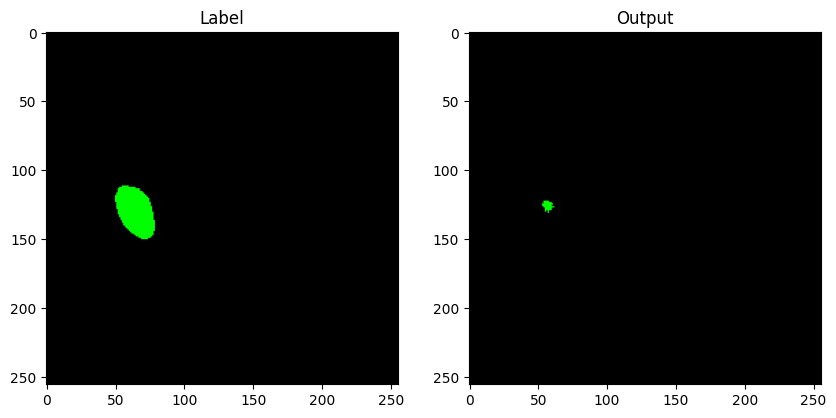

Epoch [50/200], Loss: 0.0883603557


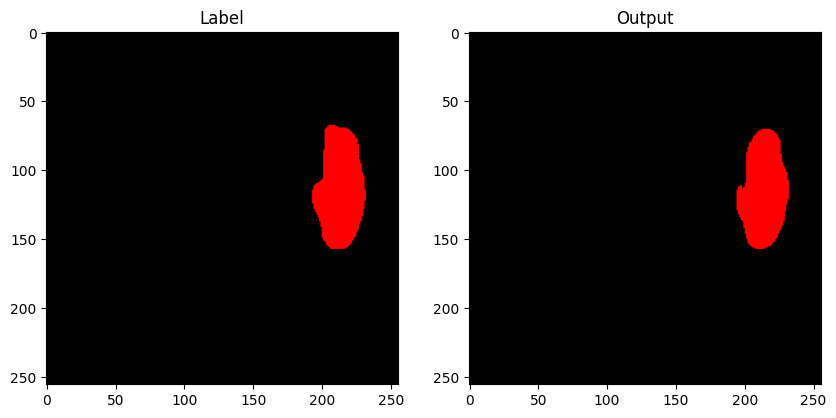

Epoch [51/200], Loss: 0.0949453787


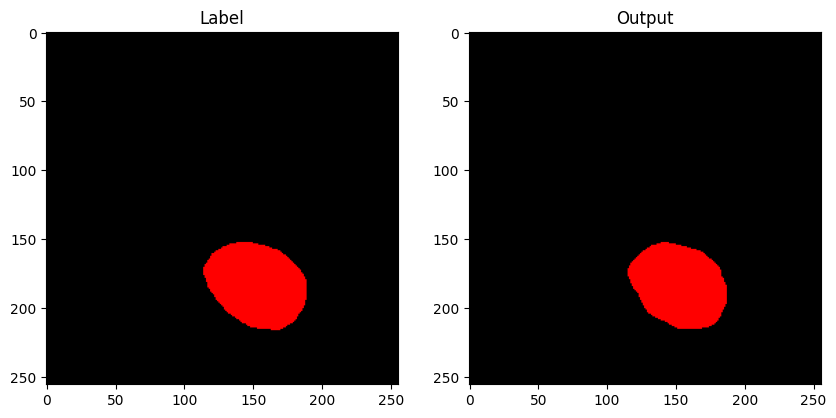

Epoch [52/200], Loss: 0.1010554996


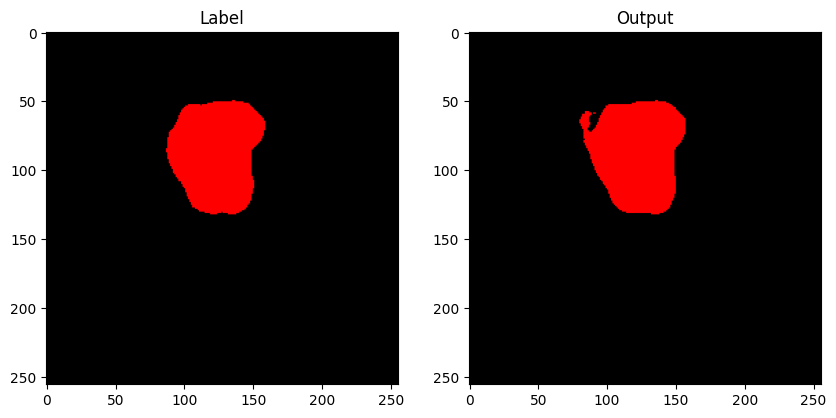

Epoch [53/200], Loss: 0.0963461664


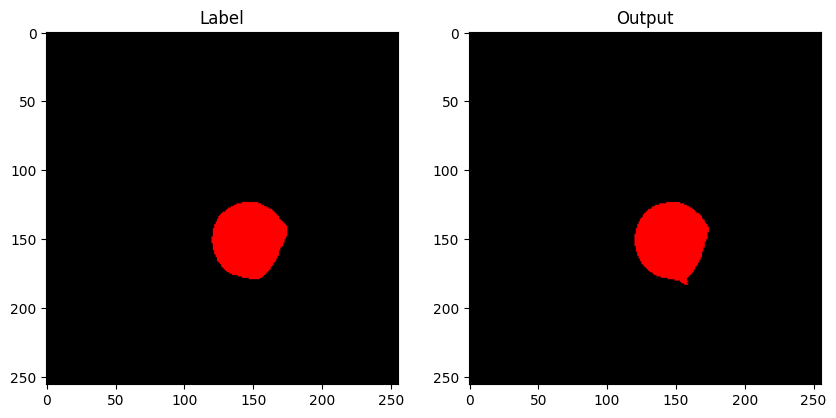

Epoch [54/200], Loss: 0.0989839356


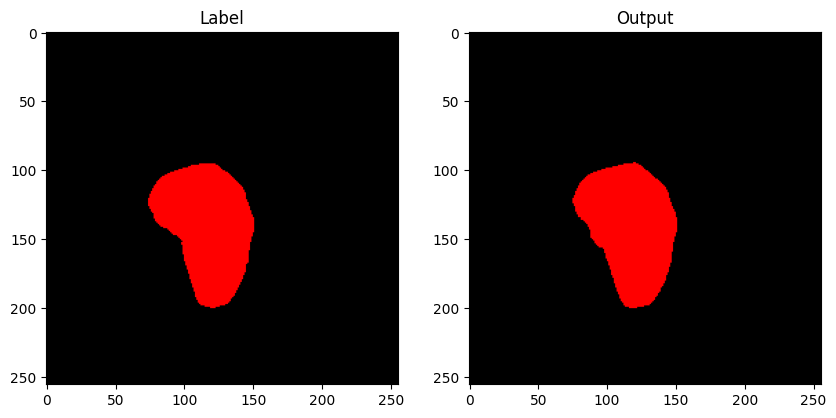

Epoch [55/200], Loss: 0.0995091782


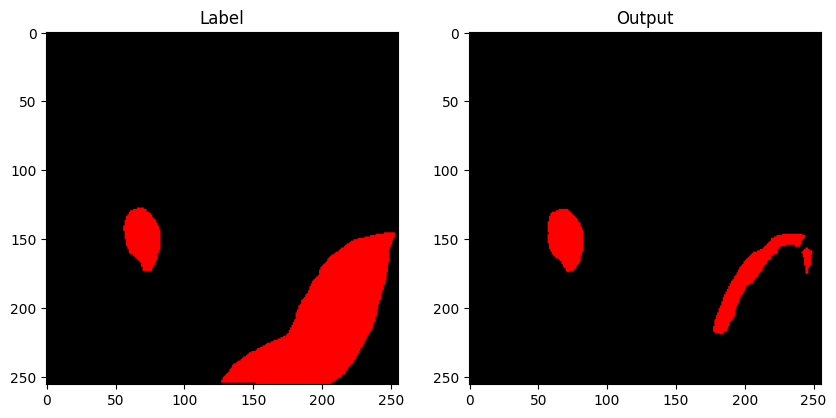

Epoch [56/200], Loss: 0.1004470822


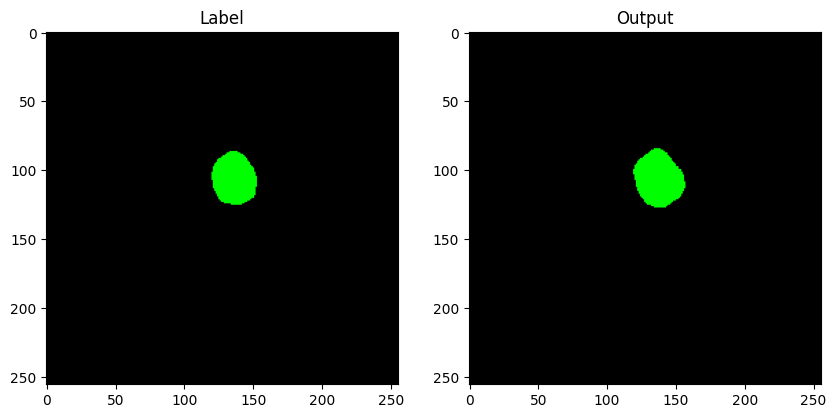

Epoch [57/200], Loss: 0.1061570252


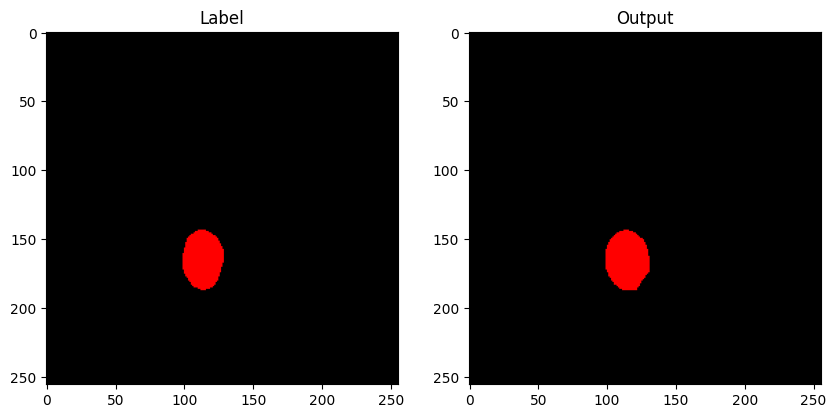

Epoch [58/200], Loss: 0.0890020579


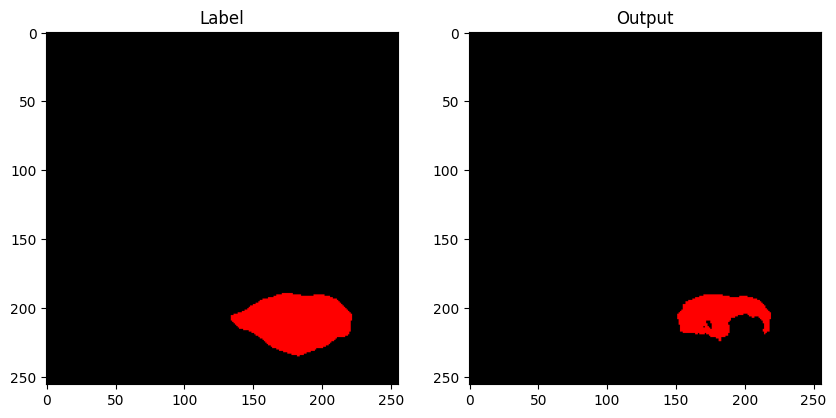

Epoch [59/200], Loss: 0.0927908580


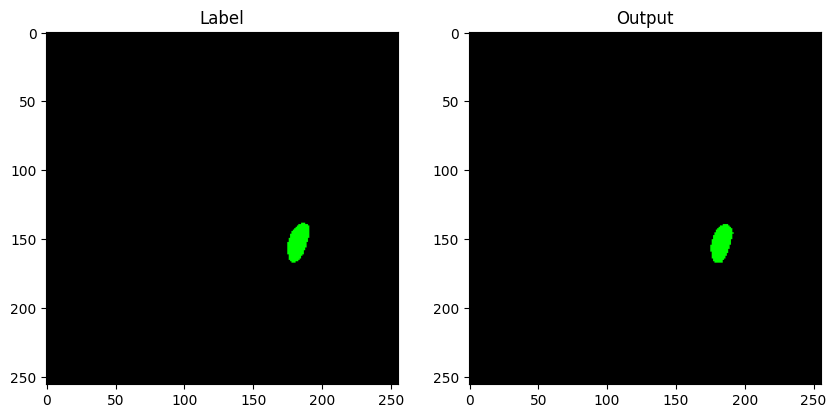

Epoch [60/200], Loss: 0.0937429423


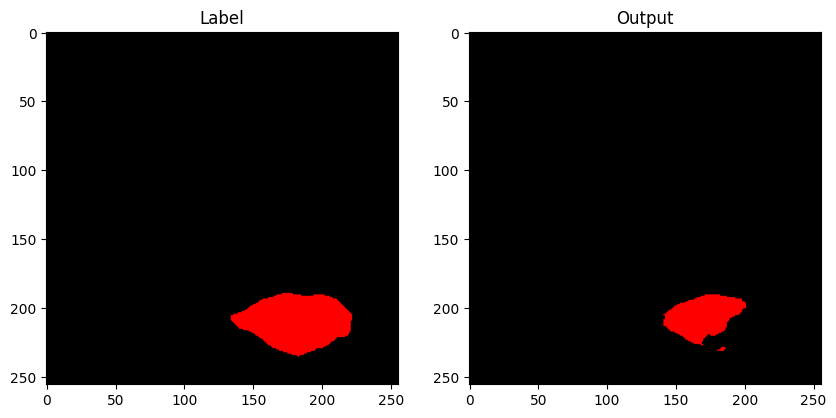

Epoch [61/200], Loss: 0.0977136242


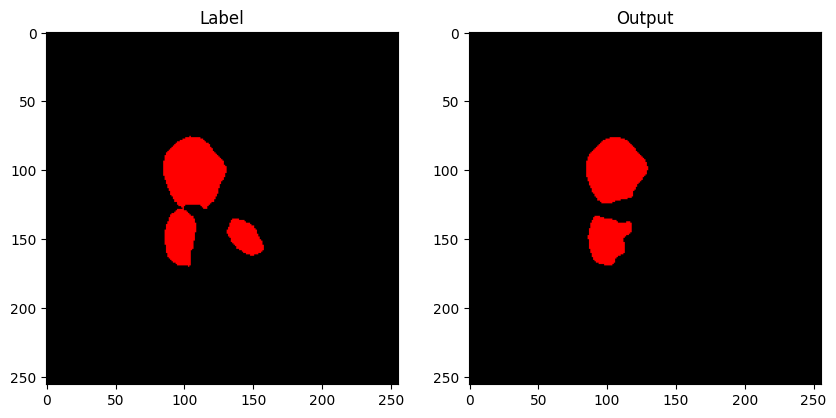

Epoch [62/200], Loss: 0.0899080413


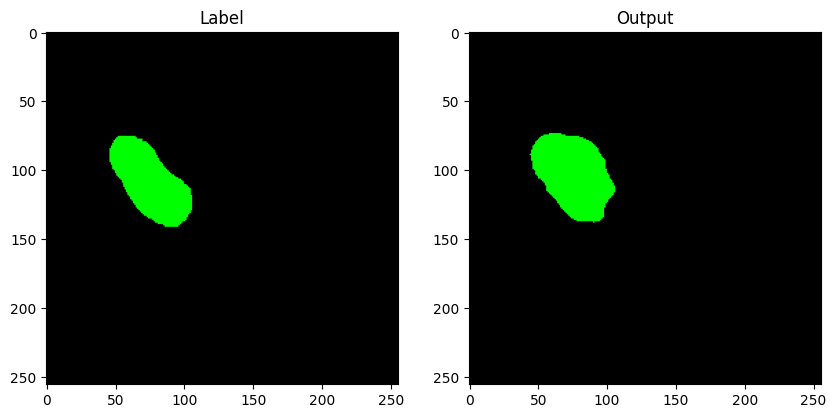

Epoch [63/200], Loss: 0.0900665702


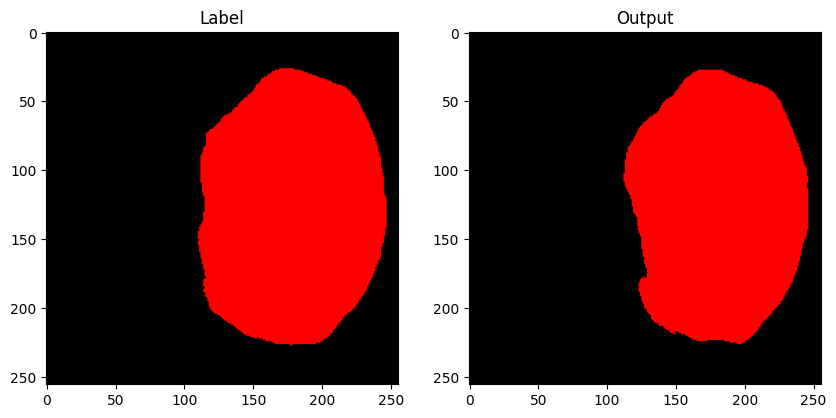

Epoch [64/200], Loss: 0.0943013332


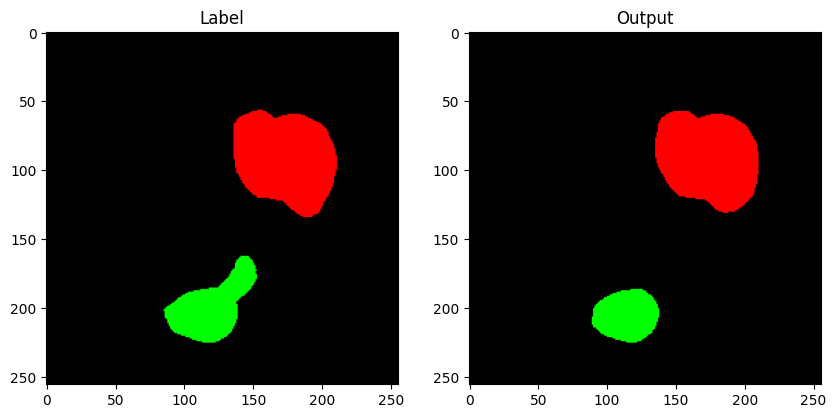

Epoch [65/200], Loss: 0.0958324690


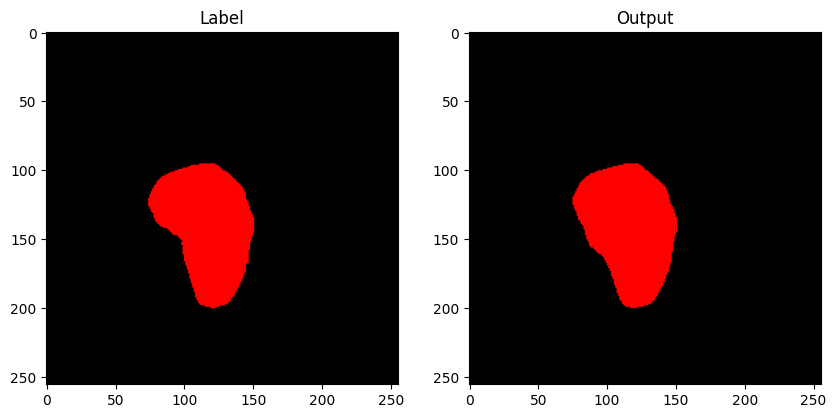

Epoch [66/200], Loss: 0.1048054035


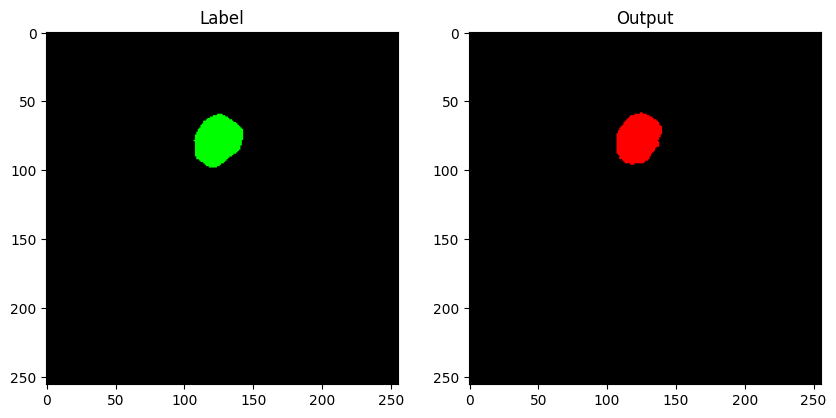

Epoch [67/200], Loss: 0.0900988228


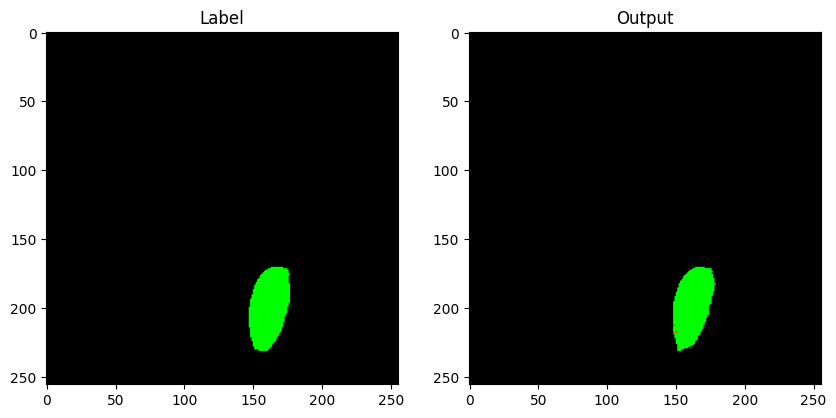

Epoch [68/200], Loss: 0.0983506845


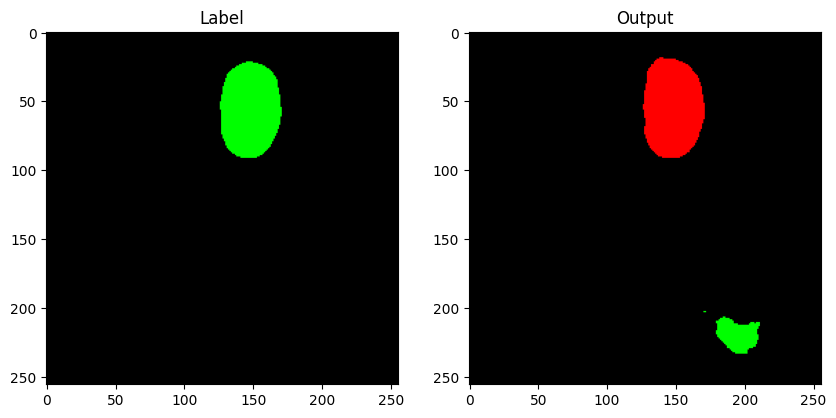

Epoch [69/200], Loss: 0.0964445614


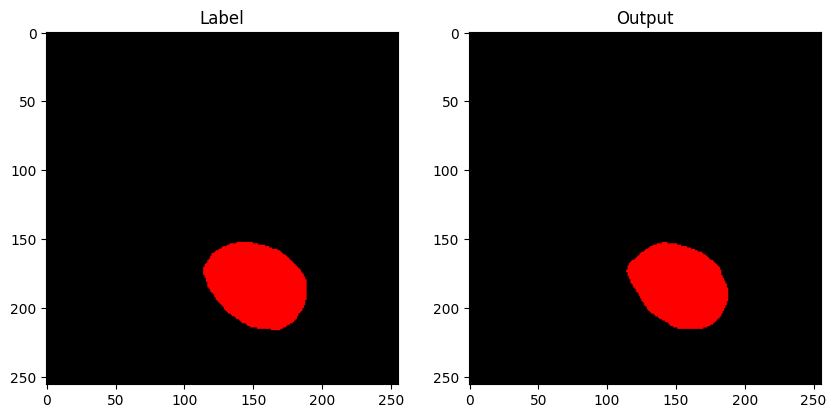

Epoch [70/200], Loss: 0.1094766298


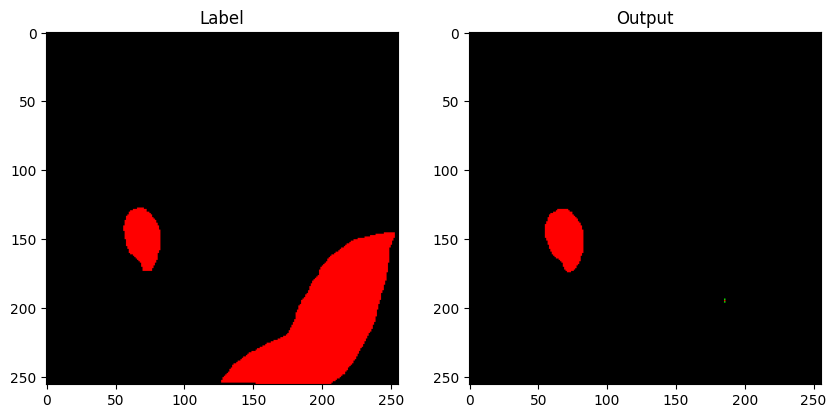

Epoch [71/200], Loss: 0.0980769010


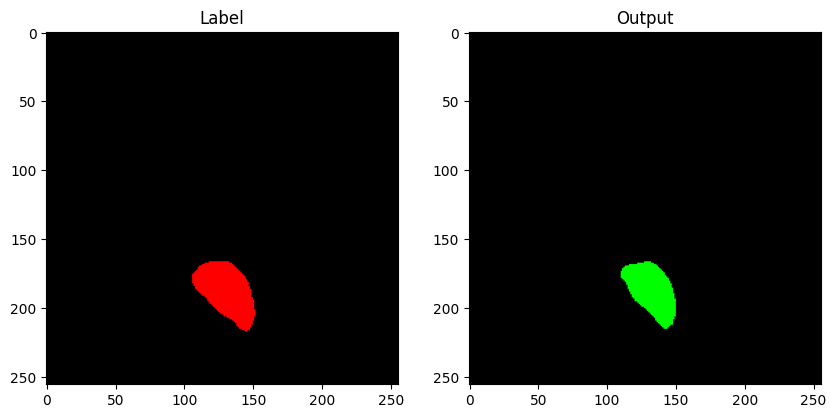

Epoch [72/200], Loss: 0.1184981345


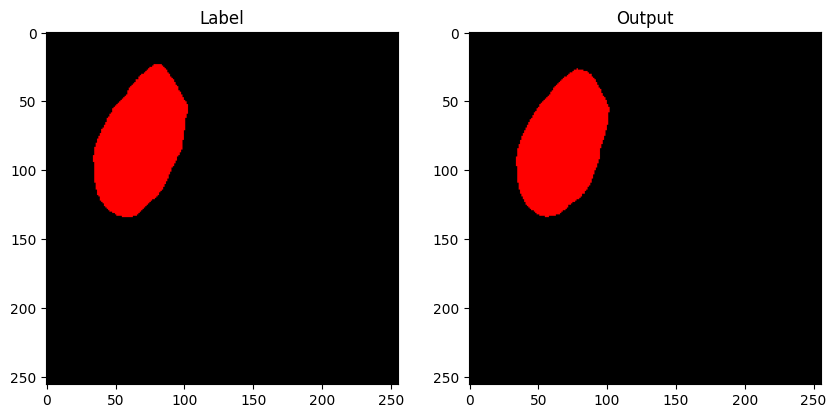

Epoch [73/200], Loss: 0.0996592195


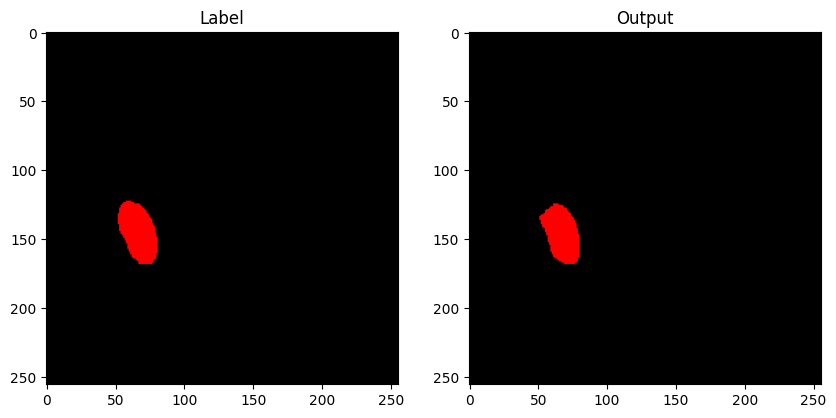

Epoch [74/200], Loss: 0.1119575893


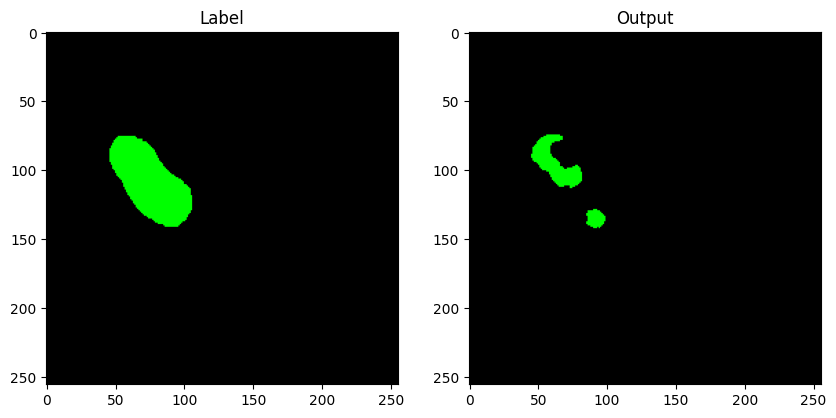

Epoch [75/200], Loss: 0.1113887647


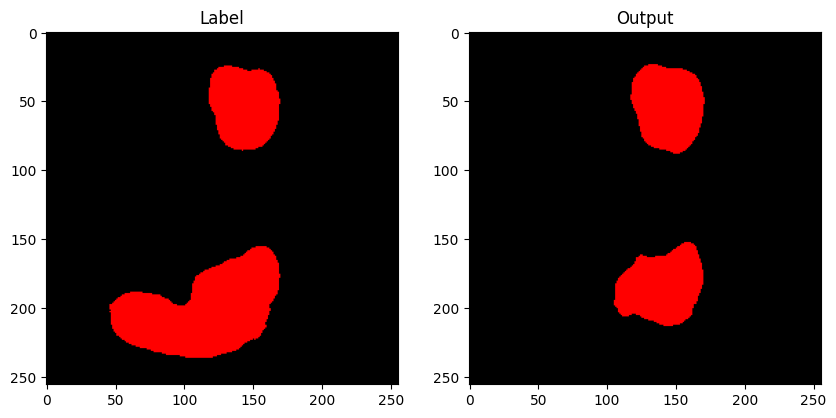

Epoch [76/200], Loss: 0.0979846818


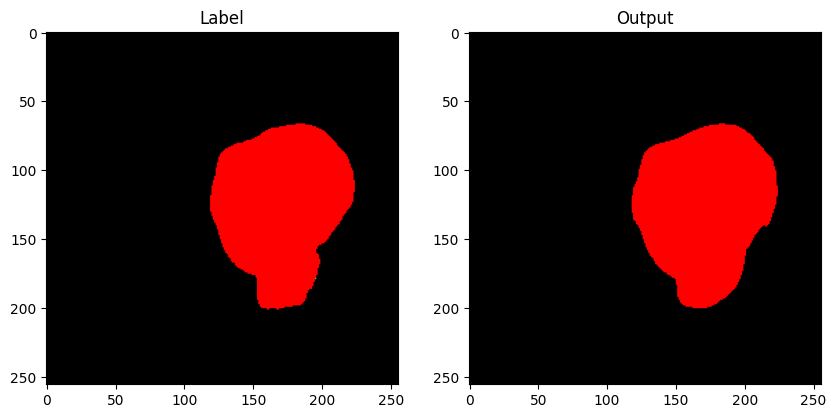

Epoch [77/200], Loss: 0.1185219328


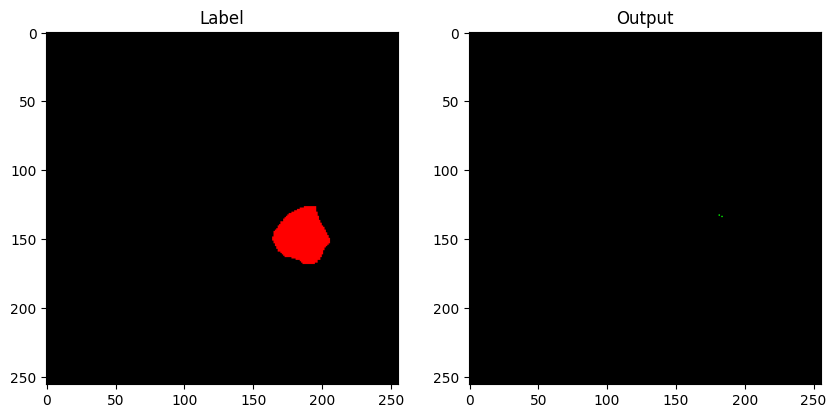

Epoch [78/200], Loss: 0.1250157424


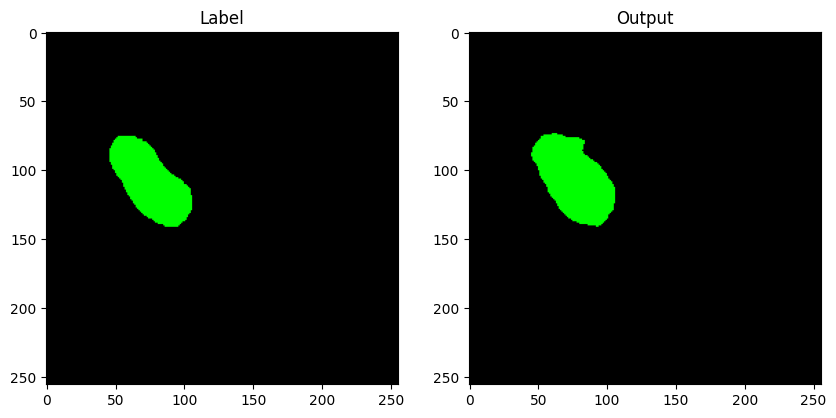

Epoch [79/200], Loss: 0.1262536206


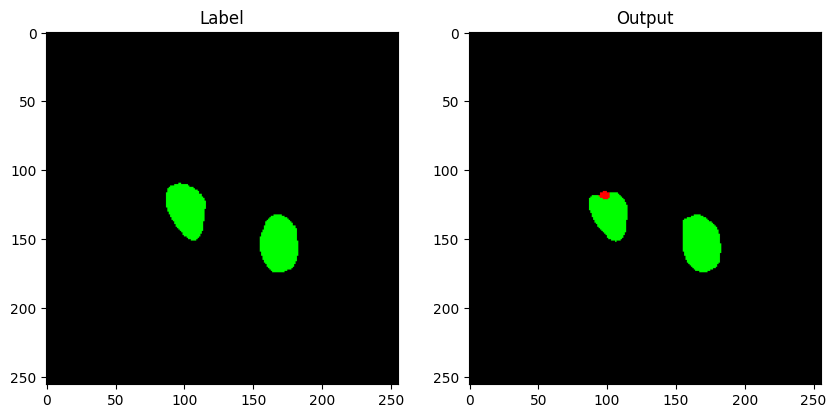

Epoch [80/200], Loss: 0.1243764990


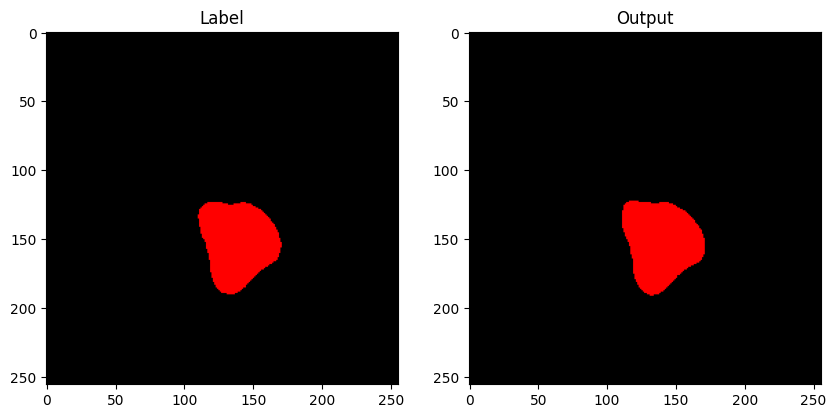

Epoch [81/200], Loss: 0.1289795015


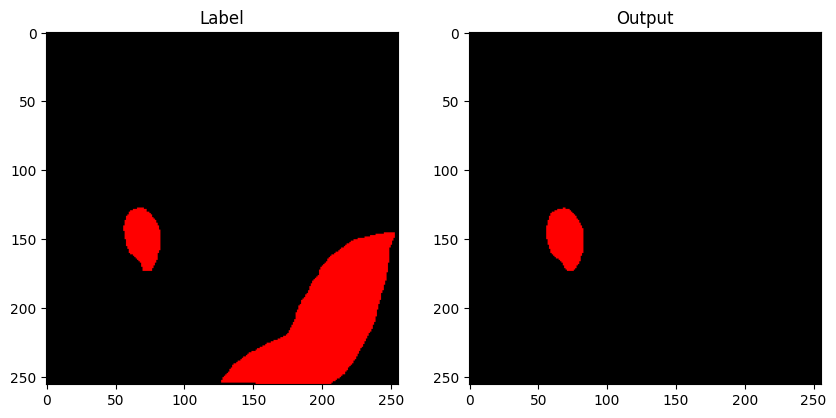

Epoch [82/200], Loss: 0.1295940556


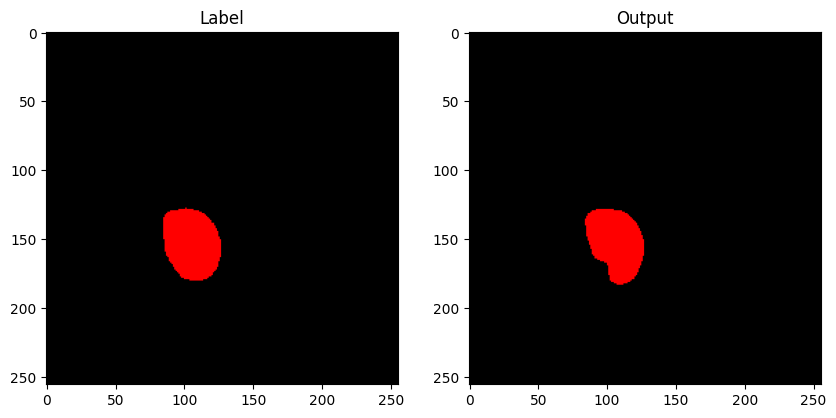

Epoch [83/200], Loss: 0.1266470572


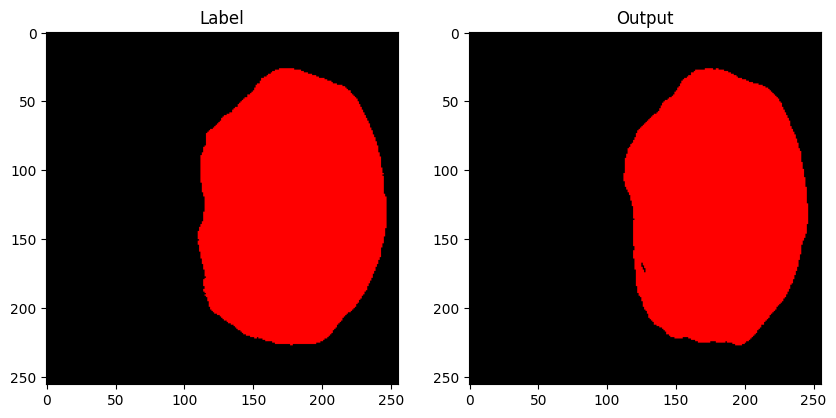

Epoch [84/200], Loss: 0.1225412109


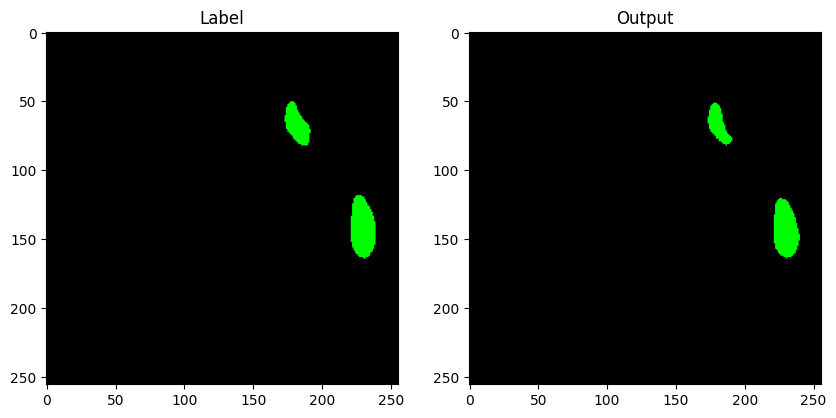

Epoch [85/200], Loss: 0.1351260649


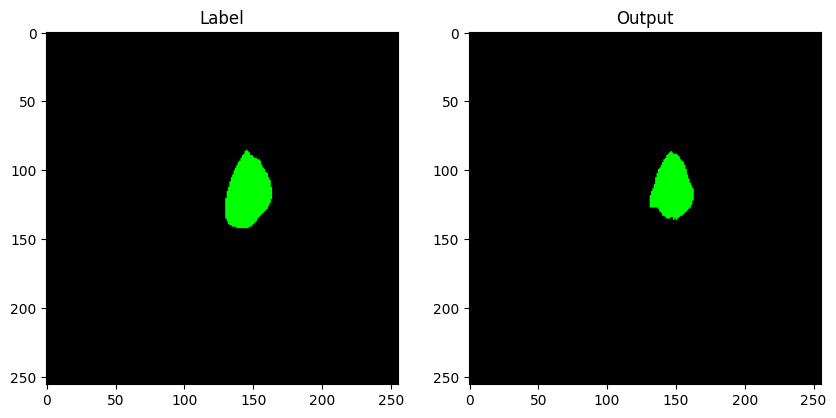

Epoch [86/200], Loss: 0.1322614169


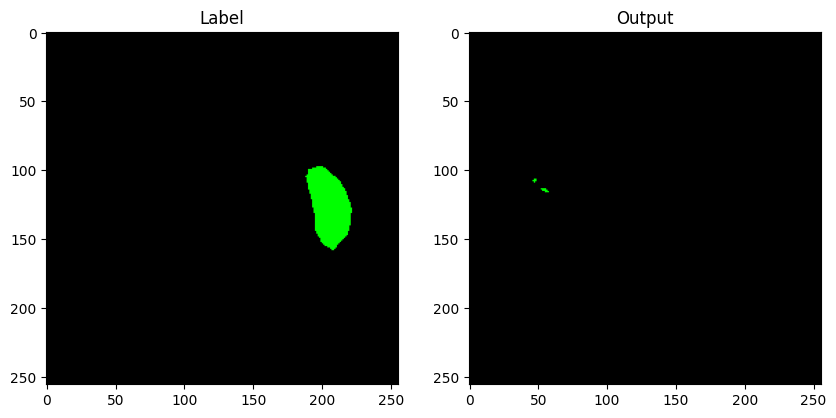

Epoch [87/200], Loss: 0.1142576871


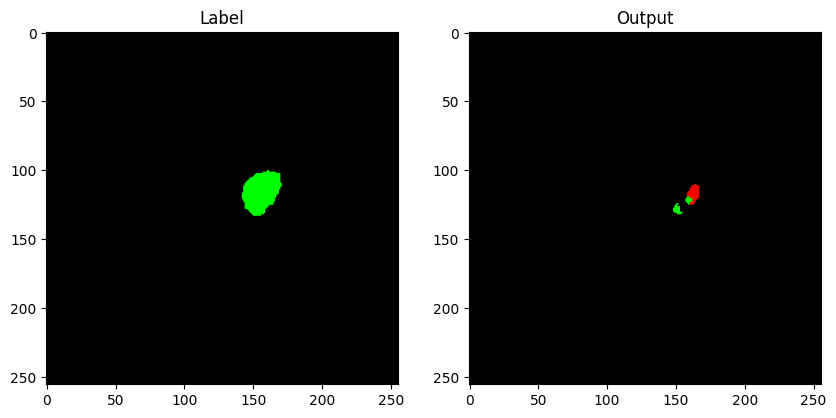

Epoch [88/200], Loss: 0.1158259204


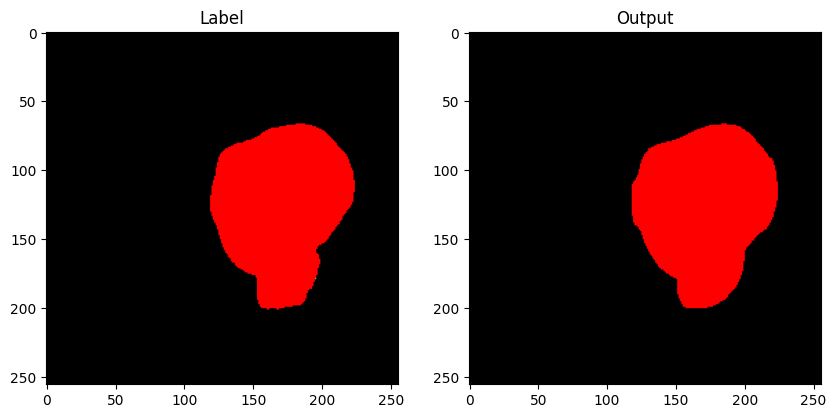

Epoch [89/200], Loss: 0.1285347255


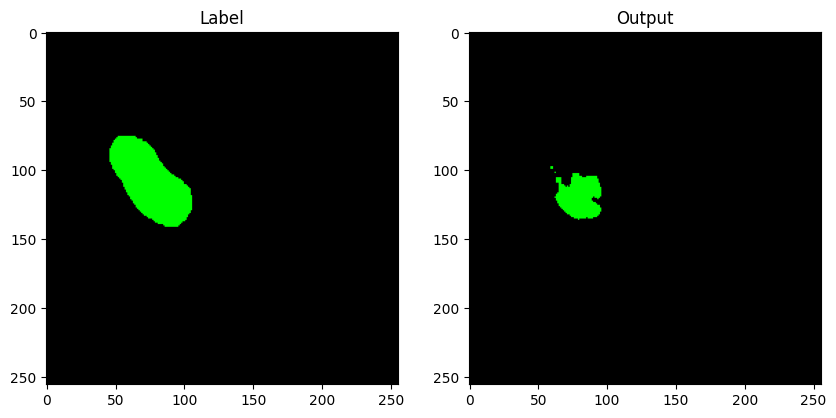

Epoch [90/200], Loss: 0.1490022543


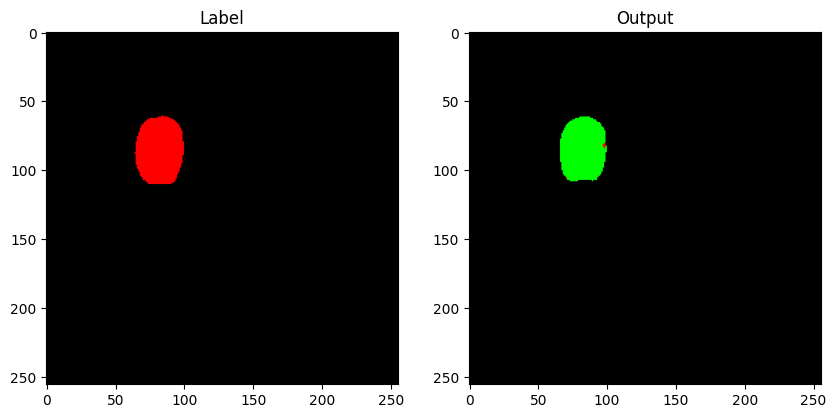

Epoch [91/200], Loss: 0.1172485489


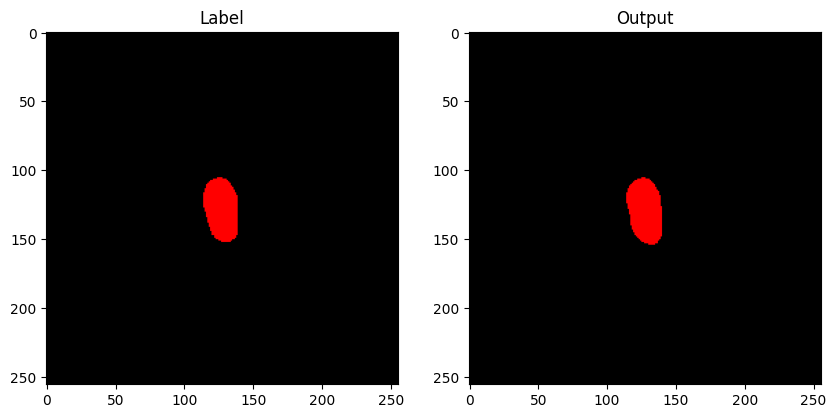

Epoch [92/200], Loss: 0.1629622504


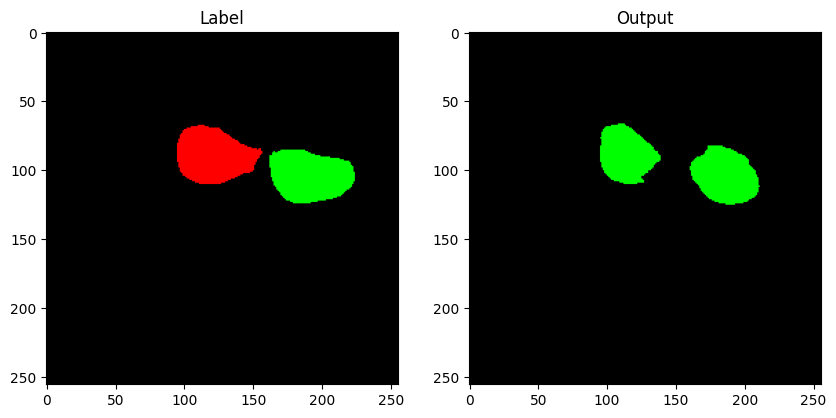

Epoch [93/200], Loss: 0.1008836772


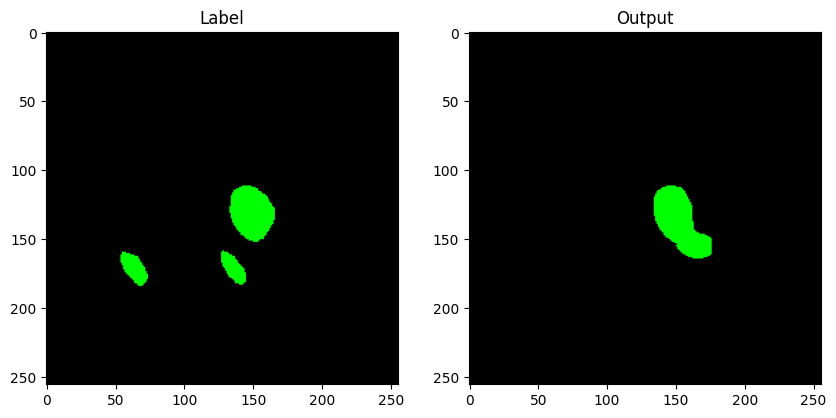

Epoch [94/200], Loss: 0.1093565905


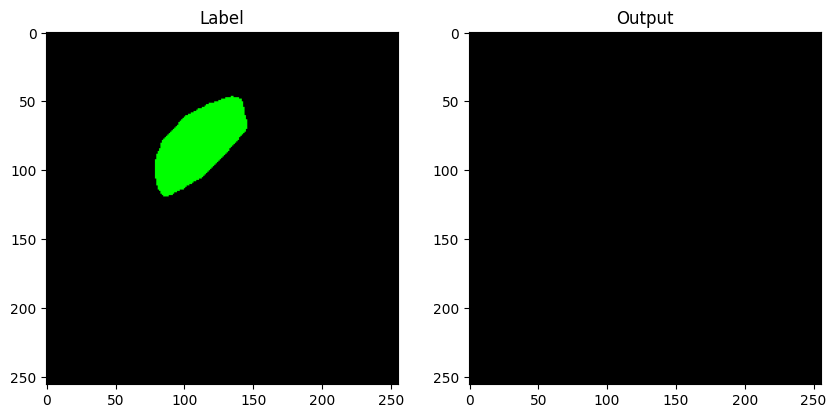

Epoch [95/200], Loss: 0.1009643743


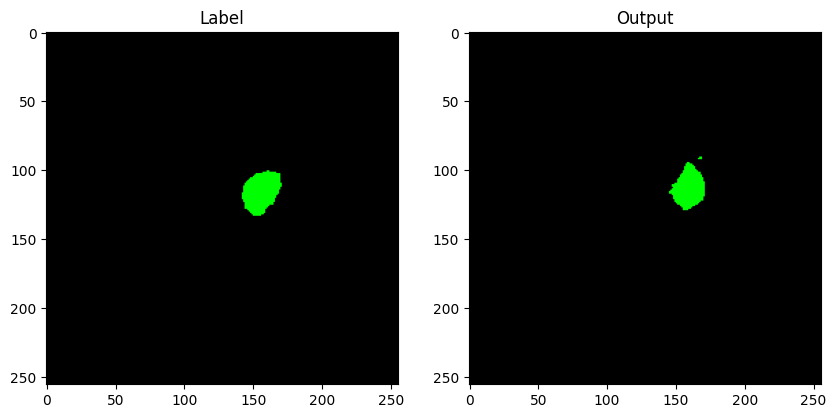

Epoch [96/200], Loss: 0.1122214748


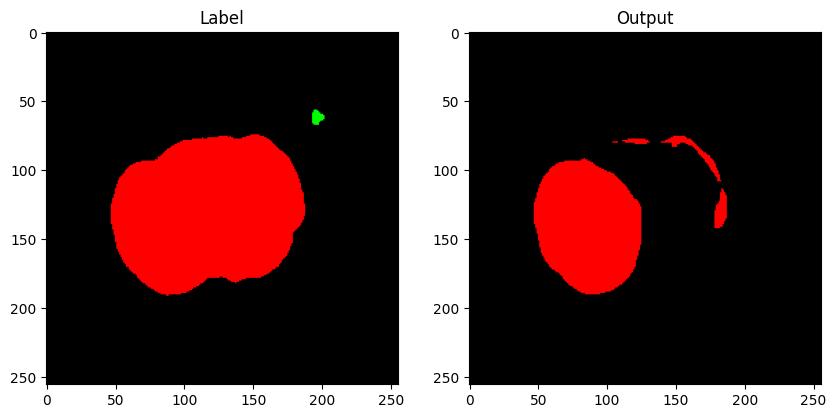

Epoch [97/200], Loss: 0.1227864457


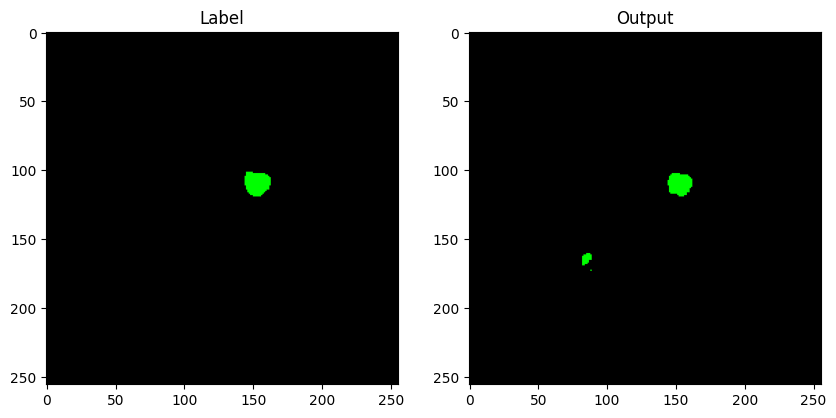

Epoch [98/200], Loss: 0.1170337760


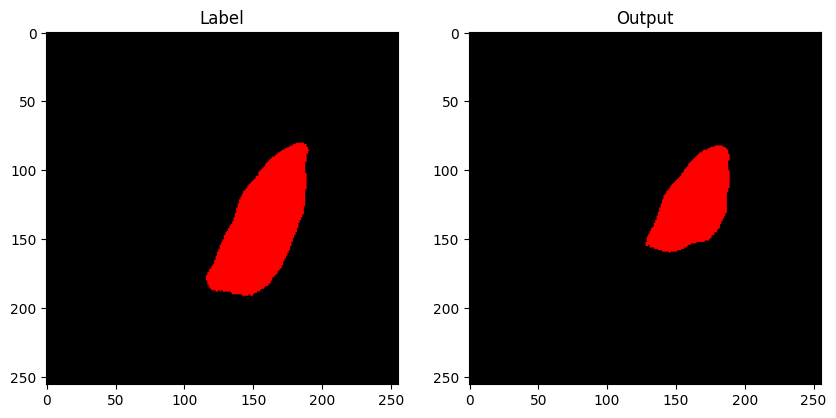

Epoch [99/200], Loss: 0.1152836135


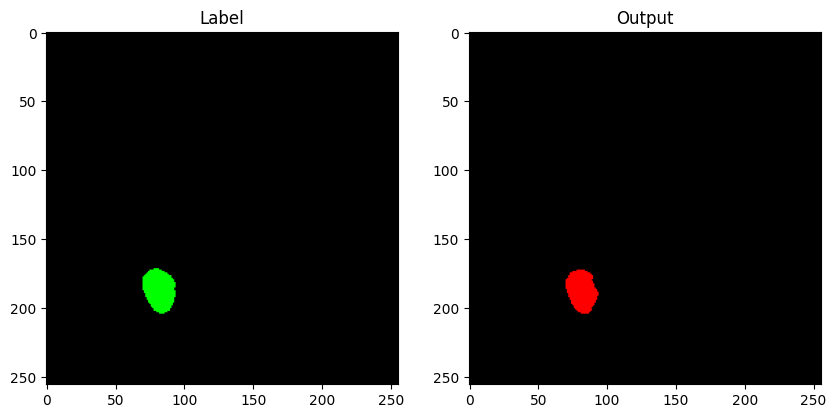

Epoch [100/200], Loss: 0.1424185066


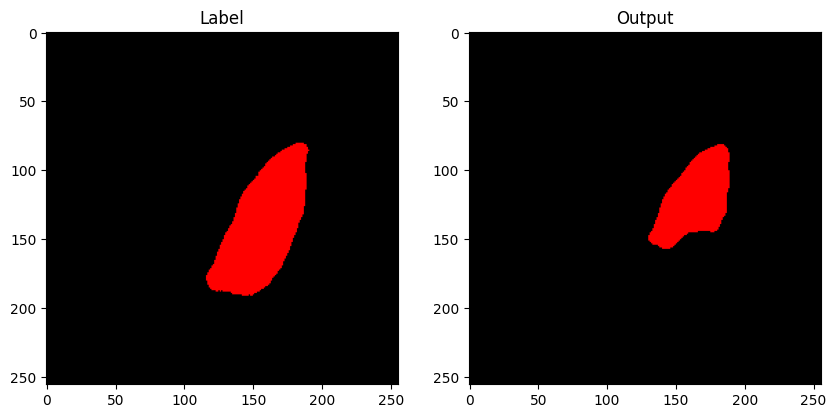

Epoch [101/200], Loss: 0.1262126538


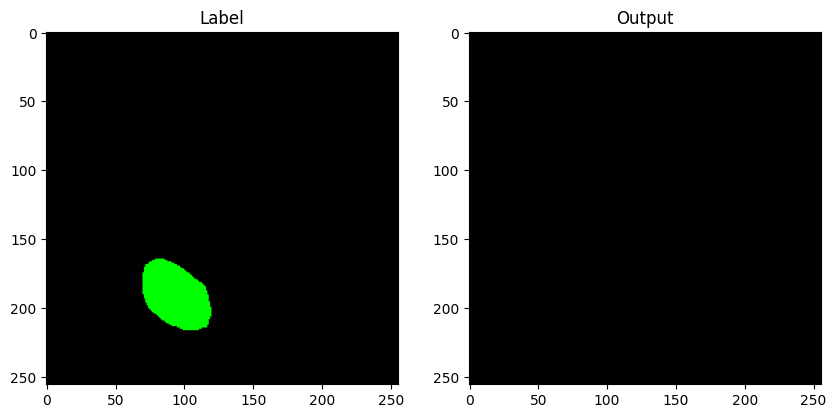

Epoch [102/200], Loss: 0.1211659557


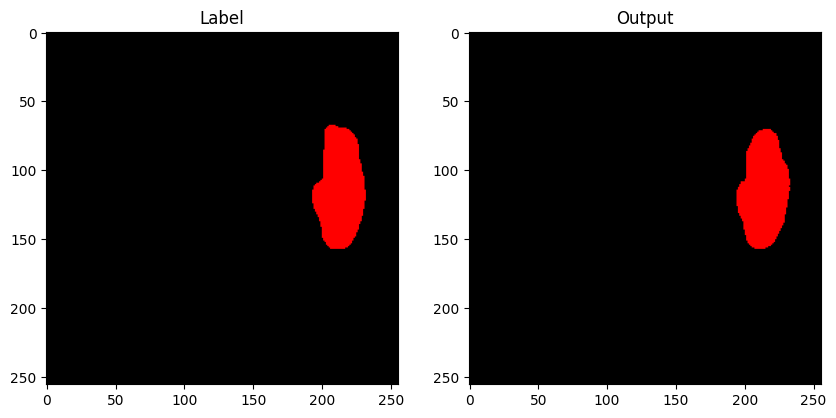

Epoch [103/200], Loss: 0.1249602913


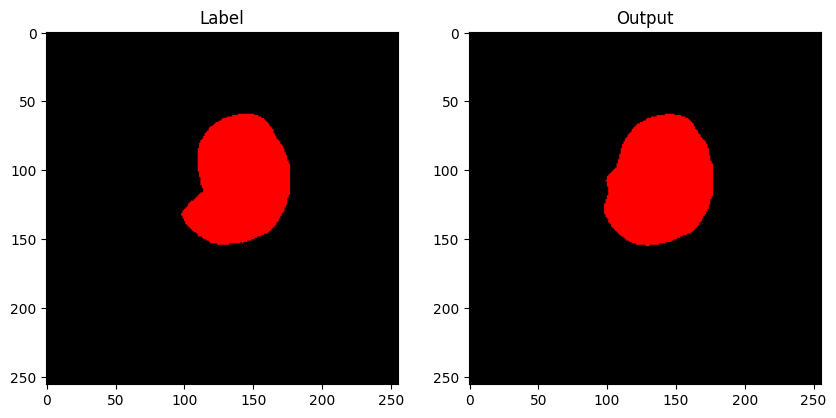

Epoch [104/200], Loss: 0.1132958289


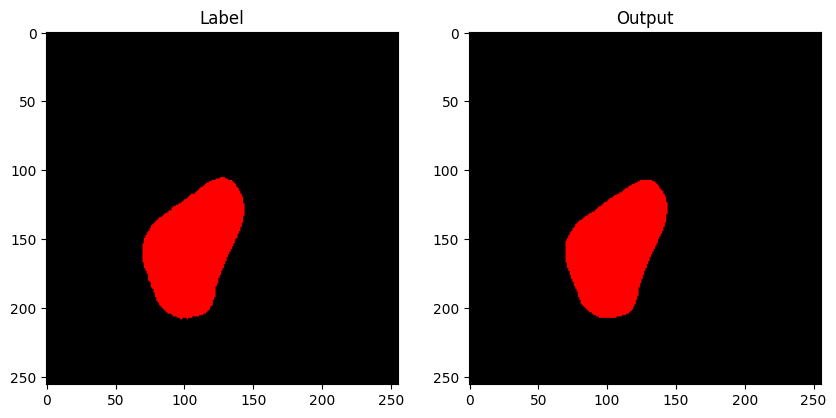

Epoch [105/200], Loss: 0.1313069198


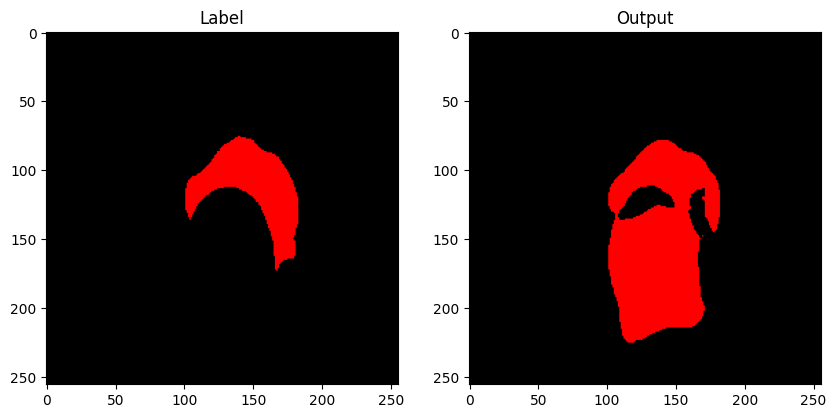

Epoch [106/200], Loss: 0.1203415617


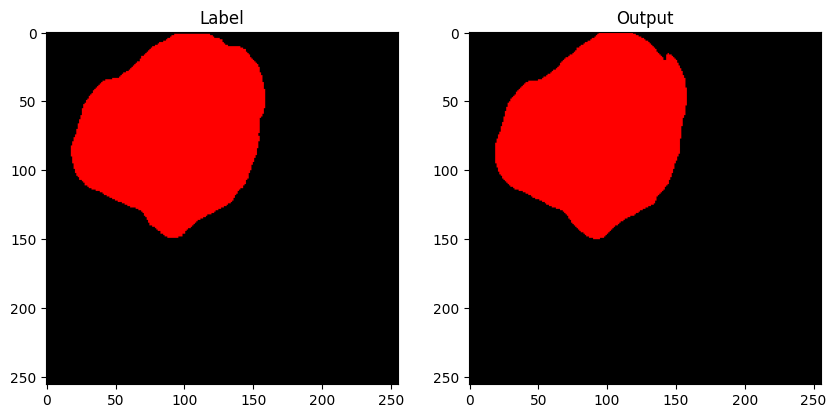

Epoch [107/200], Loss: 0.1187199764


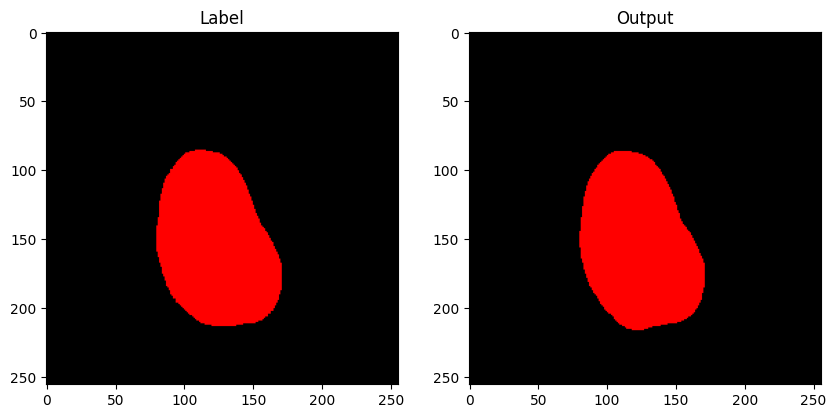

Epoch [108/200], Loss: 0.1196067290


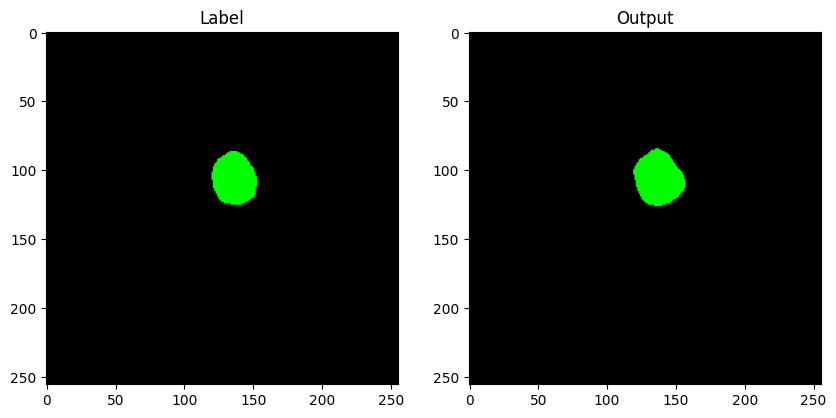

Epoch [109/200], Loss: 0.1235332107


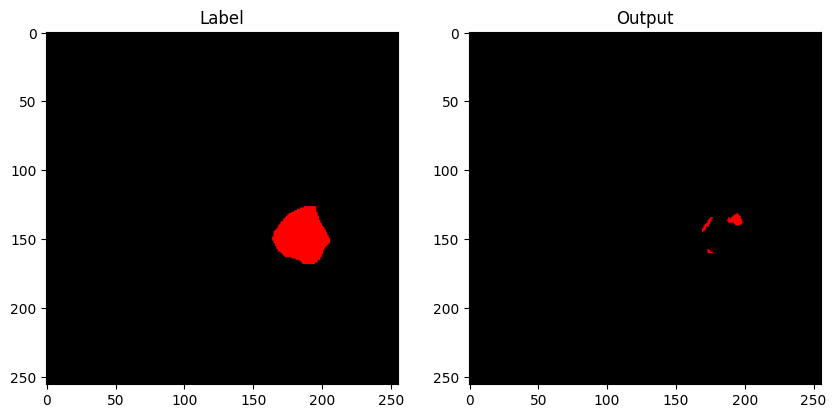

Epoch [110/200], Loss: 0.1216453769


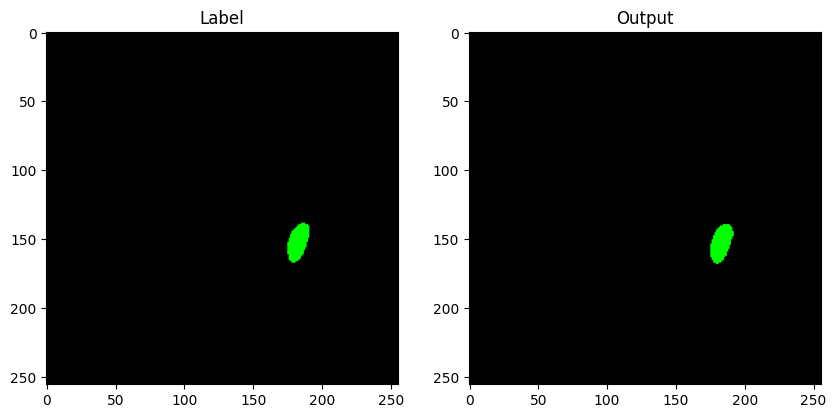

Epoch [111/200], Loss: 0.1126443351


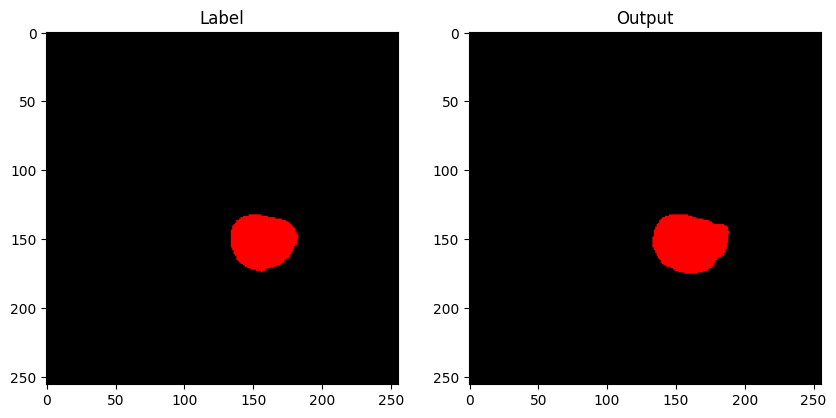

Epoch [112/200], Loss: 0.1251629118


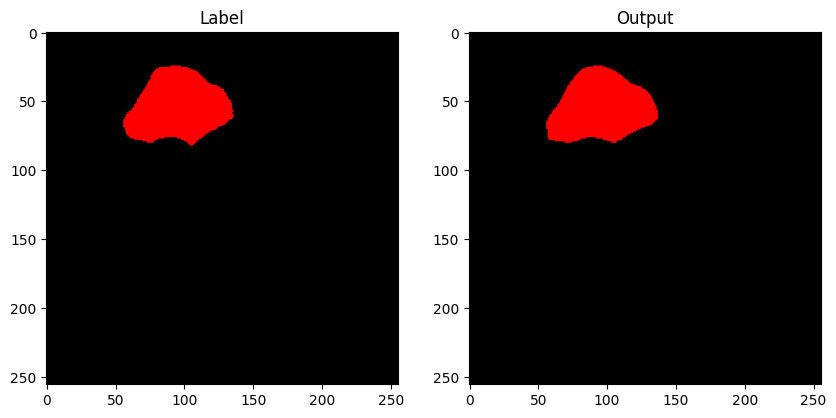

Epoch [113/200], Loss: 0.1226422816


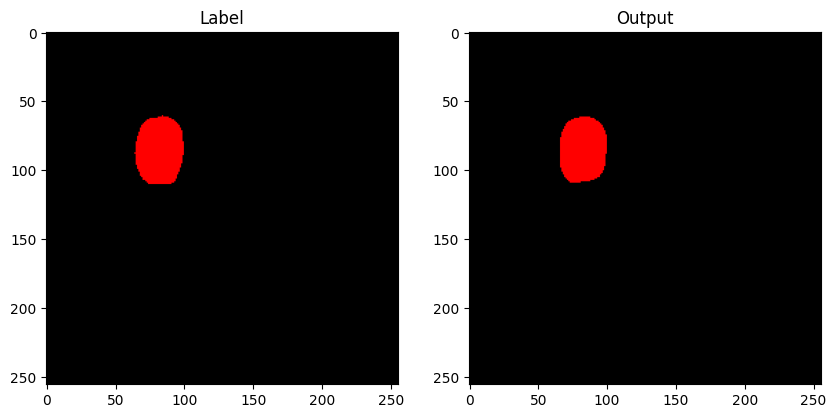

Epoch [114/200], Loss: 0.1164672692


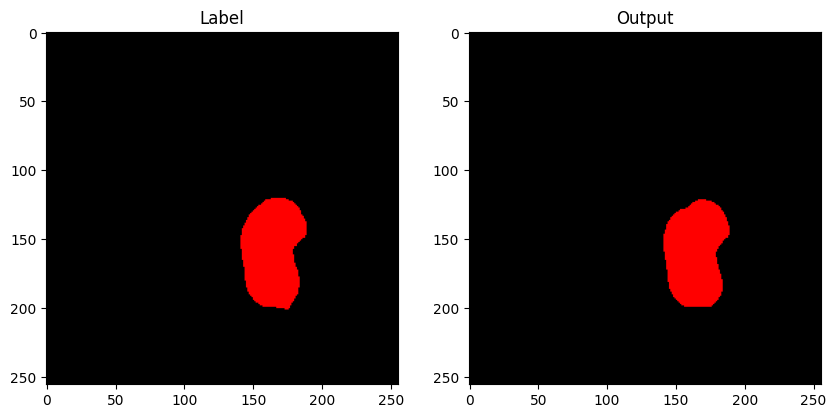

Epoch [115/200], Loss: 0.1211013652


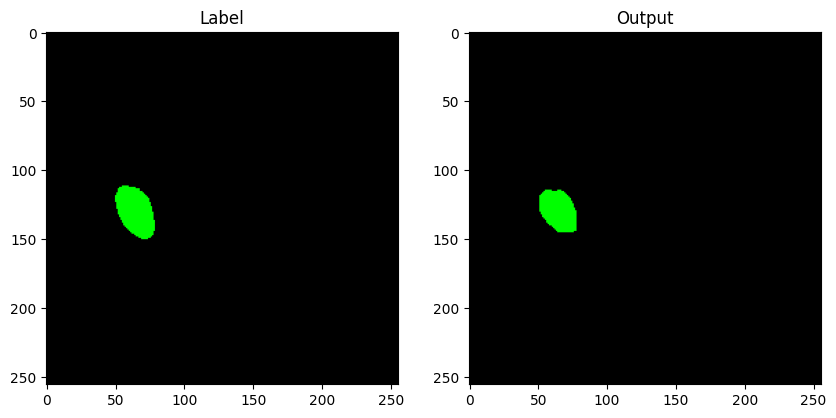

Epoch [116/200], Loss: 0.1281171682


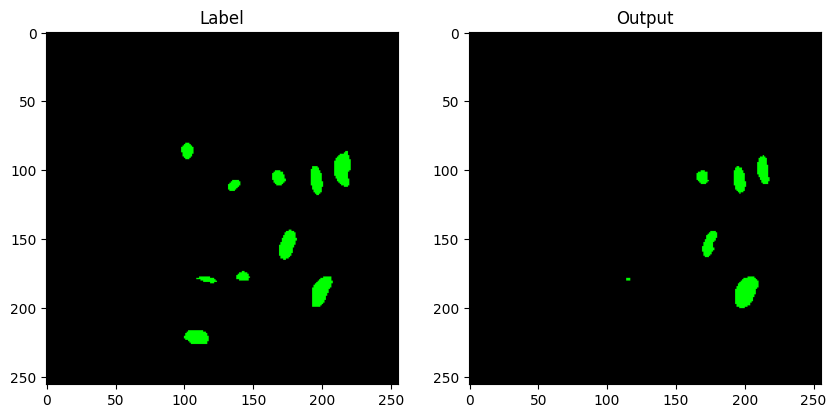

Epoch [117/200], Loss: 0.1515008864


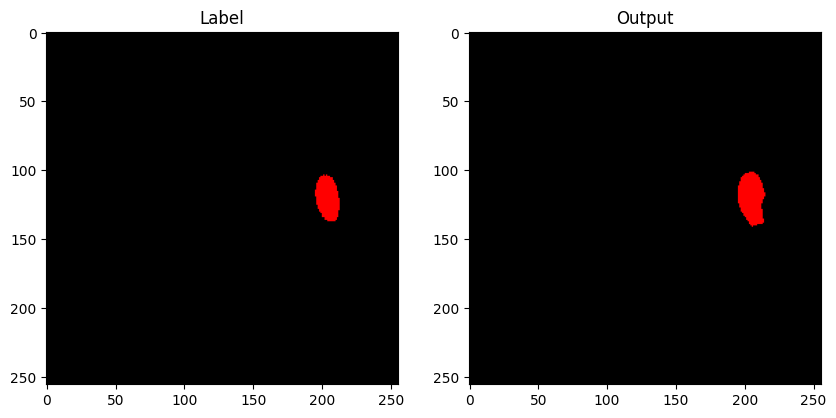

Epoch [118/200], Loss: 0.1131281149


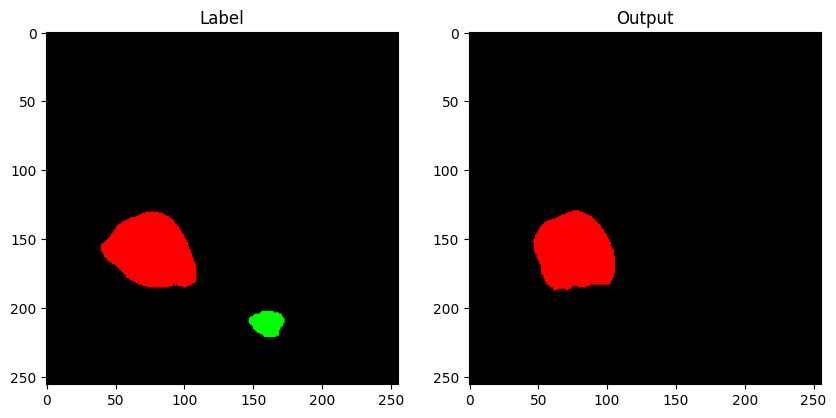

Epoch [119/200], Loss: 0.1169616115


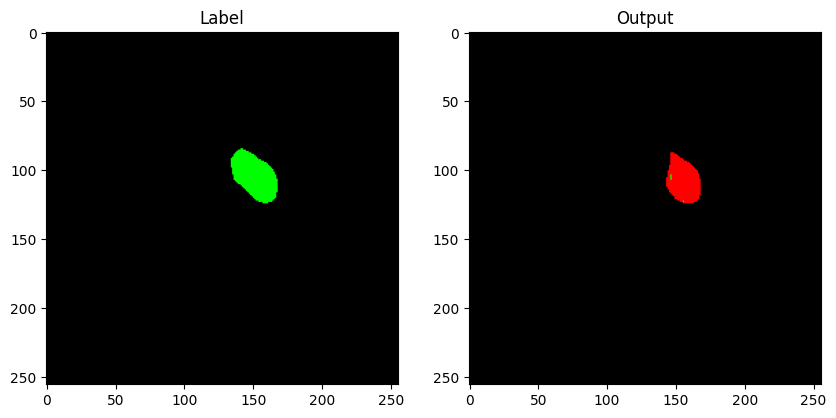

Epoch [120/200], Loss: 0.1212213375


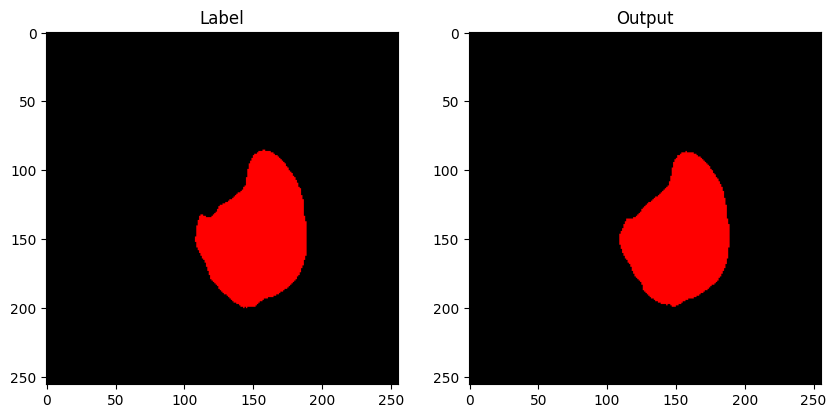

Epoch [121/200], Loss: 0.1177217232


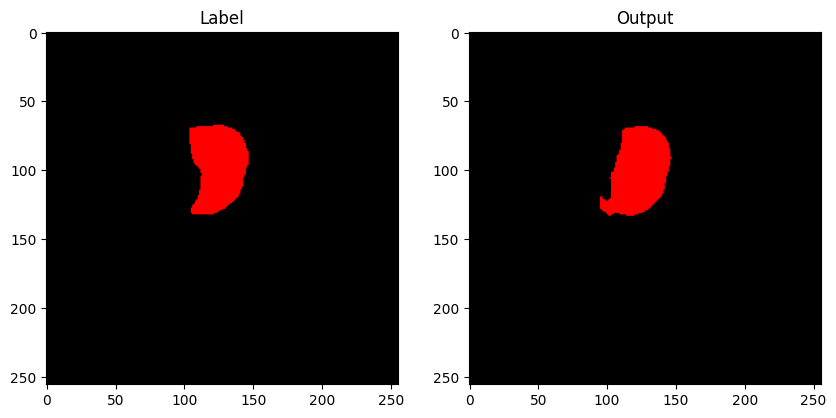

Epoch [122/200], Loss: 0.1082147771


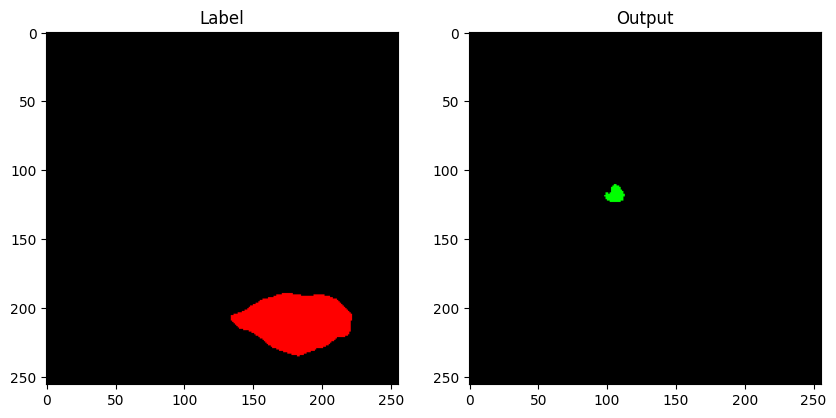

Epoch [123/200], Loss: 0.1010055263


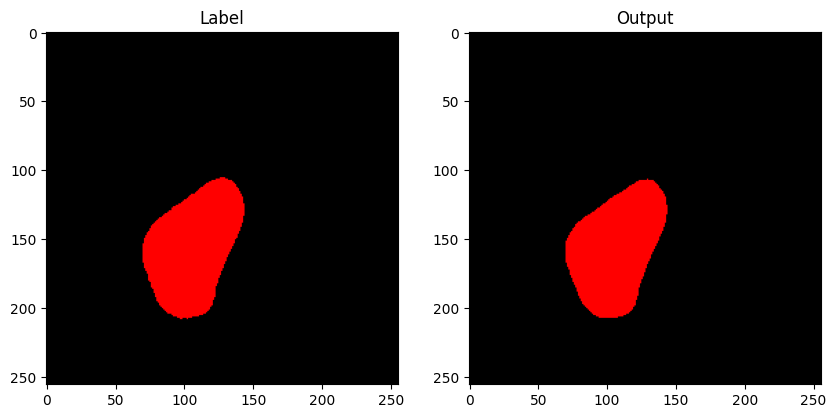

Epoch [124/200], Loss: 0.1468665975


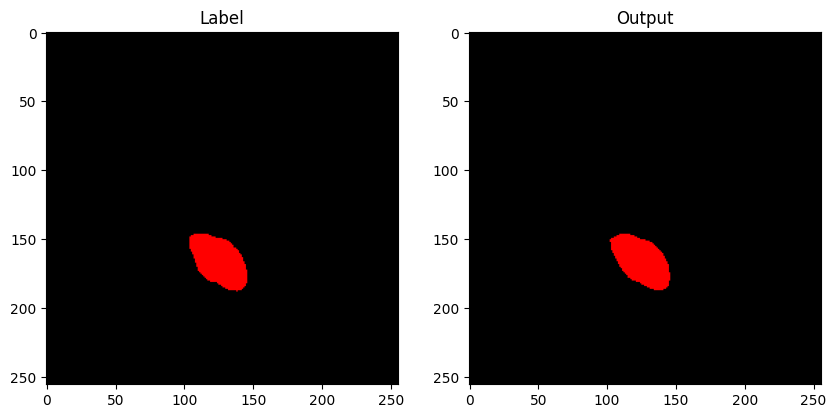

Epoch [125/200], Loss: 0.1351368473


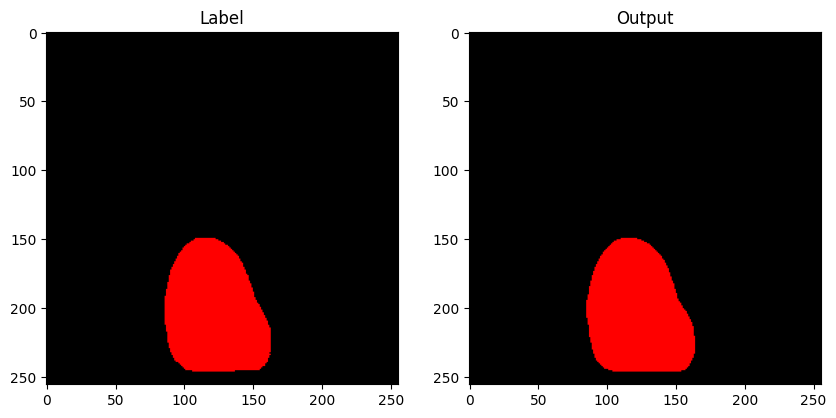

Epoch [126/200], Loss: 0.1739482140


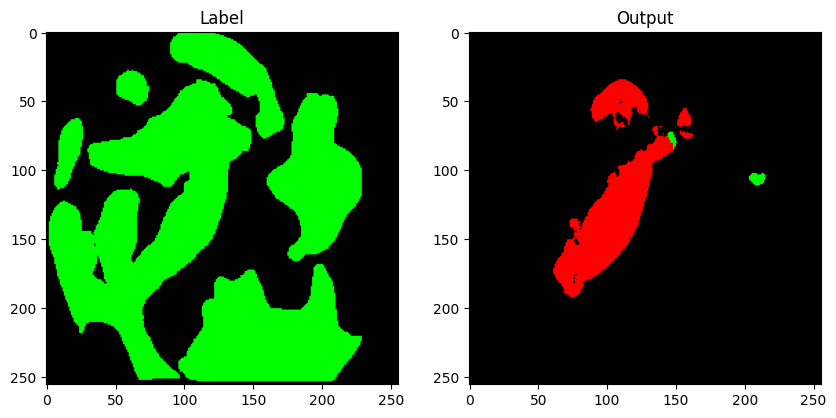

Epoch [127/200], Loss: 0.1439782645


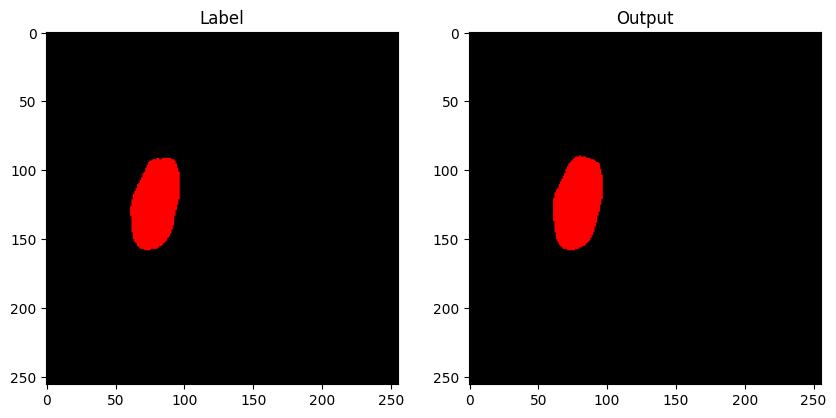

Epoch [128/200], Loss: 0.1441750369


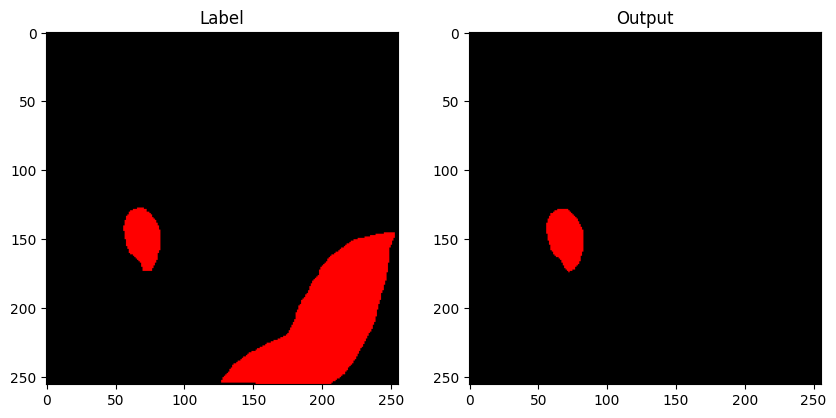

Epoch [129/200], Loss: 0.1337622245


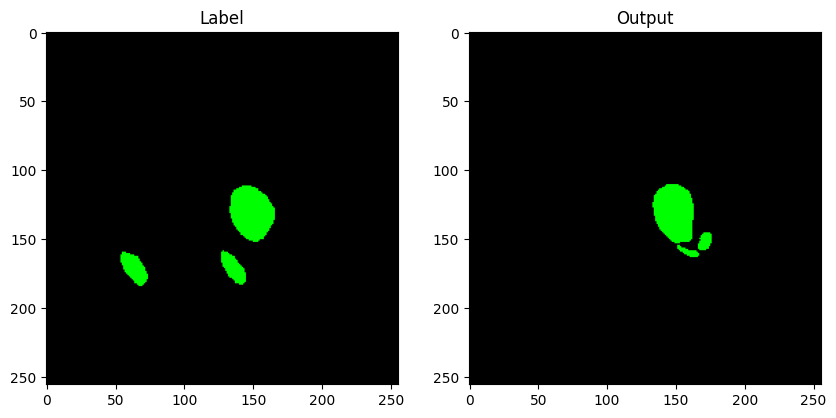

Epoch [130/200], Loss: 0.1534680564


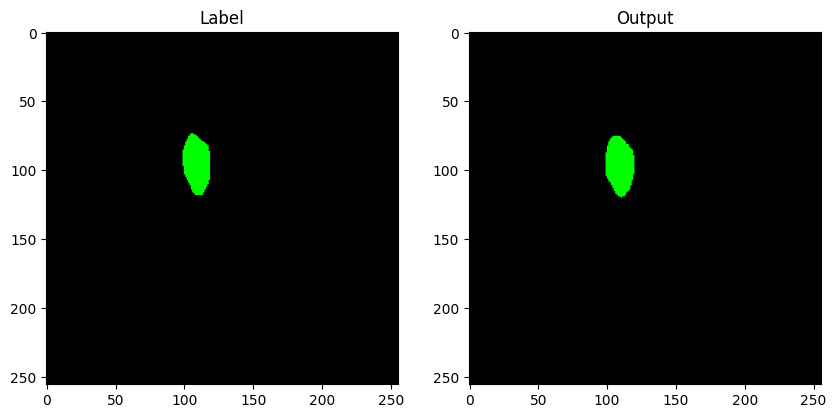

Epoch [131/200], Loss: 0.1370631944


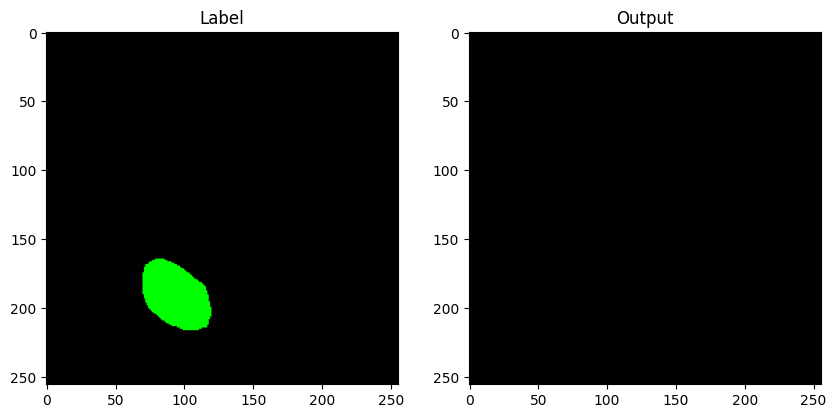

Epoch [132/200], Loss: 0.1317385673


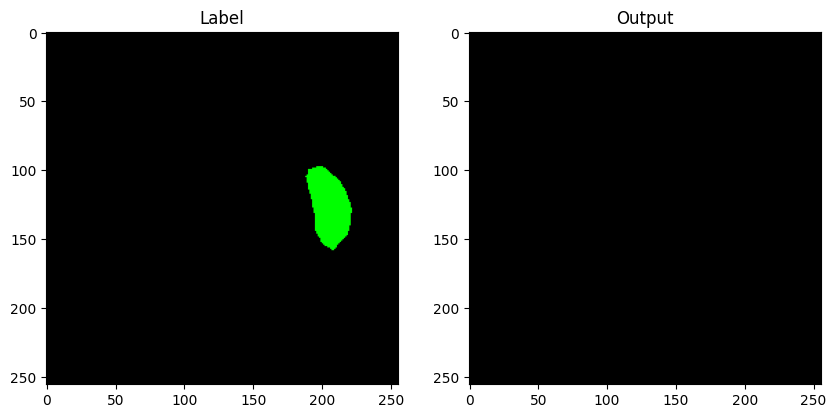

Epoch [133/200], Loss: 0.1350393780


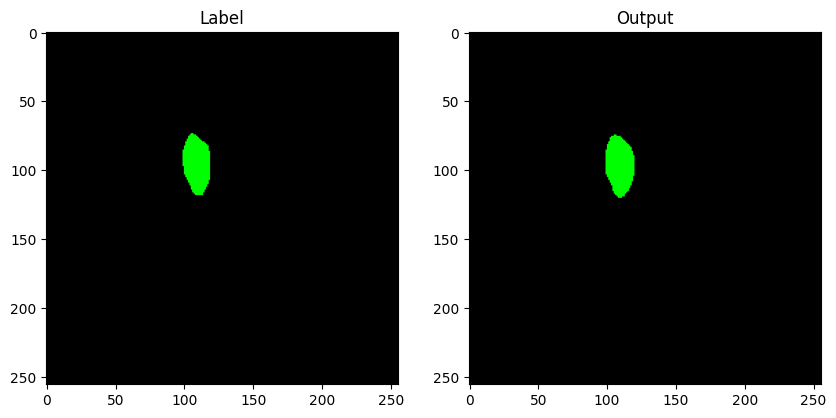

Epoch [134/200], Loss: 0.1381344447


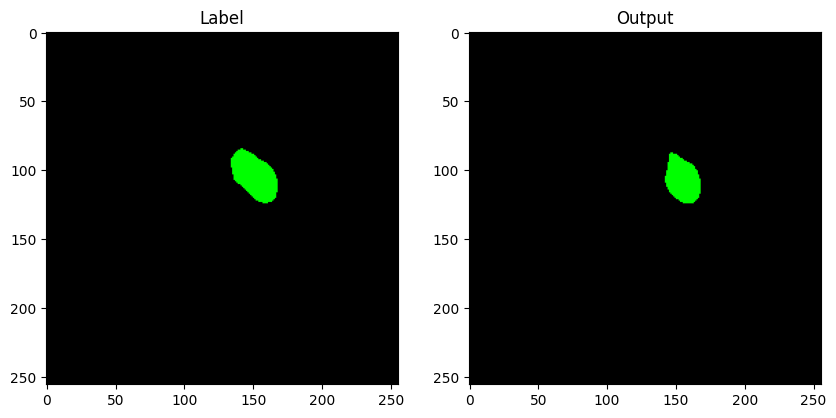

Epoch [135/200], Loss: 0.1401569564


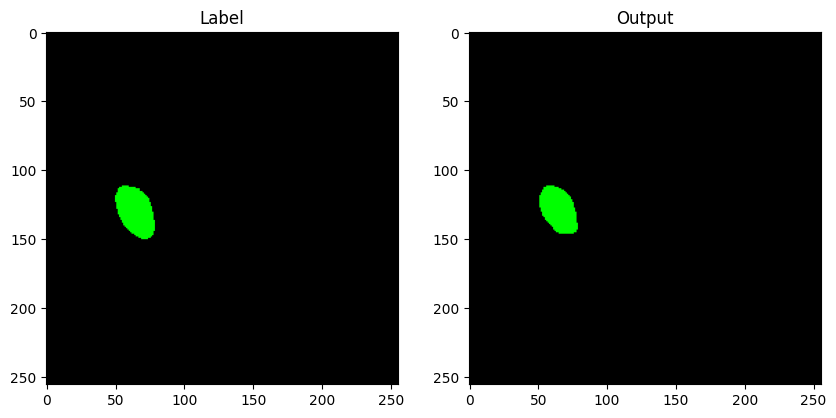

Epoch [136/200], Loss: 0.1398207134


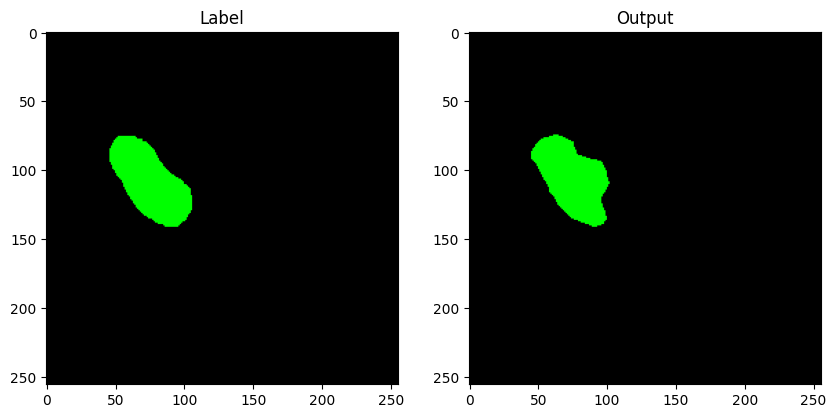

Epoch [137/200], Loss: 0.1427895242


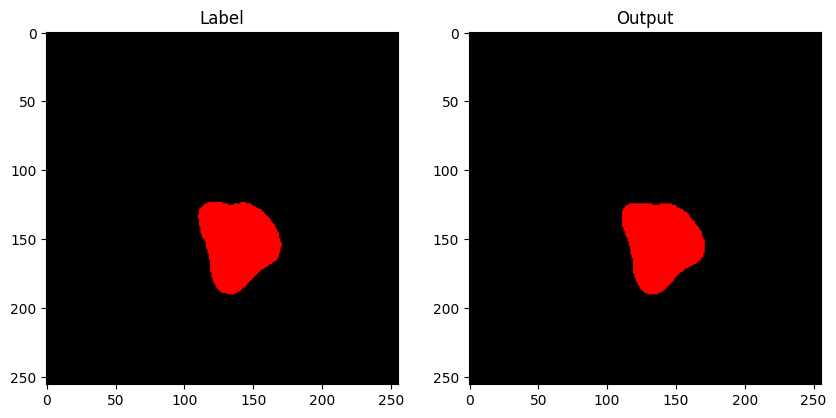

Epoch [138/200], Loss: 0.1420704851


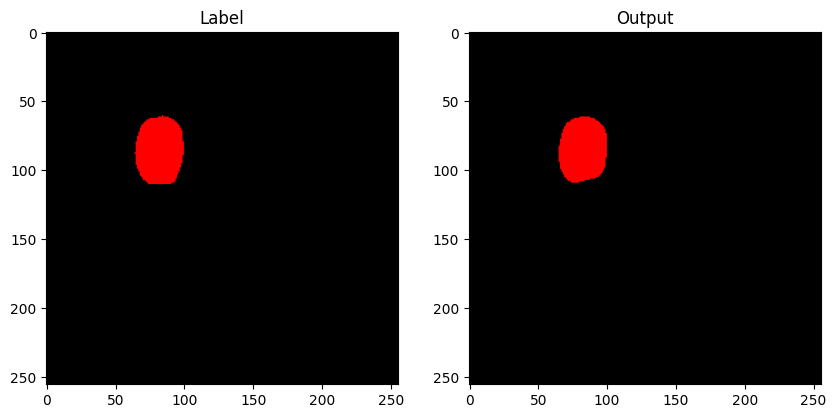

Epoch [139/200], Loss: 0.1373818515


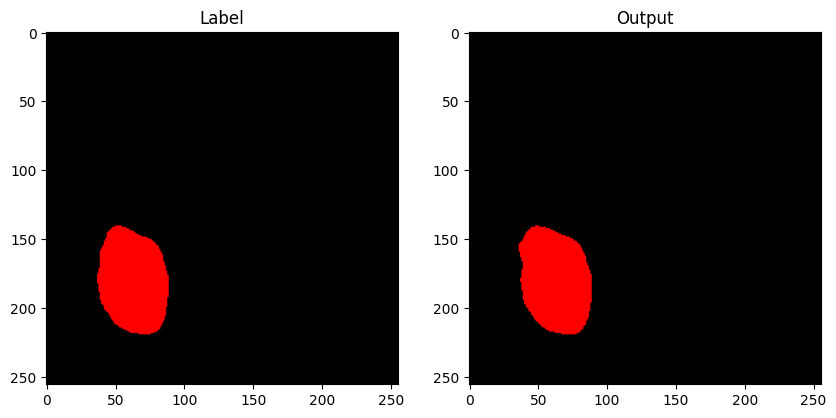

Epoch [140/200], Loss: 0.1494345762


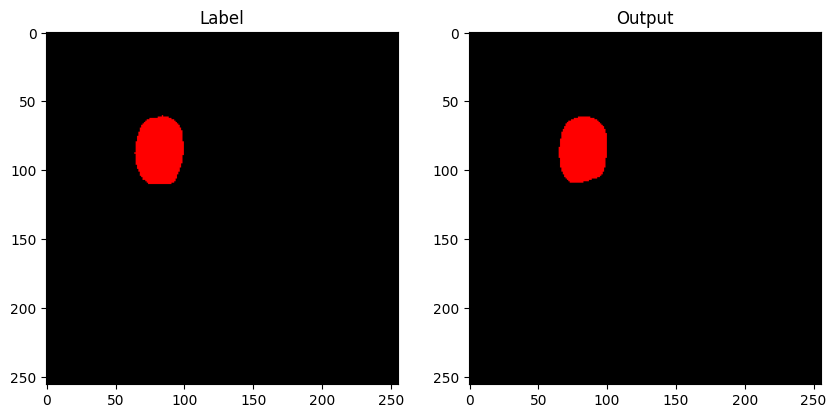

Epoch [141/200], Loss: 0.1551787921


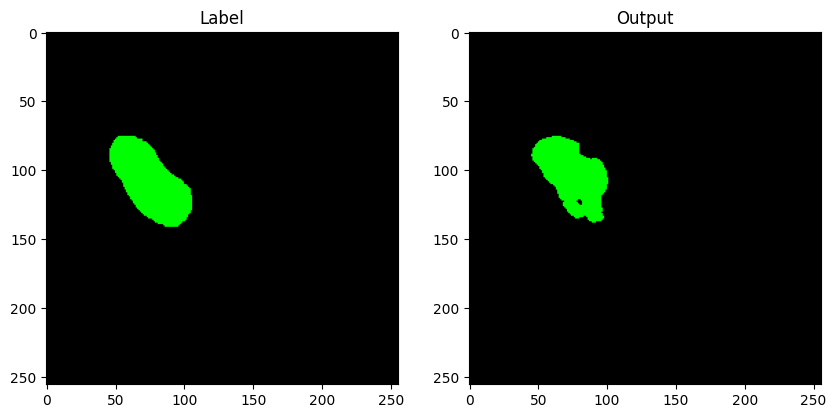

Epoch [142/200], Loss: 0.1959608312


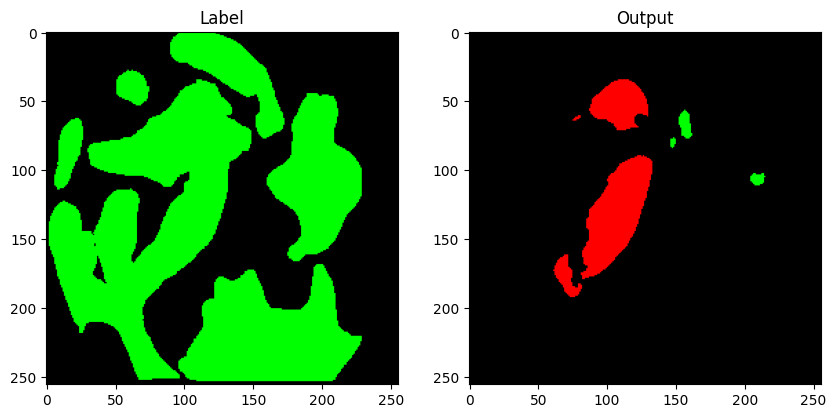

Epoch [143/200], Loss: 0.1416303951


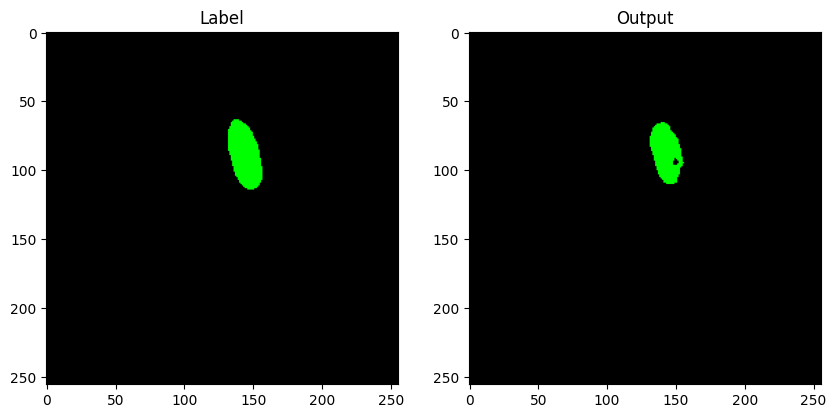

Epoch [144/200], Loss: 0.1445767559


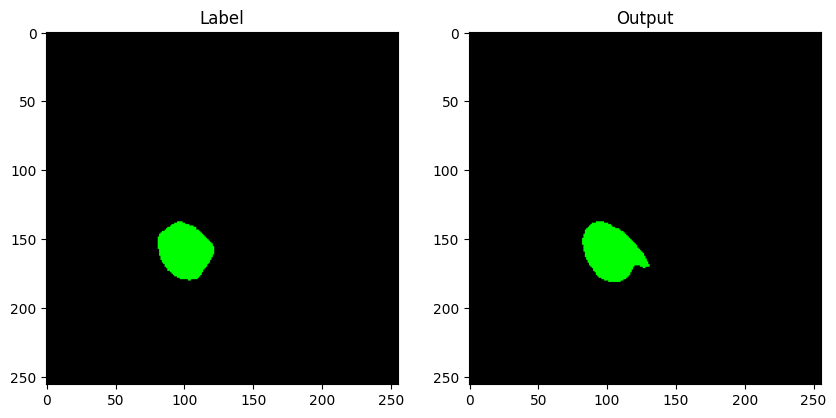

Epoch [145/200], Loss: 0.1497400876


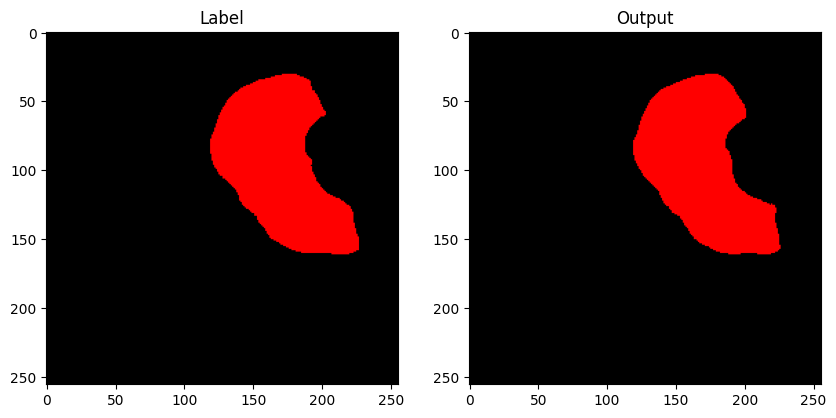

Epoch [146/200], Loss: 0.1448272511


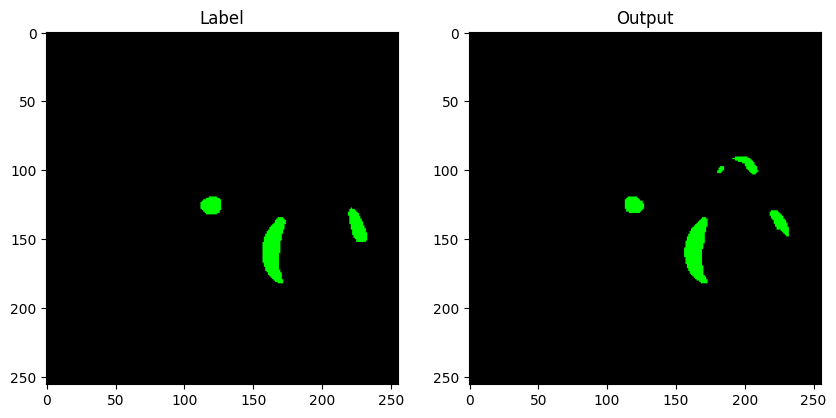

Epoch [147/200], Loss: 0.1482577209


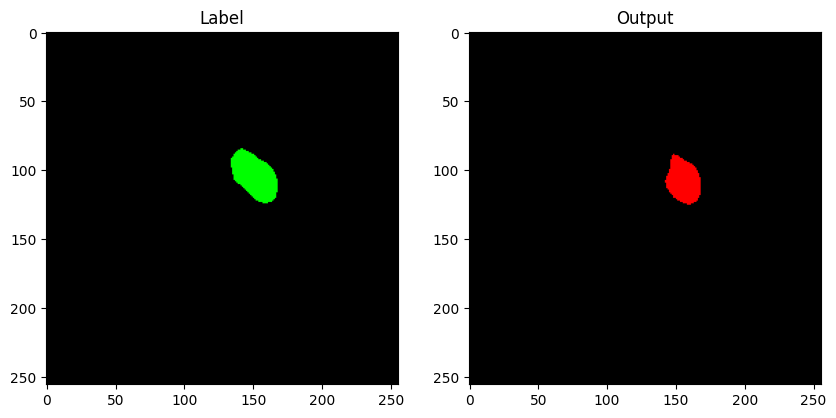

Epoch [148/200], Loss: 0.1526737051


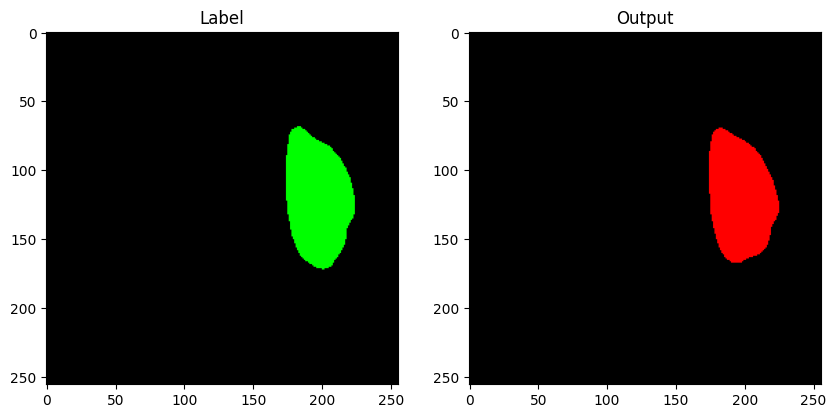

Epoch [149/200], Loss: 0.1792465448


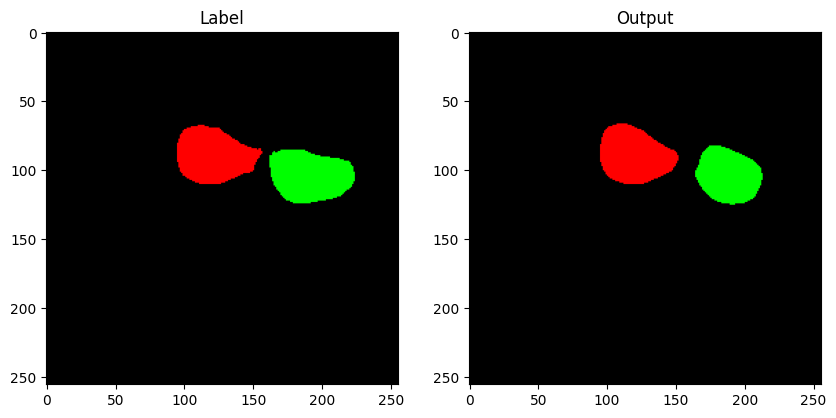

Epoch [150/200], Loss: 0.1715152506


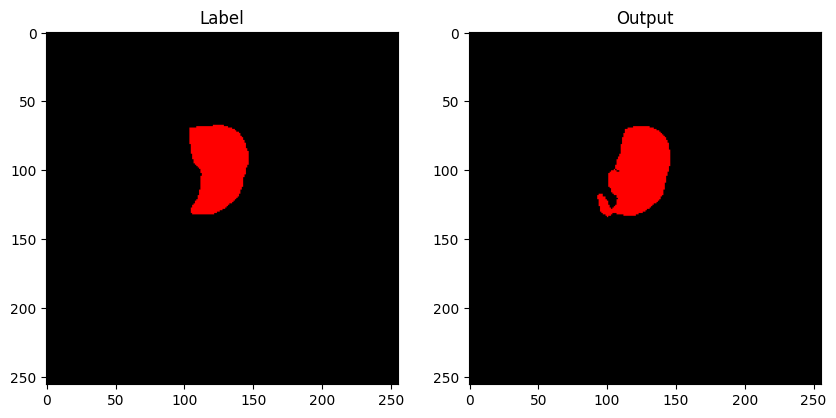

Epoch [151/200], Loss: 0.1058655216


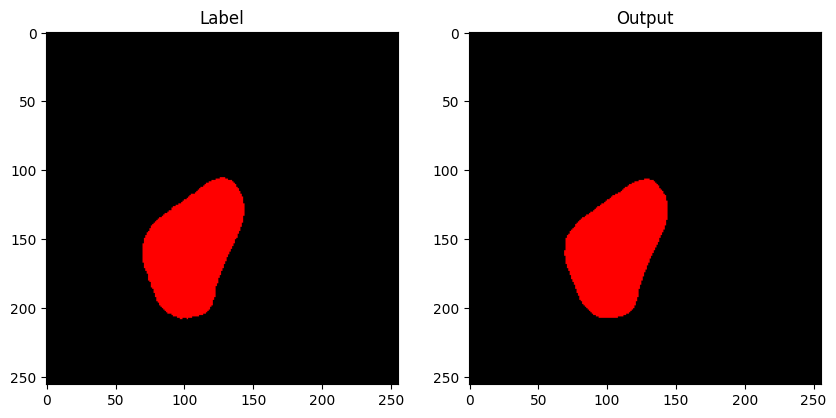

Epoch [152/200], Loss: 0.1129005521


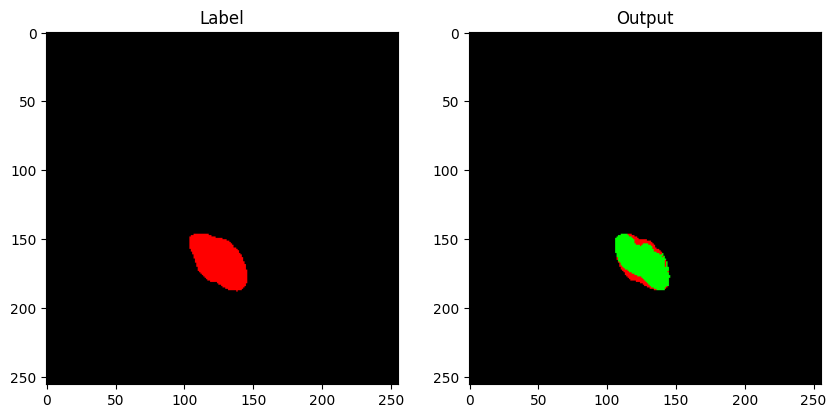

Epoch [153/200], Loss: 0.1185490338


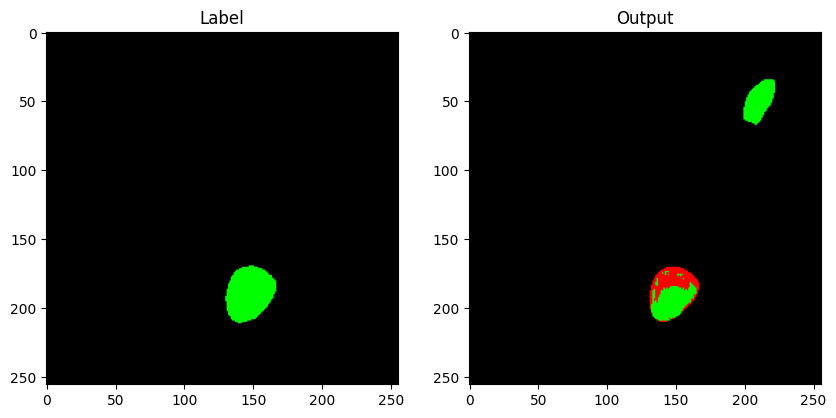

Epoch [154/200], Loss: 0.1183311555


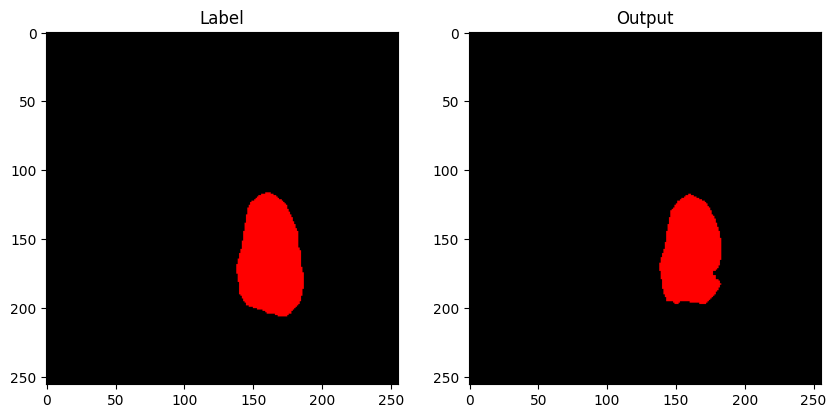

Epoch [155/200], Loss: 0.1223497697


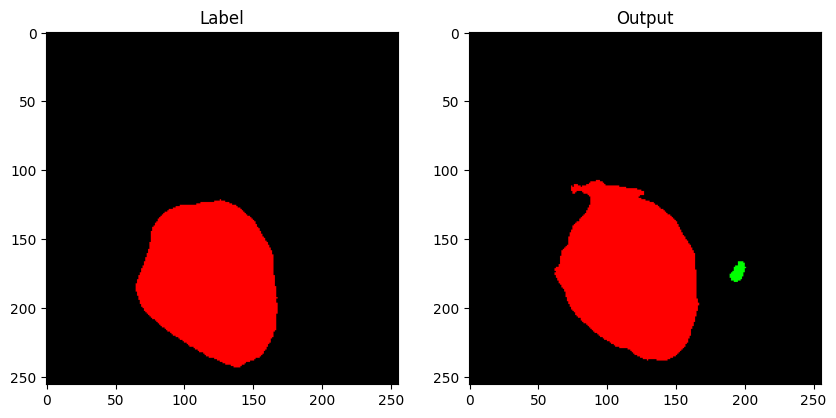

Epoch [156/200], Loss: 0.1292901877


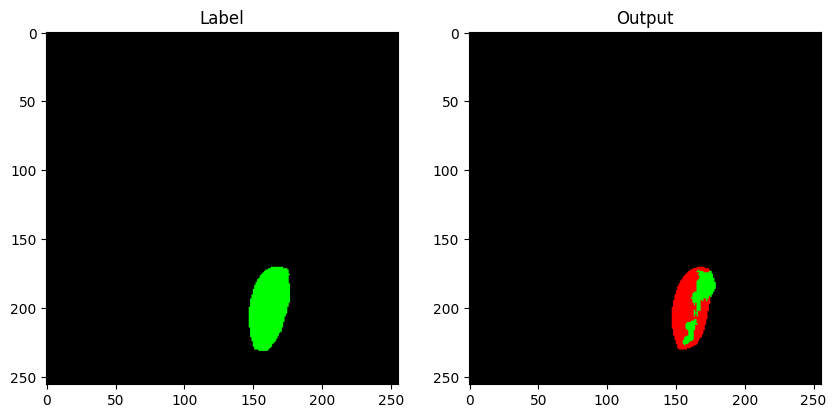

Epoch [157/200], Loss: 0.1192315529


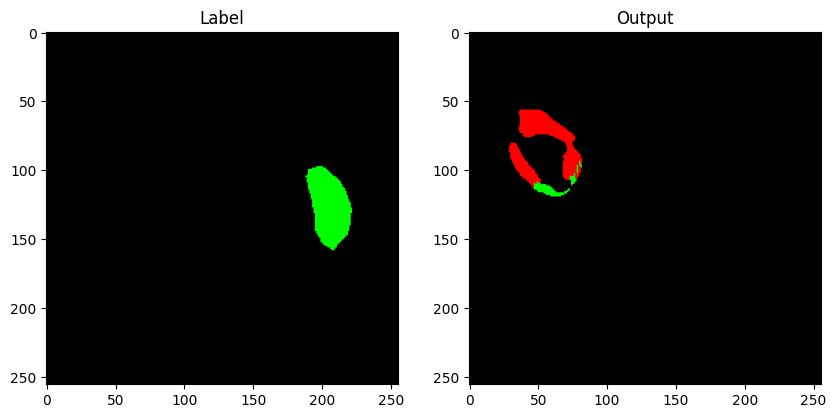

Epoch [158/200], Loss: 0.1437978117


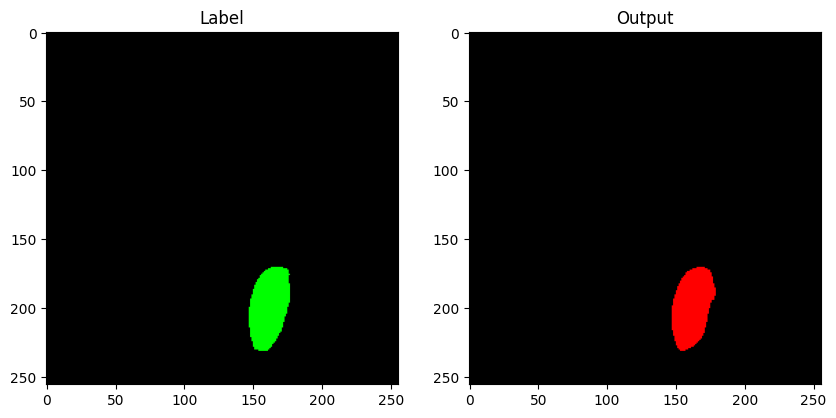

Epoch [159/200], Loss: 0.1398976666


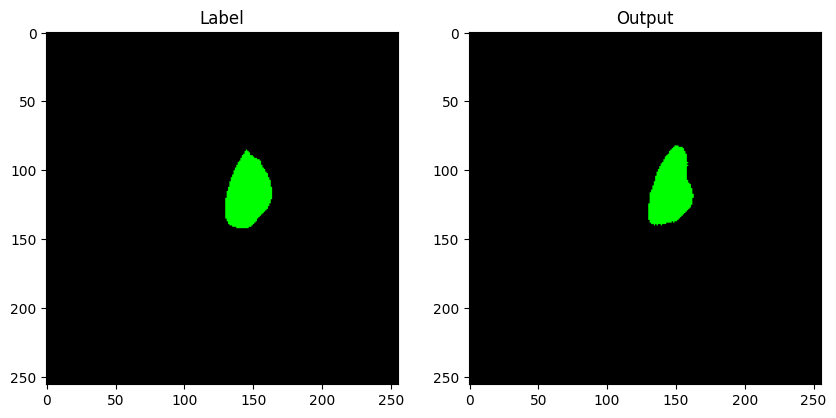

Epoch [160/200], Loss: 0.1296418011


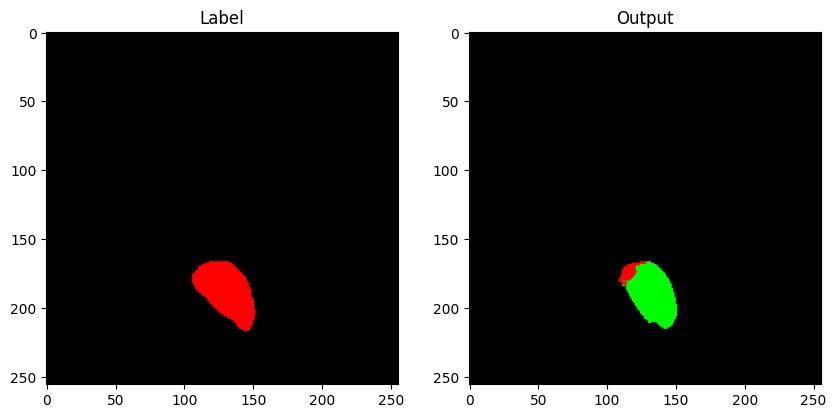

Epoch [161/200], Loss: 0.1371257685


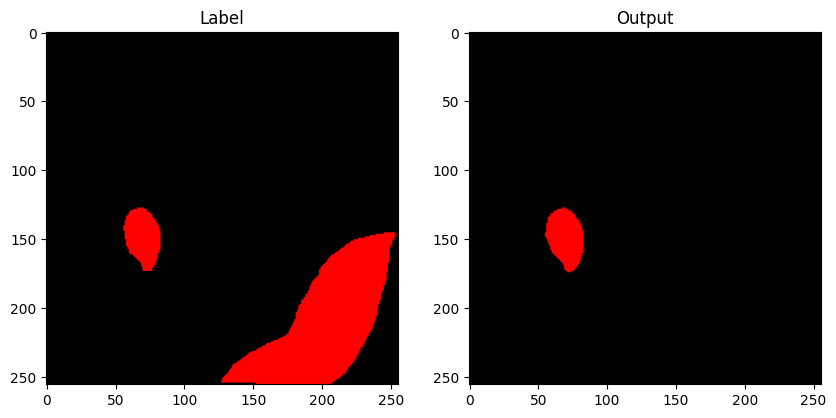

Epoch [162/200], Loss: 0.1345856135


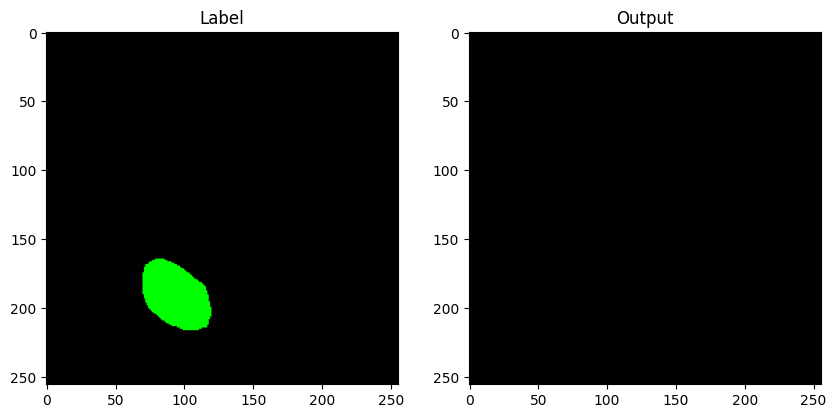

Epoch [163/200], Loss: 0.1333097952


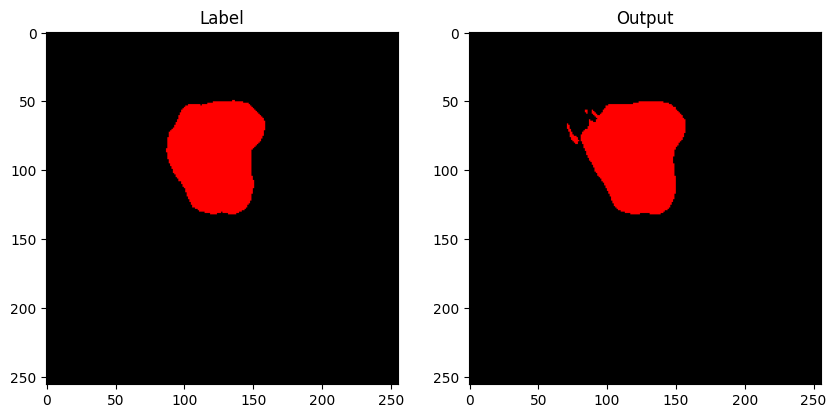

Epoch [164/200], Loss: 0.1379146126


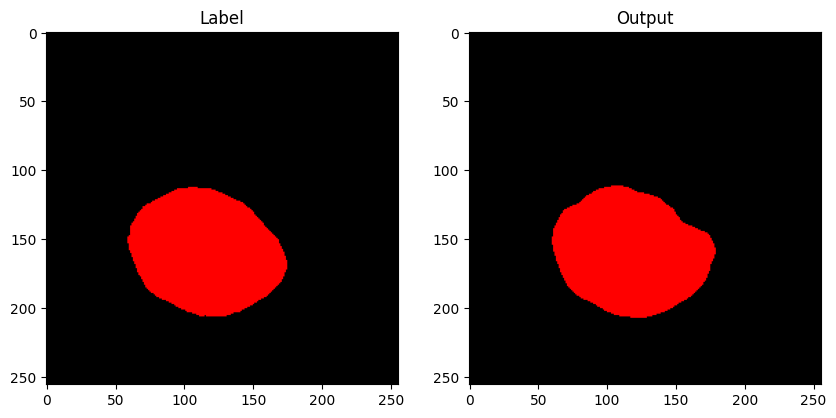

Epoch [165/200], Loss: 0.1432313638


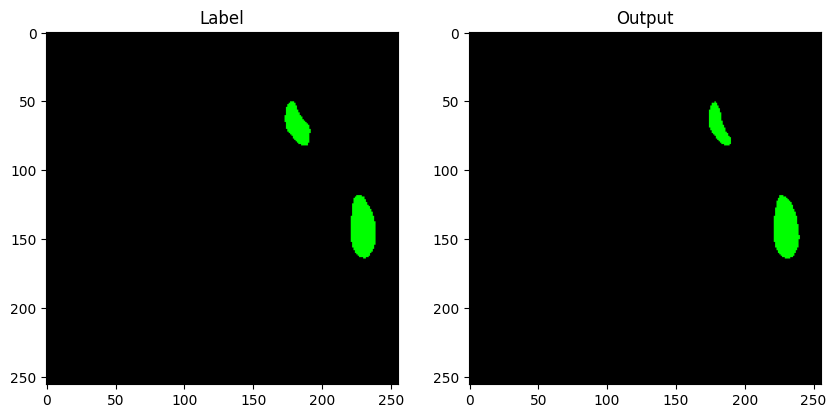

Epoch [166/200], Loss: 0.1453953431


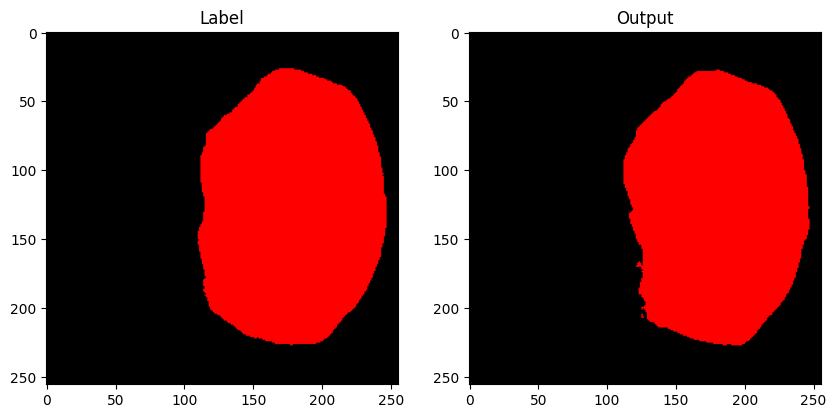

Epoch [167/200], Loss: 0.1410120919


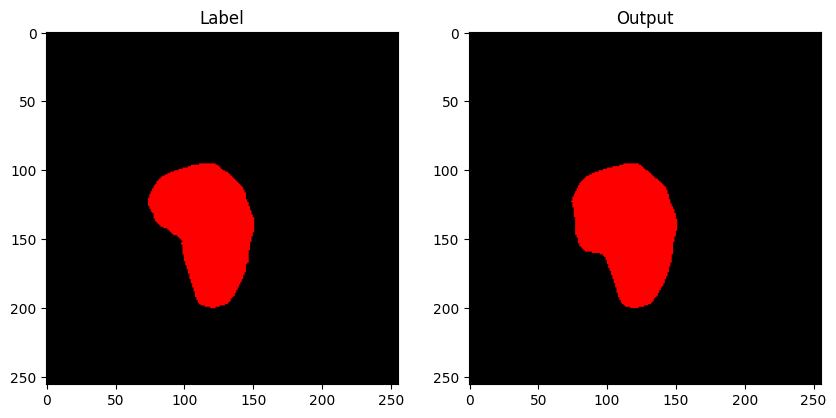

Epoch [168/200], Loss: 0.1491431731


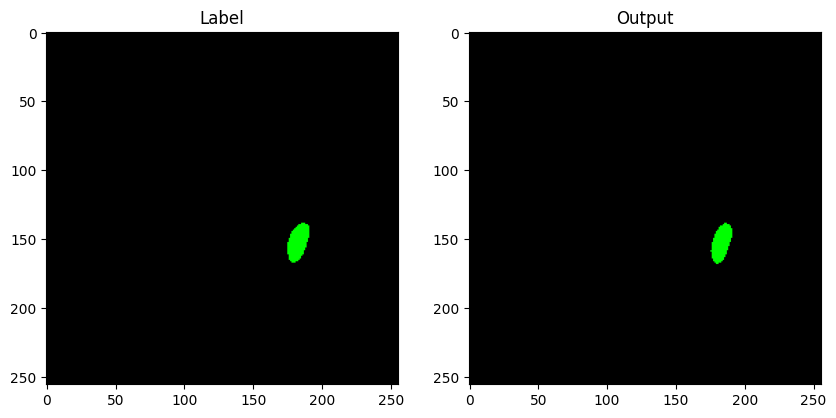

Epoch [169/200], Loss: 0.1391423364


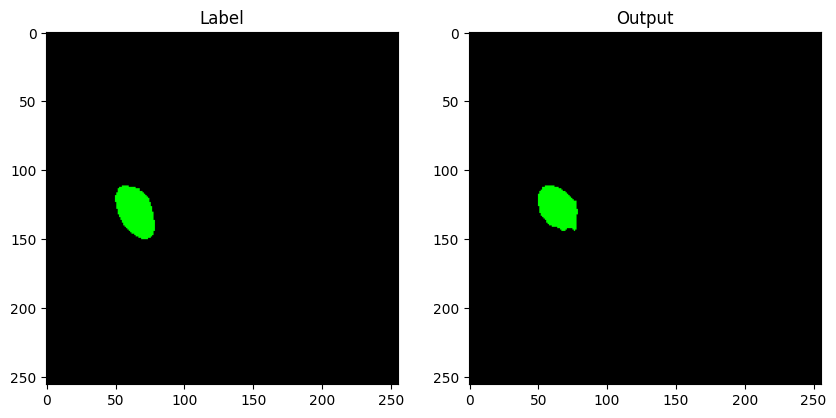

Epoch [170/200], Loss: 0.1818775199


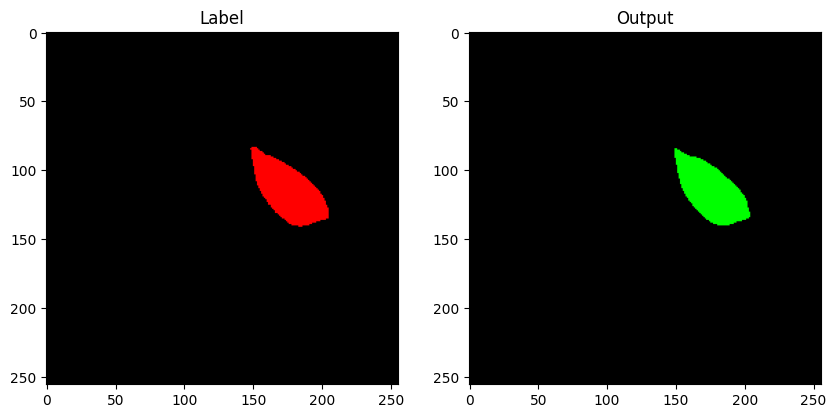

Epoch [171/200], Loss: 0.1442687380


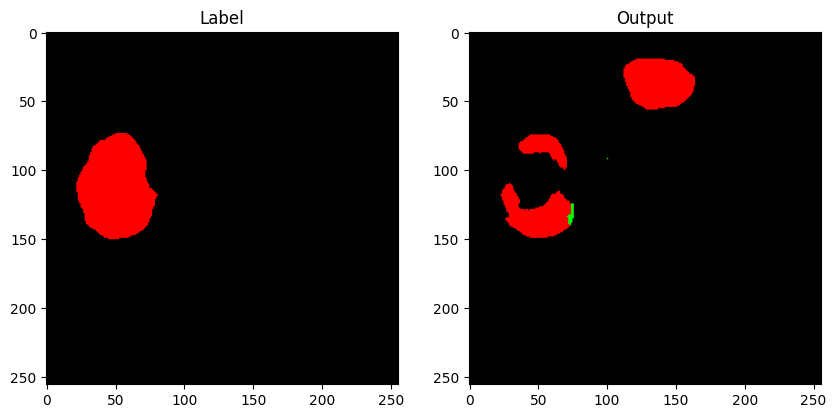

Epoch [172/200], Loss: 0.1636503782


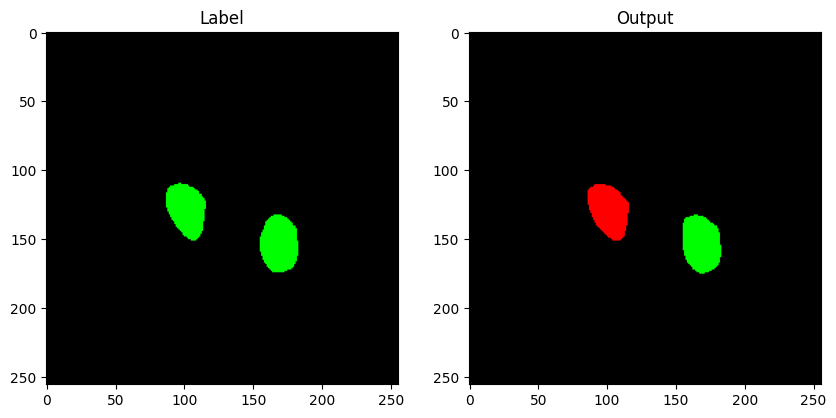

Epoch [173/200], Loss: 0.1315711221


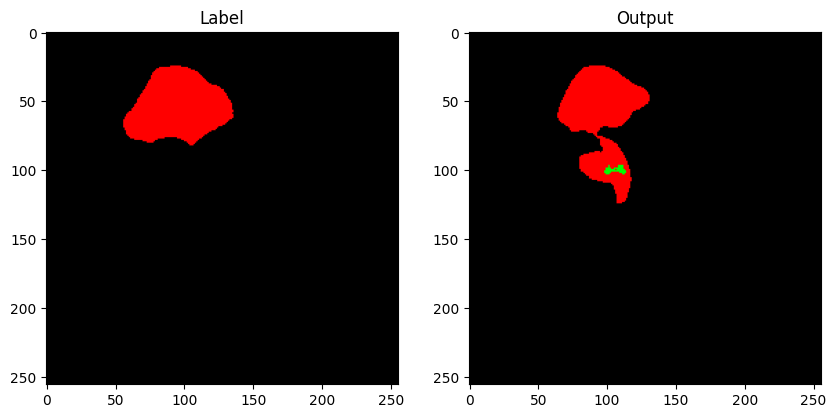

Epoch [174/200], Loss: 0.1374713011


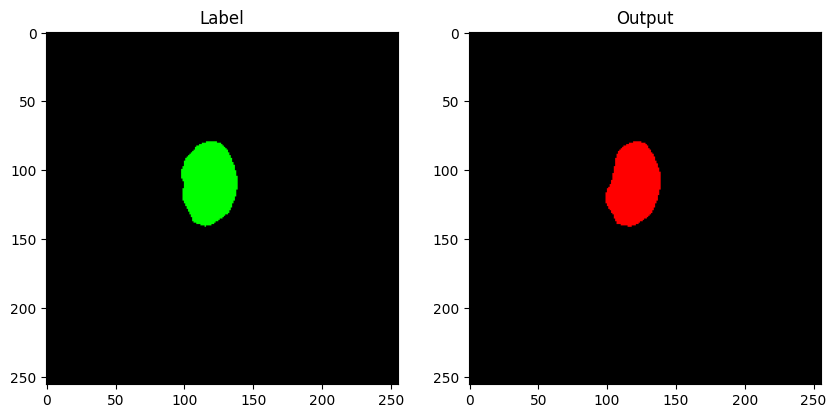

Epoch [175/200], Loss: 0.1366694428


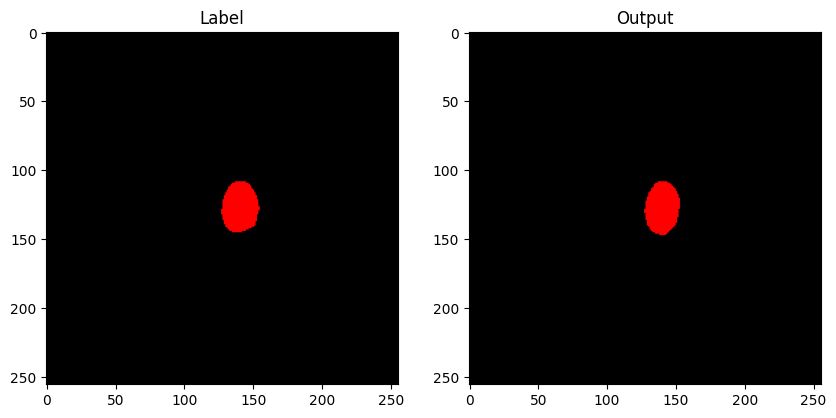

Epoch [176/200], Loss: 0.1454241812


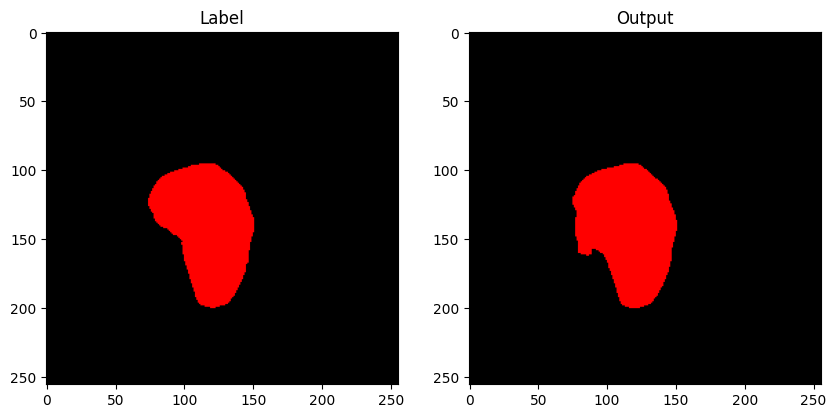

Epoch [177/200], Loss: 0.1468612749


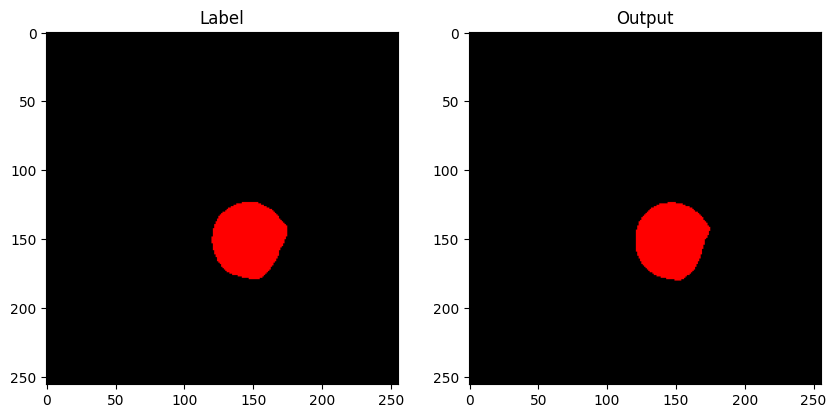

Epoch [178/200], Loss: 0.1400286529


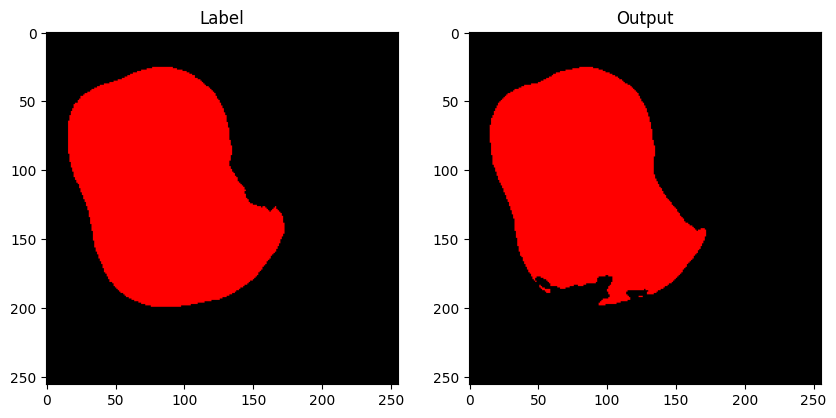

Epoch [179/200], Loss: 0.1407956290


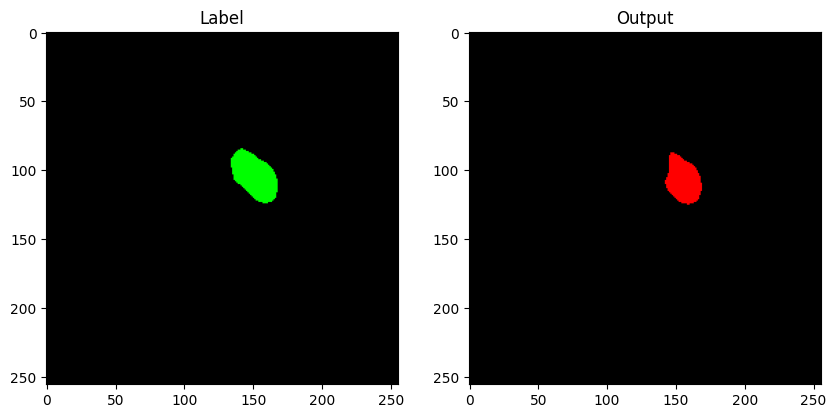

Epoch [180/200], Loss: 0.2005706117


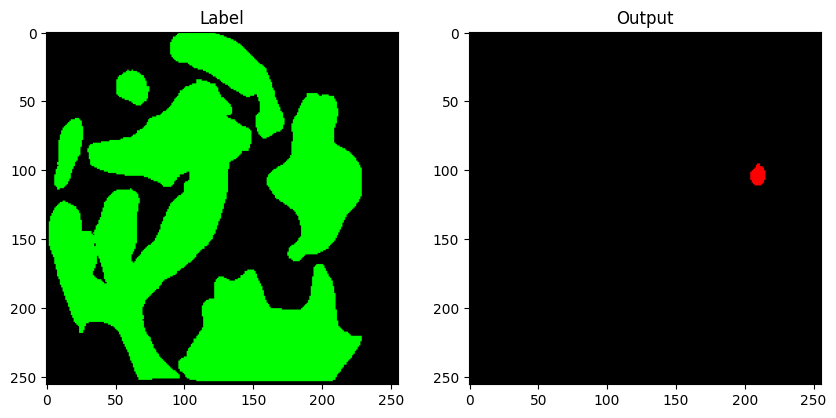

Epoch [181/200], Loss: 0.1438877548


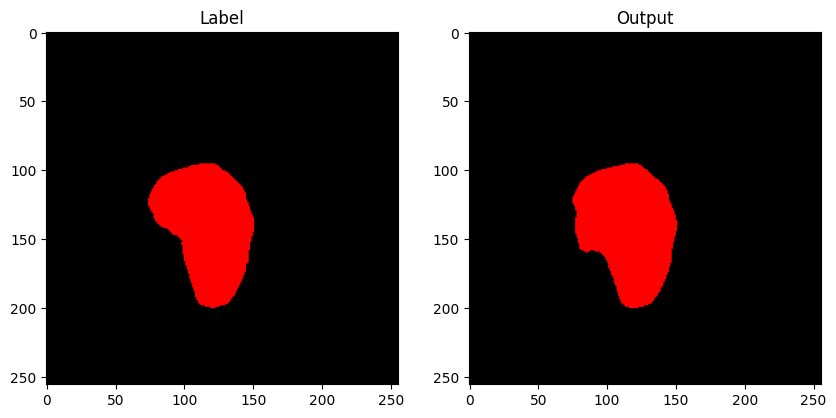

Epoch [182/200], Loss: 0.1500237455


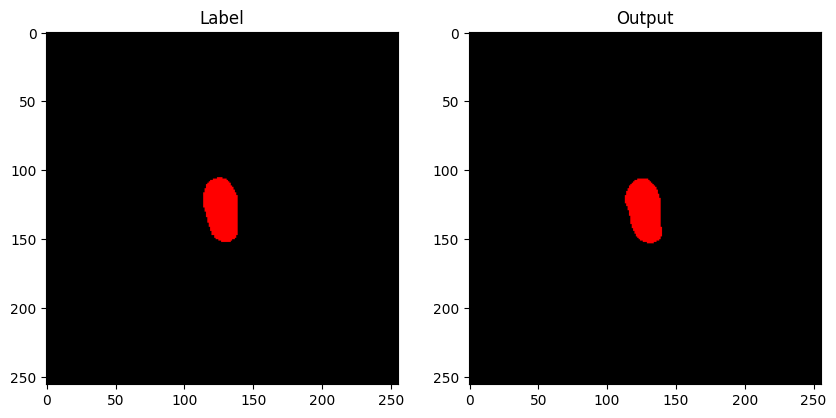

Epoch [183/200], Loss: 0.1412340838


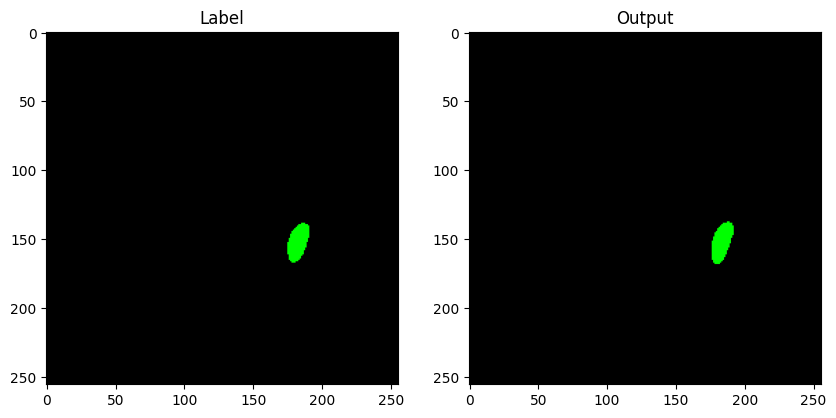

Epoch [184/200], Loss: 0.1433708487


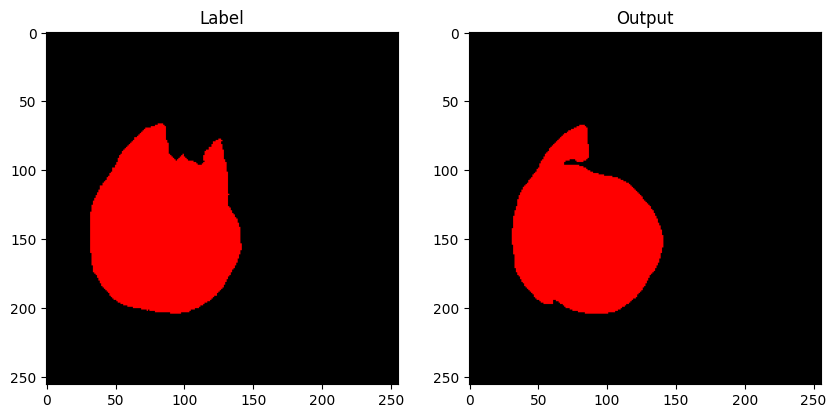

Epoch [185/200], Loss: 0.1433626375


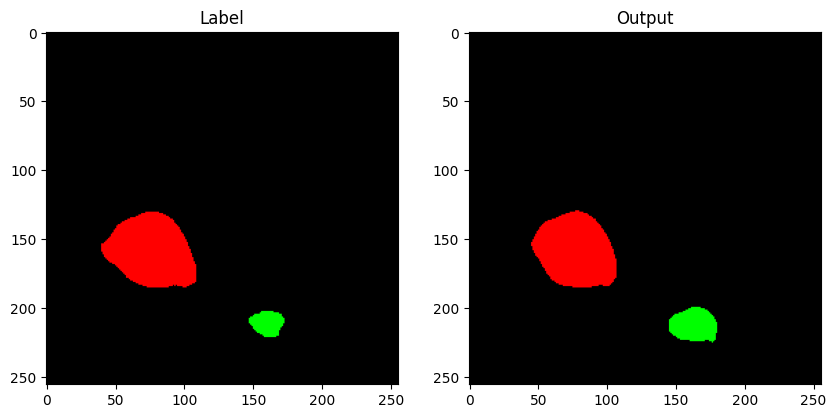

Epoch [186/200], Loss: 0.1623503660


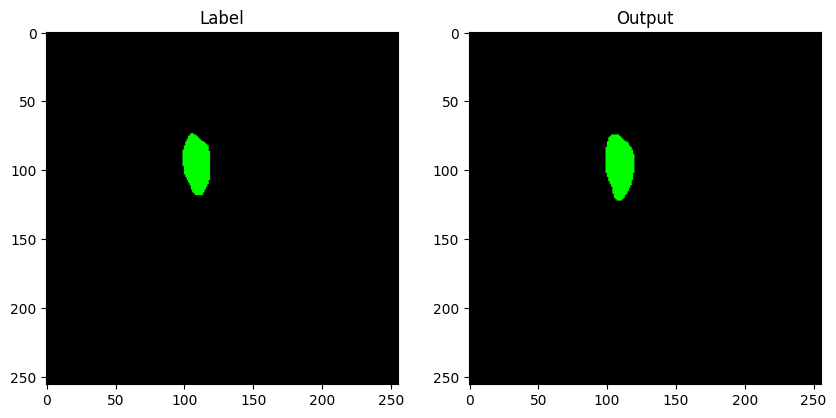

Epoch [187/200], Loss: 0.1458324160


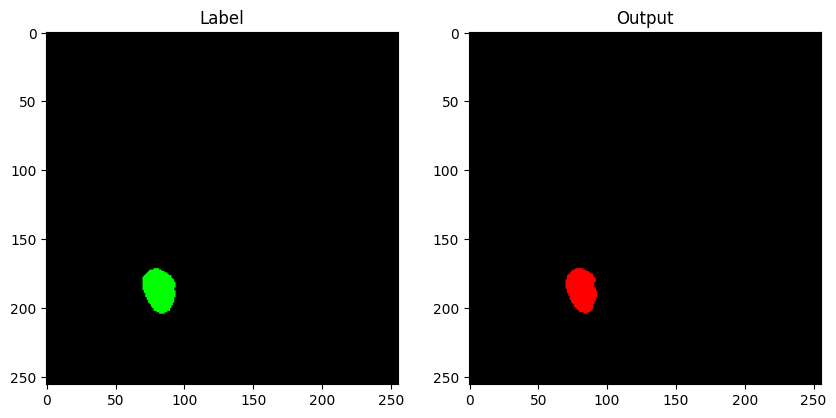

Epoch [188/200], Loss: 0.1354792181


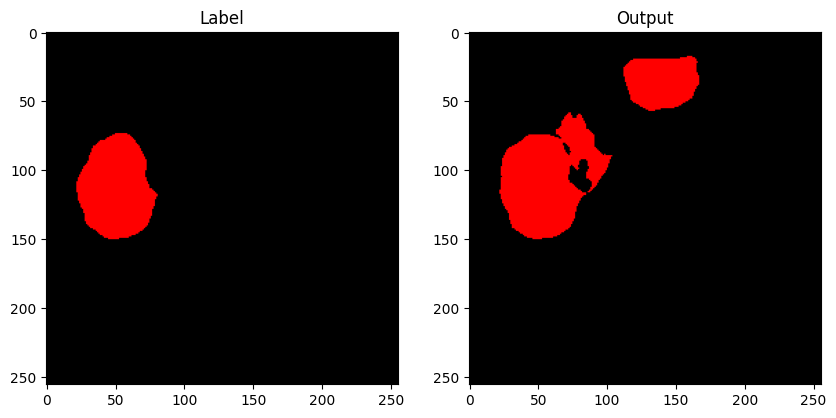

Epoch [189/200], Loss: 0.1300937539


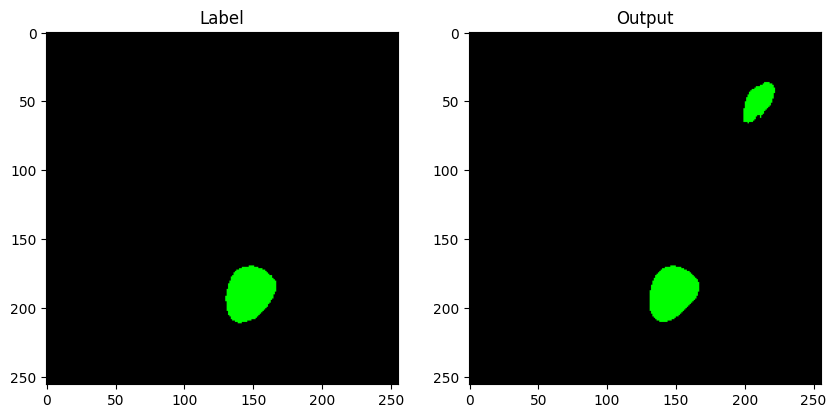

Epoch [190/200], Loss: 0.1305821413


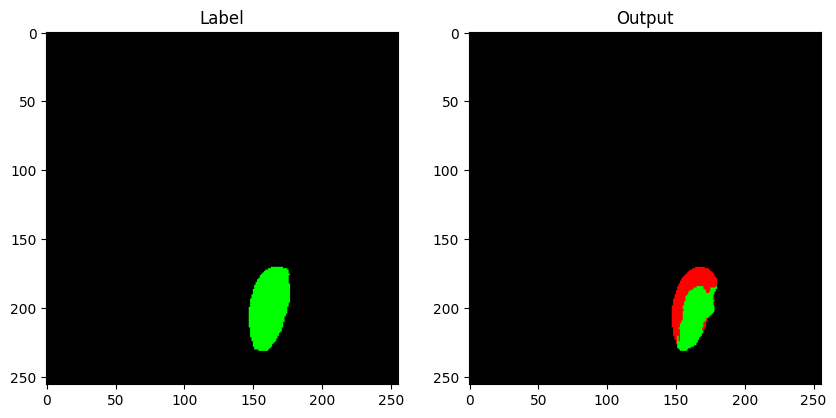

Epoch [191/200], Loss: 0.1260009219


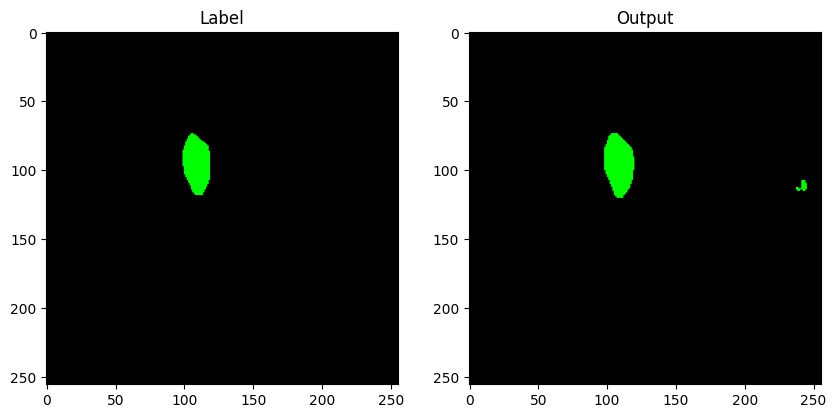

Epoch [192/200], Loss: 0.1489432481


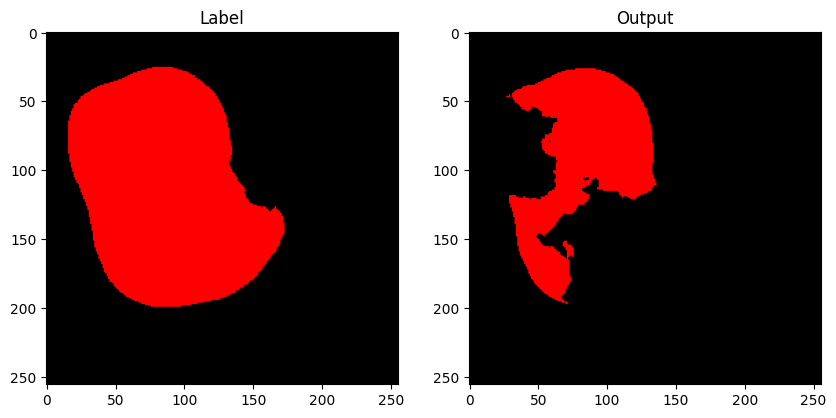

Epoch [193/200], Loss: 0.1409352890


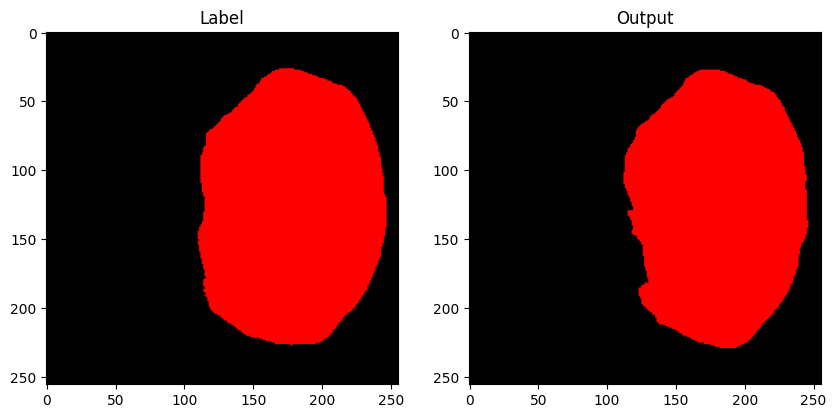

Epoch [194/200], Loss: 0.1435959660


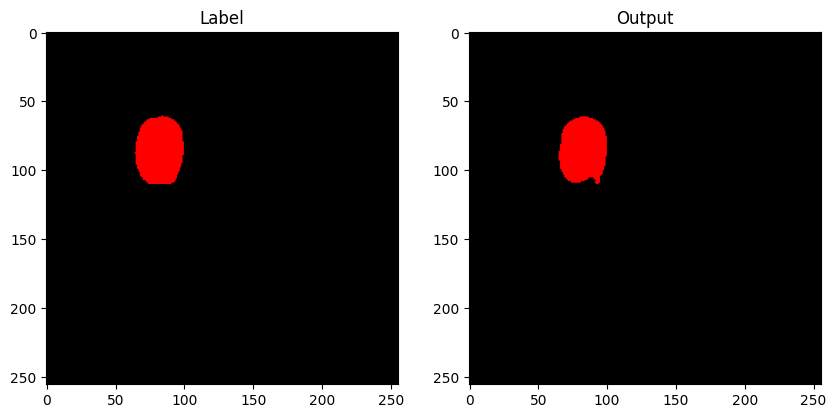

Epoch [195/200], Loss: 0.1434040691


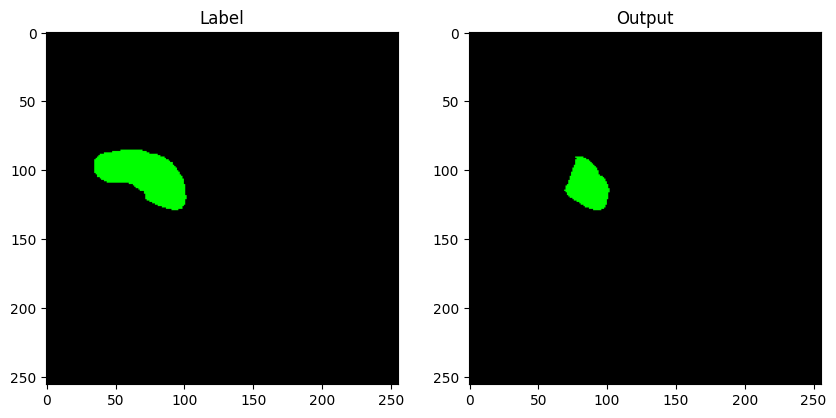

Epoch [196/200], Loss: 0.1461446454


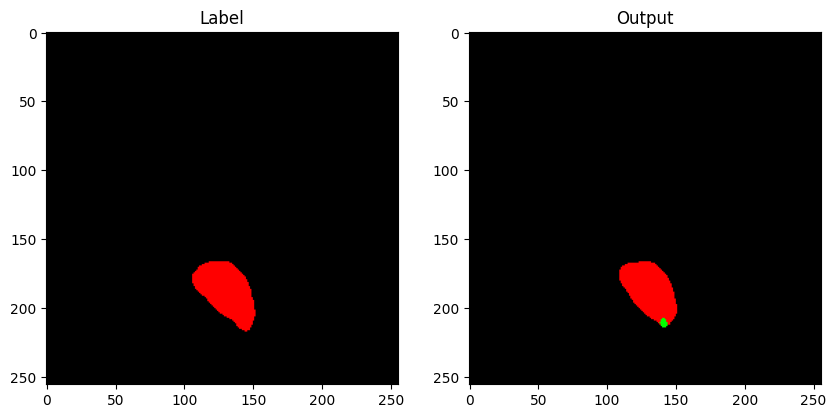

Epoch [197/200], Loss: 0.1523893553


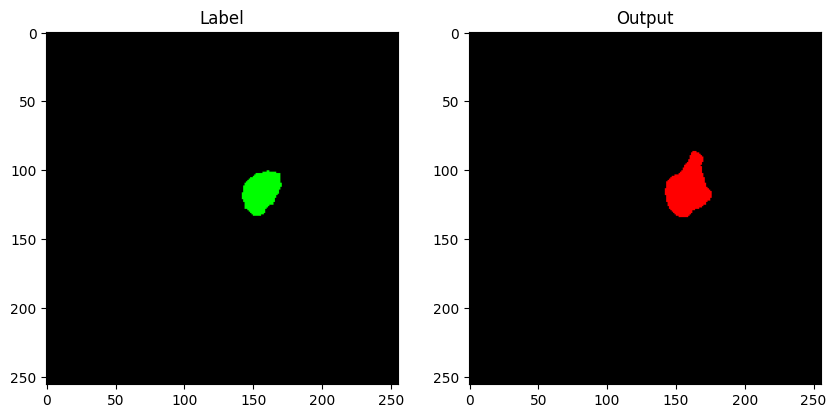

Epoch [198/200], Loss: 0.1470815294


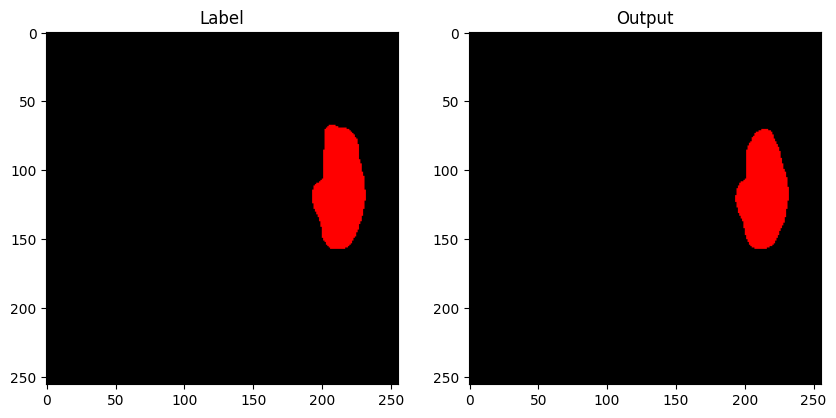

Epoch [199/200], Loss: 0.1656482331


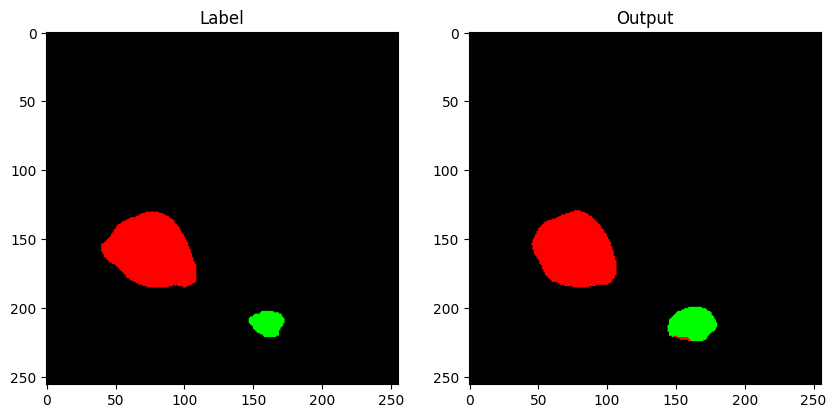

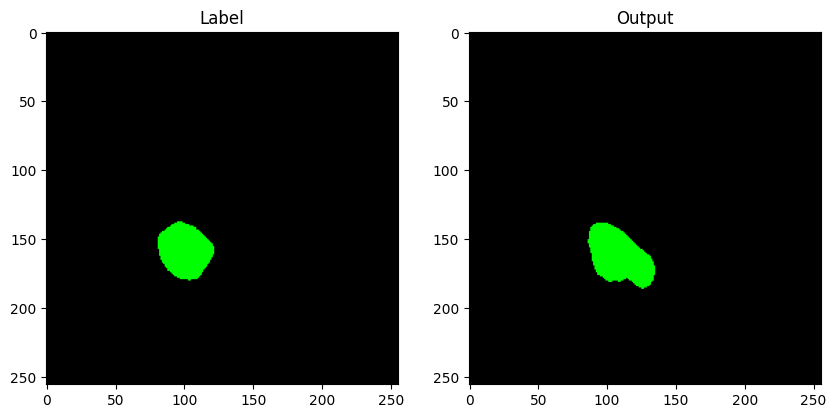

In [ ]:
num_epochs = 200

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
best_val_loss = 999

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        labels = labels.squeeze(dim=1).long()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.squeeze(dim=1).long()

            outputs = model(images)

            val_loss += criterion(outputs.float(),labels.long()).item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss/len(val_loader):.10f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = {
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': val_loss,
        }
        save_path = f'colorization_model.pth'
        torch.save(checkpoint, save_path)
        print('Save new model')
    wandb.log({'Val_loss': val_loss/len(val_loader),
               'Train_loss': train_loss/len(train_loader)
              })

    label = labels[0].cpu().numpy()
    label = mask_to_rgb(label,color_dict)
    outputs[0] = outputs[0].softmax(dim=0)
    output = outputs[0].cpu().numpy()
    output = np.argmax(output, axis=0)
    output = mask_to_rgb(output,color_dict)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(label)
    axs[0].set_title('Label')
    axs[1].imshow(output)
    axs[1].set_title('Output')
    plt.show()

In [ ]:
checkpoint = torch.load('colorization_model.pth')
model.load_state_dict(checkpoint['model'])
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)

<ipython-input-29-f5ce3d5dffc9>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('colorization_model.pth')


UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [ ]:
!mkdir prediction

In [ ]:
trainsize = 256
model.eval()
for i in os.listdir("/content/test/test"):
    img_path = os.path.join("/content/test/test", i)
    ori_img = cv2.imread(img_path)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    ori_w = ori_img.shape[0]
    ori_h = ori_img.shape[1]
    img = cv2.resize(ori_img, (trainsize, trainsize))
    transformed = val_transform(image=img)
    input_img = transformed["image"]
    input_img = input_img.unsqueeze(0).to(device)
    with torch.no_grad():
        output_mask = model.forward(input_img).squeeze(0).cpu().numpy().transpose(1,2,0)
    mask = cv2.resize(output_mask, (ori_h, ori_w))
    mask = np.argmax(mask, axis=2)
    mask_rgb = mask_to_rgb(mask, color_dict)
    mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite("prediction/{}".format(i), mask_rgb)

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 225] = 255
    pixels[pixels <= 225] = 0
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]

    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/content/prediction'
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']

df.to_csv(r'output.csv', index=False)
print('Done')

/content/prediction/94a7f32574d6c748c41743c6c08a1d1a.jpeg
/content/prediction/30c2f4fc276ed9f178dc2f4af6266509.jpeg
/content/prediction/e9082ea2c193ac8d551c149b60f29653.jpeg
/content/prediction/39dda50f954ba59c7de13a35276a4764.jpeg
/content/prediction/395e56a6d9ba9d45c3dbc695325ded46.jpeg
/content/prediction/782707d7c359e27888daefee82519763.jpeg
/content/prediction/67d4dcf9596154efb7cef748d9cbd617.jpeg
/content/prediction/1002ec4a1fe748f3085f1ce88cbdf366.jpeg
/content/prediction/314fe384eb2ba3adfda6c1899fdc9837.jpeg
/content/prediction/ca4d5060a633a8d5b2b2b55157b7781e.jpeg
/content/prediction/6f4d4987ea3b4bae5672a230194c5a08.jpeg
/content/prediction/5beb48f0be11d0309d1dff09b8405734.jpeg
/content/prediction/4baddc22268d4b4ef4d95ceea1195799.jpeg
/content/prediction/1531871f2fd85a04faeeb2b535797395.jpeg
/content/prediction/6b83ef461c2a337948a41964c1d4f50a.jpeg
/content/prediction/3c3ca4d5060a633a8d5b2b2b55157b77.jpeg
/content/prediction/c41545ba55aadaa77712a48e11d579d9.jpeg
/content/predi

In [ ]:
!ls /content


bkai-igh-neopolyp.zip	content     prediction	 sample_submission.csv	train	  wandb
colorization_model.pth	output.csv  sample_data  test			train_gt


In [ ]:
from google.colab import files
files.download('/content/output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>